In [1]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.core import read, Stream, UTCDateTime

# Caclulate peak GNSS and plot in log scale

In [2]:
path_to_files = '/Users/sydneydybing/StrainProject/2024/gnss_data/'

rt_1hz_M7_path = path_to_files + 'Ridgecrest_GNSS_2019/RealTime_1Hz/M7.1/'
rt_1hz_M6_path = path_to_files + 'Ridgecrest_GNSS_2019/RealTime_1Hz/M6.4/'
proc_5hz_M7_path = path_to_files + 'Ridgecrest_GNSS_2019/PostProcessed_5Hz/M7.1/'
proc_5hz_M6_path = path_to_files + 'Ridgecrest_GNSS_2019/PostProcessed_5Hz/M6.4/'
proc_1hz_M7_path = path_to_files + 'Ridgecrest_GNSS_2019/PostProcessed_1Hz/M7.1/'
proc_1hz_M6_path = path_to_files + 'Ridgecrest_GNSS_2019/PostProcessed_1Hz/M6.4/'

usgs_6_ot = UTCDateTime('2019-07-04T17:33:49.000Z')
usgs_7_ot = UTCDateTime('2019-07-06T03:19:53.040Z')

In [3]:
unav_realtime_data = np.load(path_to_files + 'RC_for_strain_project_subset_data.npy')
unav_realtime_metadata = np.load(path_to_files + 'RC_for_strain_project_subset_metadata.npy')

# Metadata columns:
# 0: station name
# 1: date sample came from
# 2: sample start time
# 3: sample end time
# 4: random n counter
# 5: sample P-wave arrives at (gauss pos)
# 6: earthquake magnitude

small_test = False
m = np.where(unav_realtime_metadata[:,0] == 'CCCC')[0]

if small_test:
    unav_realtime_data = unav_realtime_data[m]
    unav_realtime_metadata = unav_realtime_metadata[m]

In [4]:
unav_realtime_data.shape

(98, 384)

In [5]:
def get_peak_gnss(gnss_data, p_arr_samp):
    
    mod_gnss_data = gnss_data.copy()
    
    p_arr_gnss = gnss_data[p_arr_samp]
    mod_gnss_data[:p_arr_samp] = p_arr_gnss
    
    peak_gnss_data = mod_gnss_data.copy()
    
    for k in range(0,len(mod_gnss_data)):
        if k == 0:
            gnss = mod_gnss_data[0]
            max_gnss = gnss
        else:
            gnss = mod_gnss_data[:k+1]
            max_gnss = max(gnss)
        peak_gnss_data[k] = max_gnss 
        
    return peak_gnss_data

CCCC 6.4
P463 6.4
No published RT data for station p463
P580 6.4
P590 6.4
No published RT data for station p590
P592 6.4
No published RT data for station p592
P593 6.4
P595 6.4
P616 6.4
RAMT 6.4


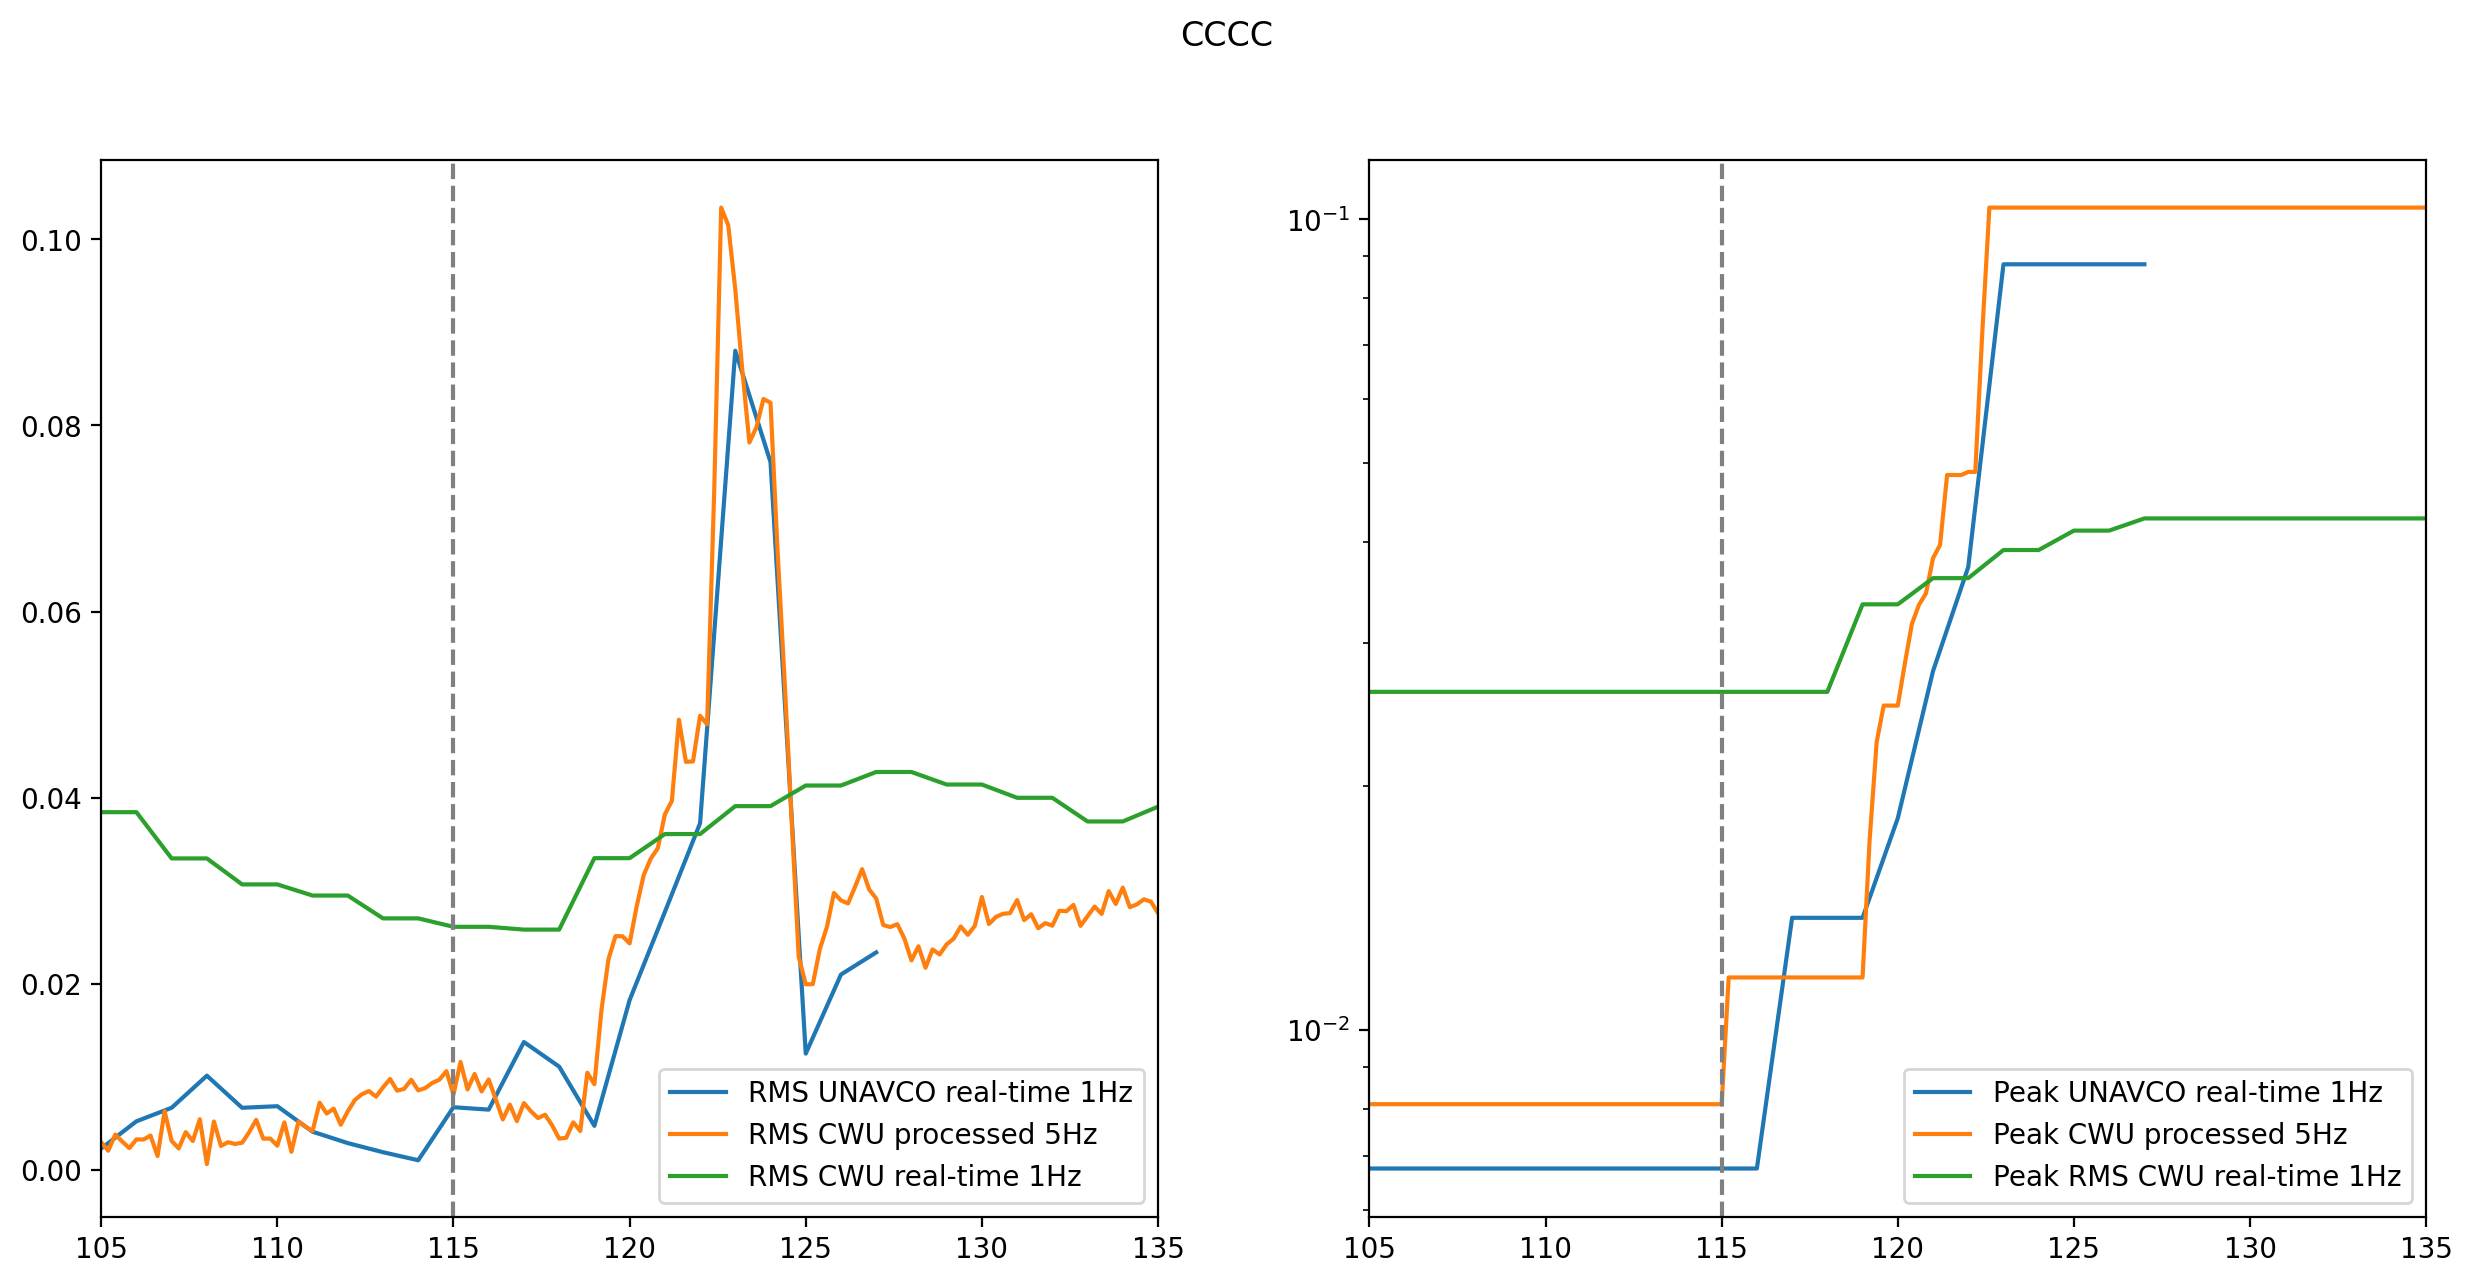

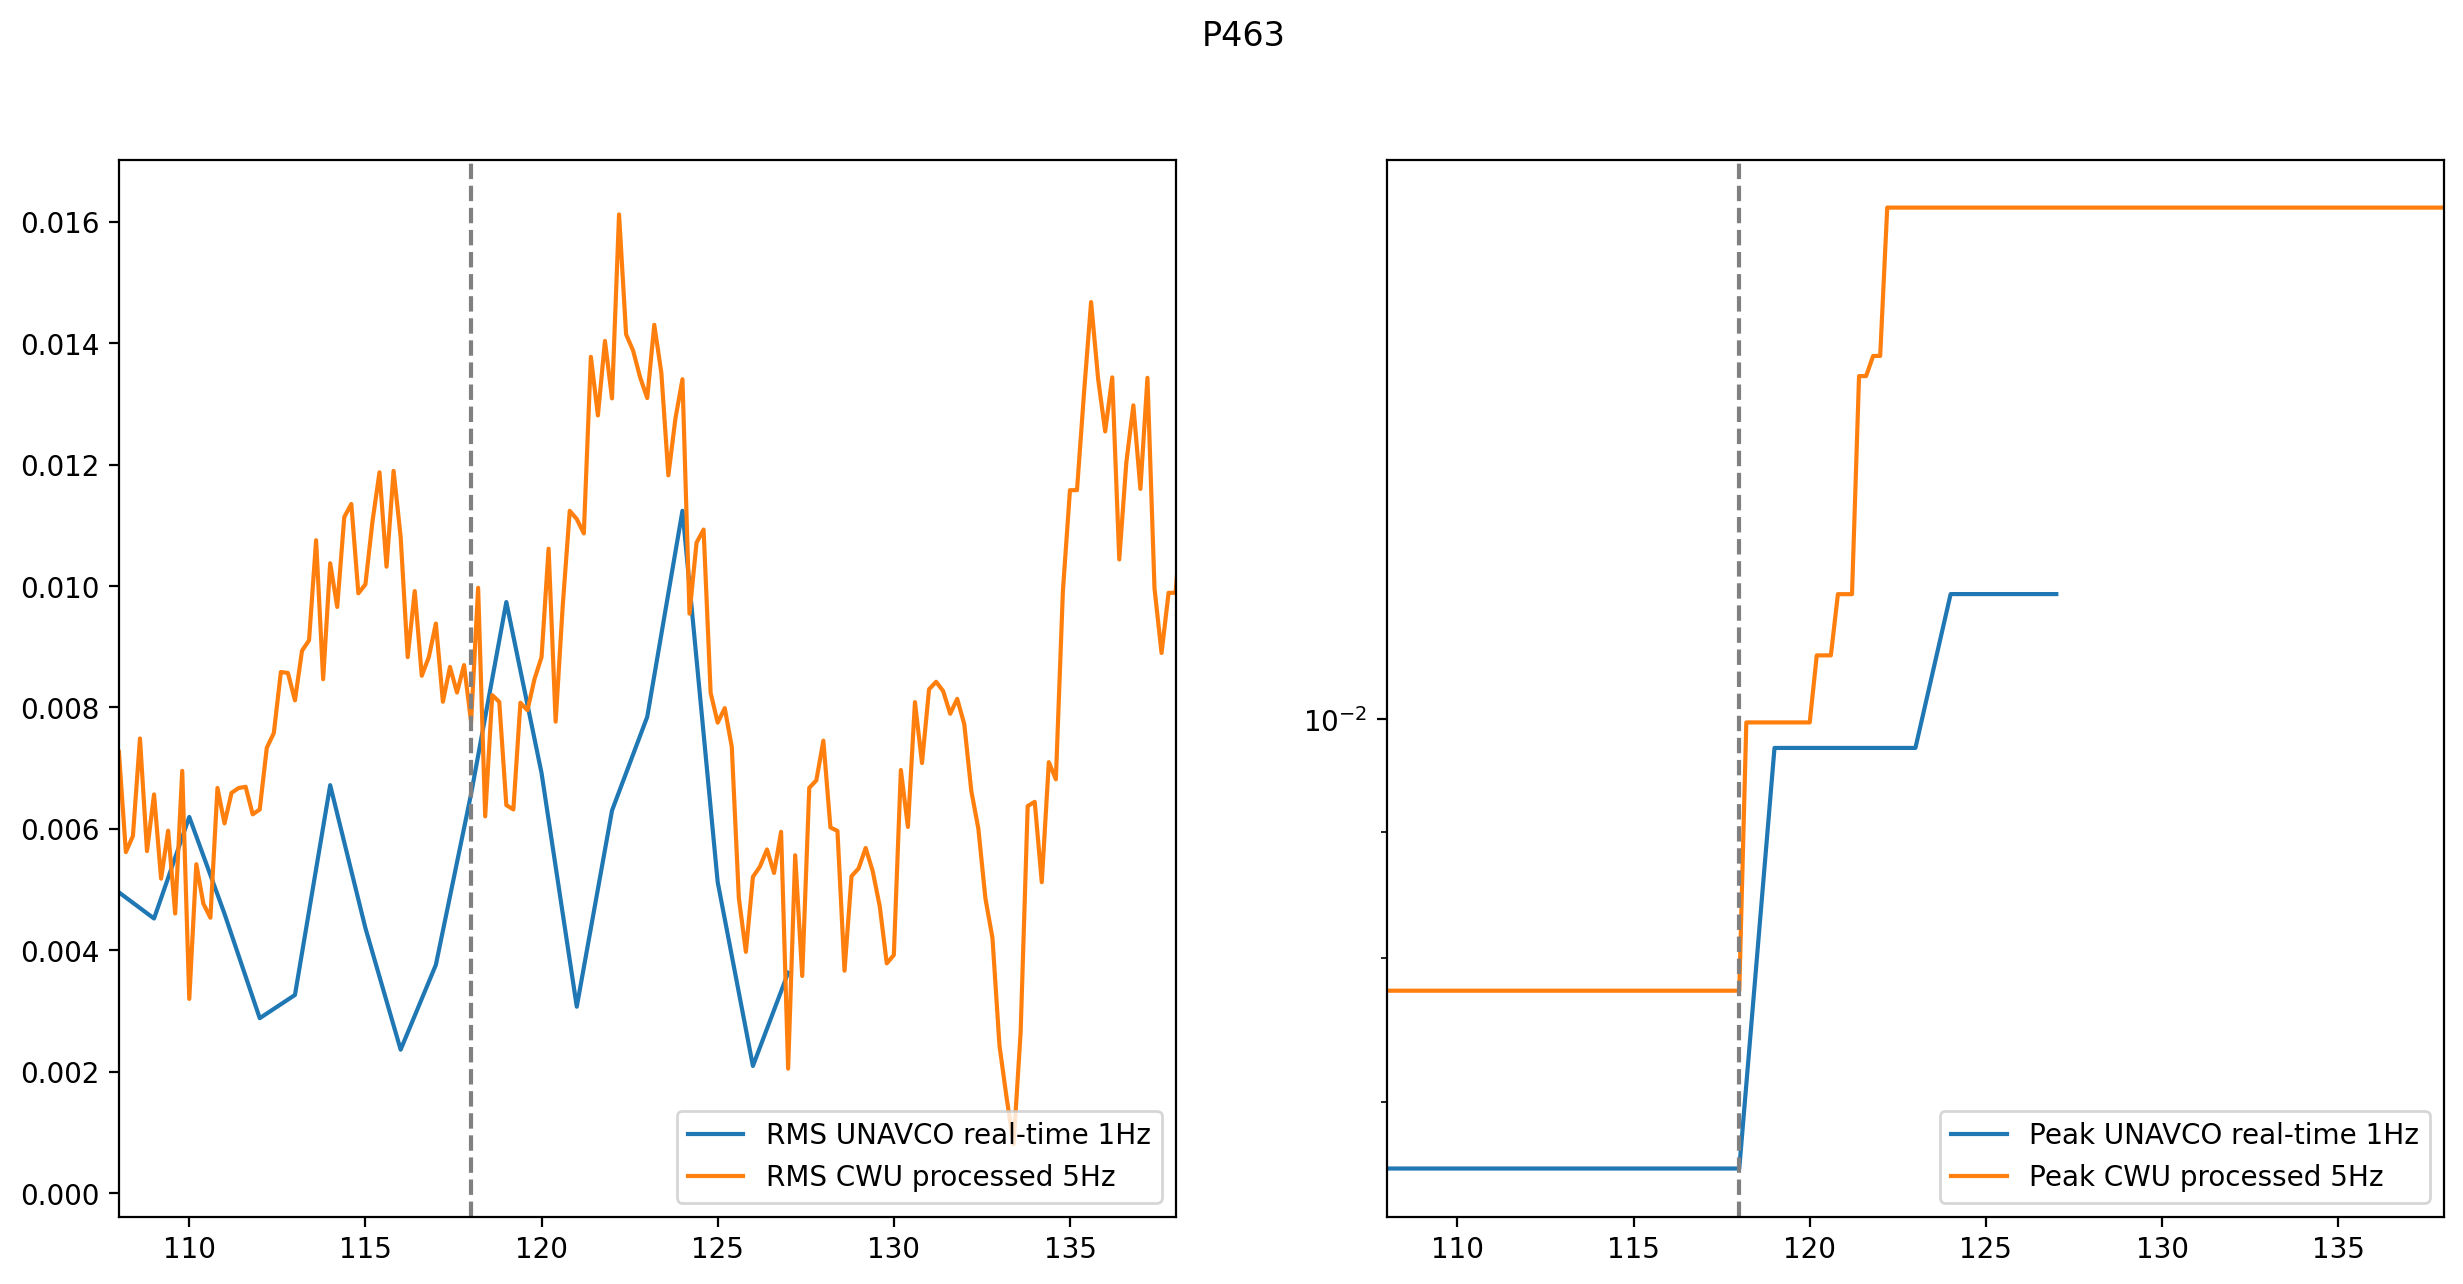

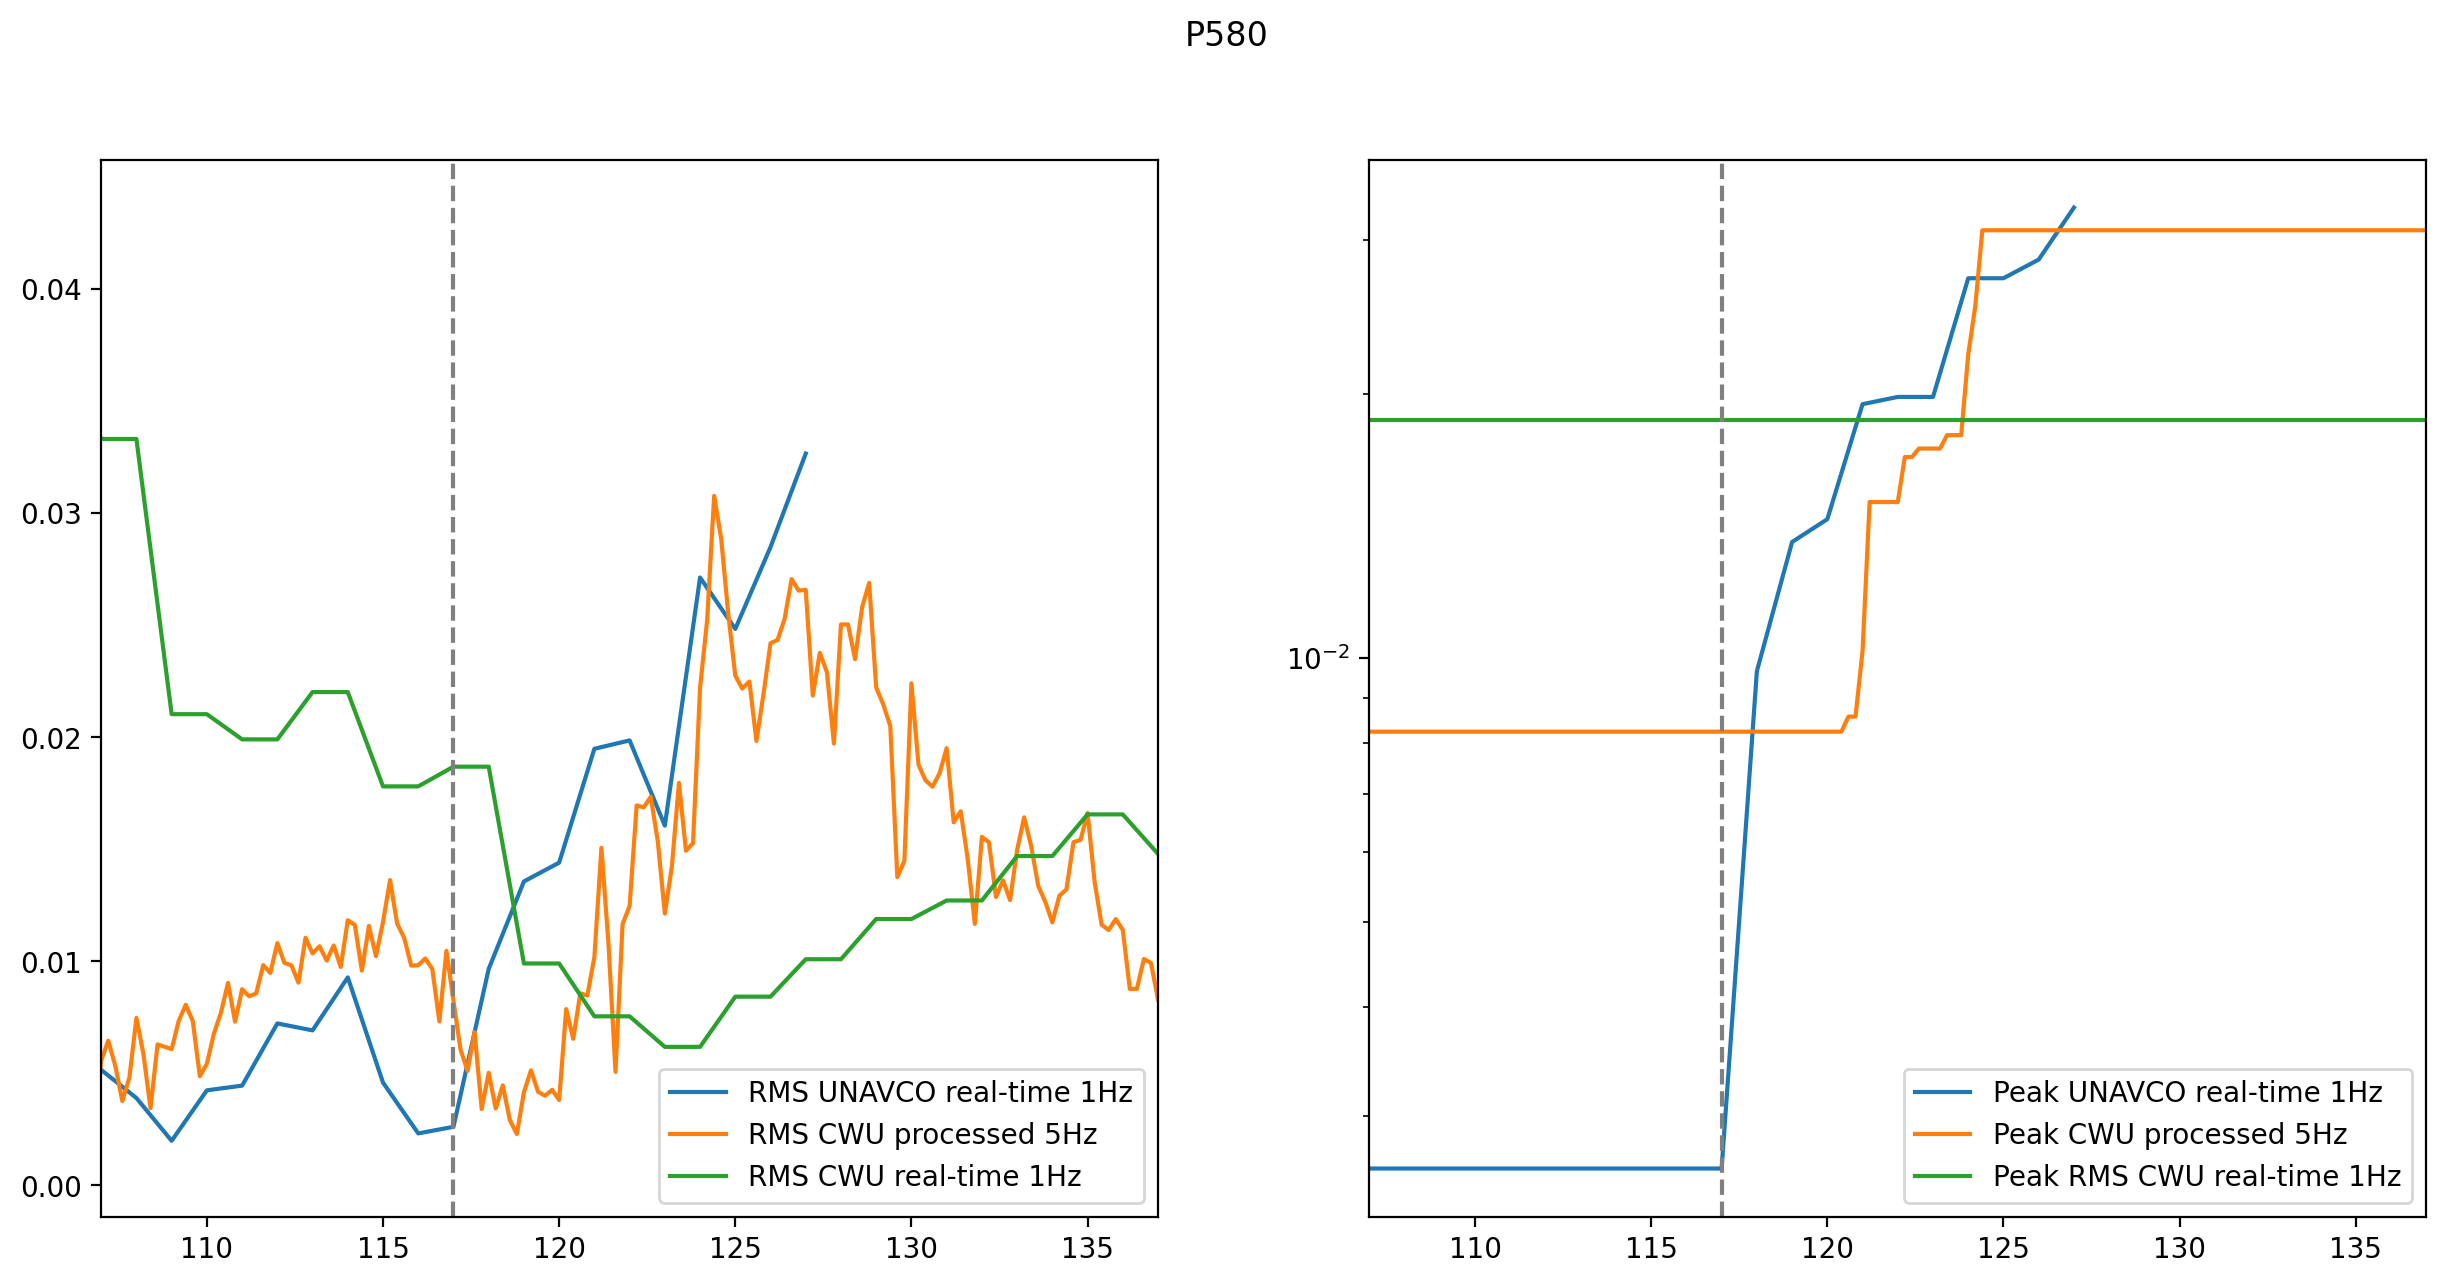

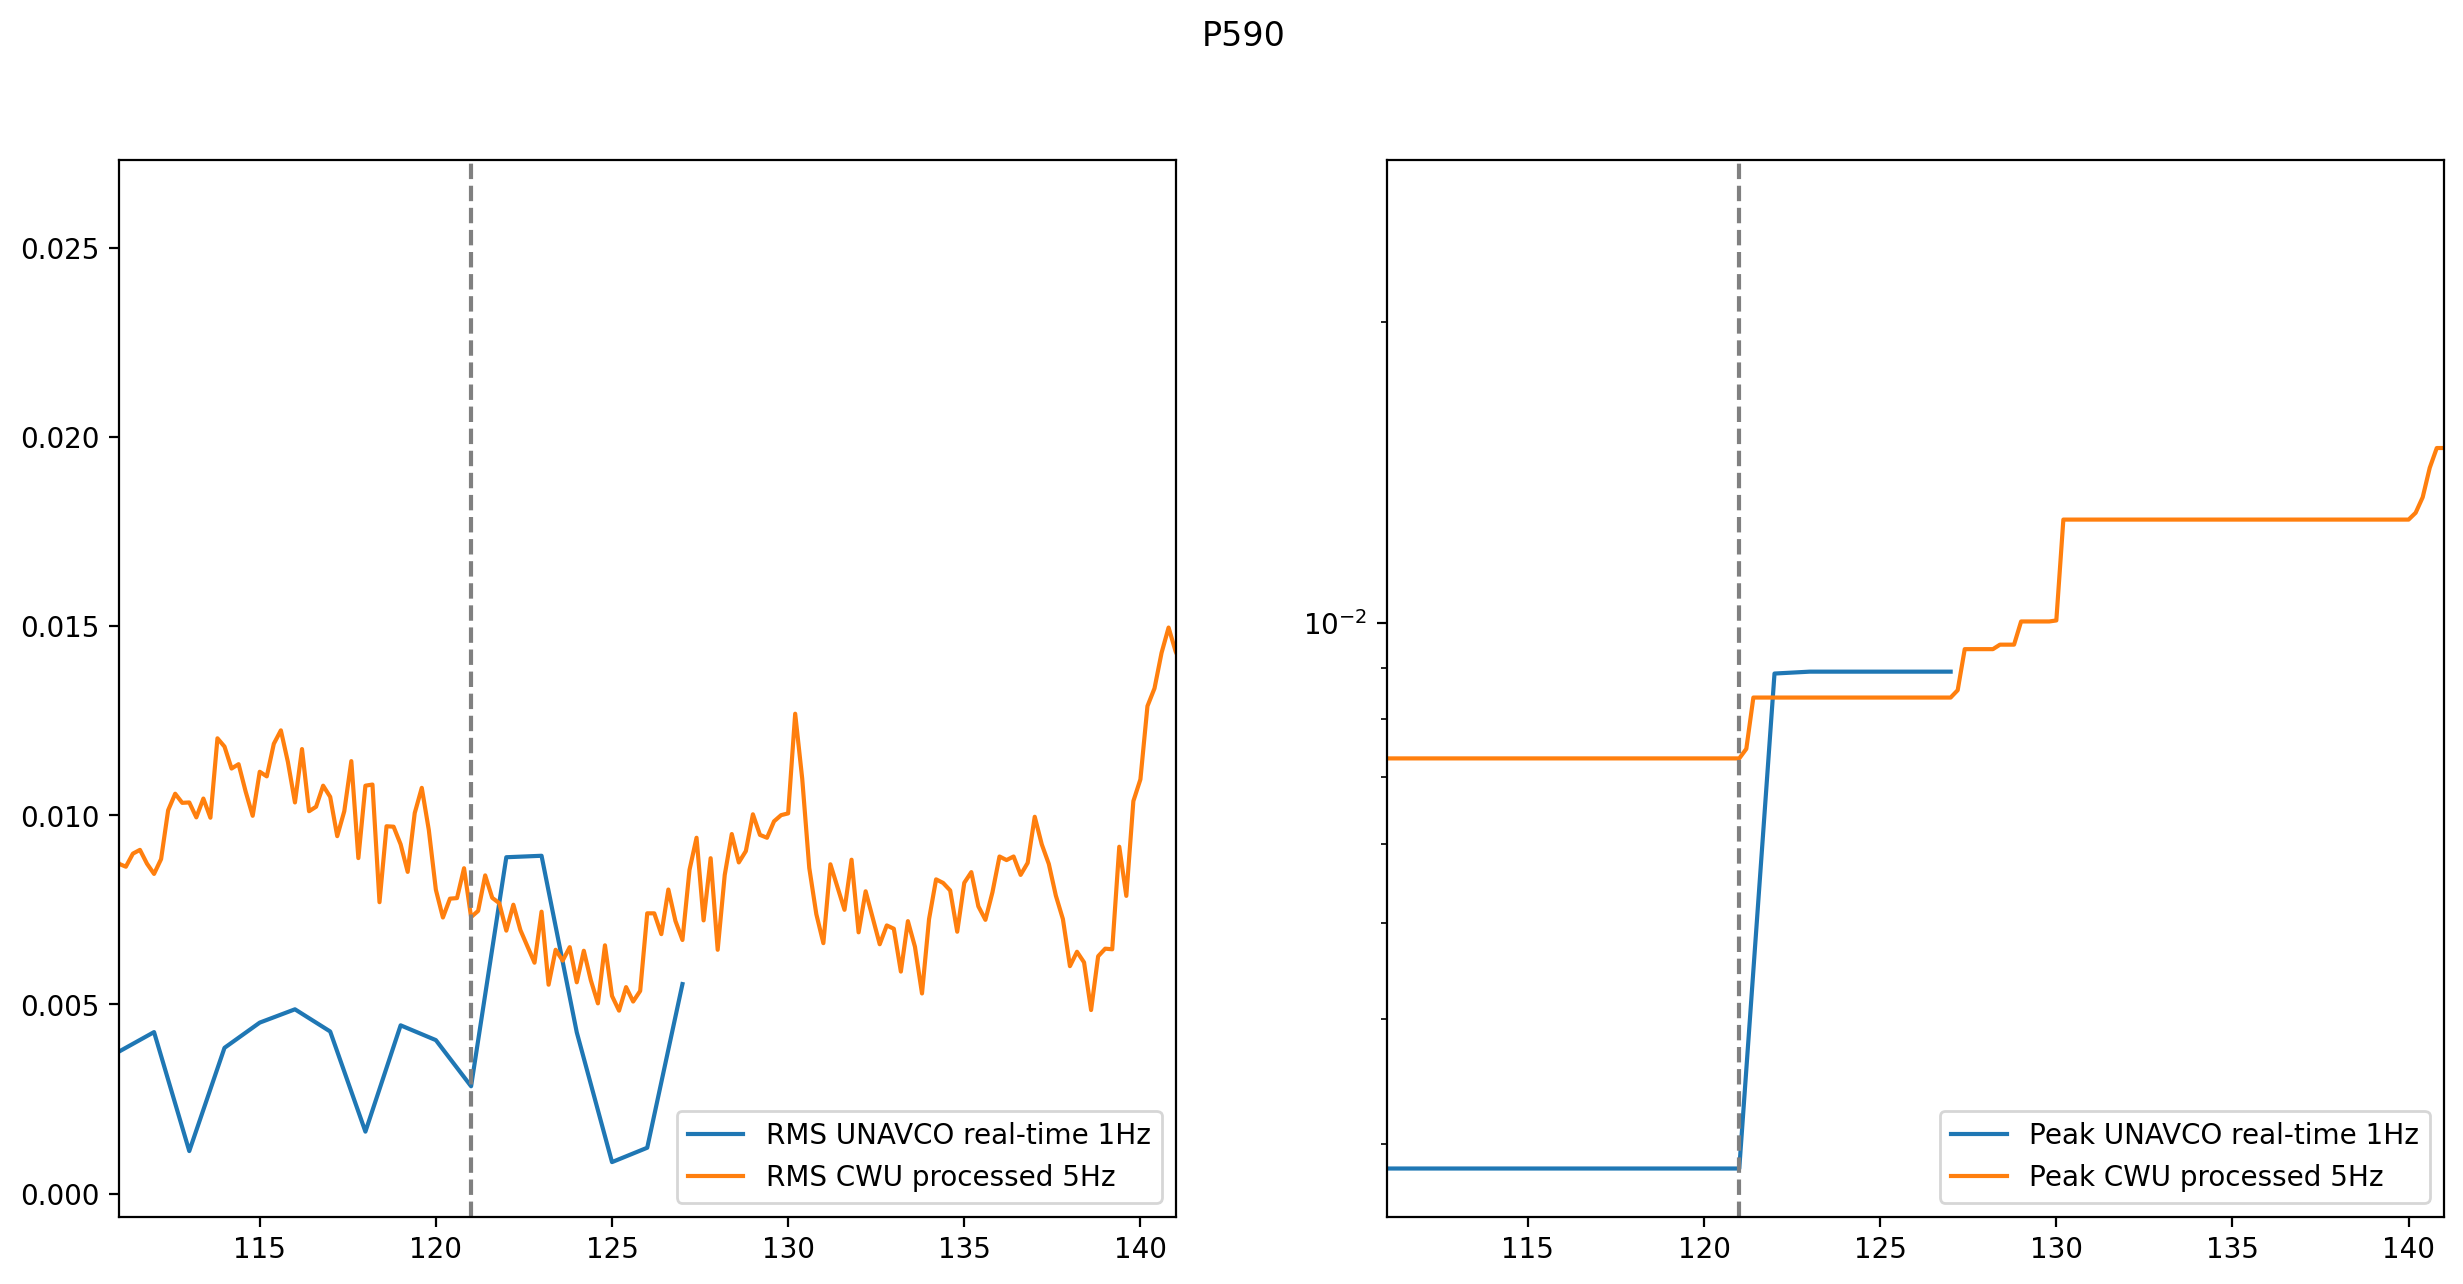

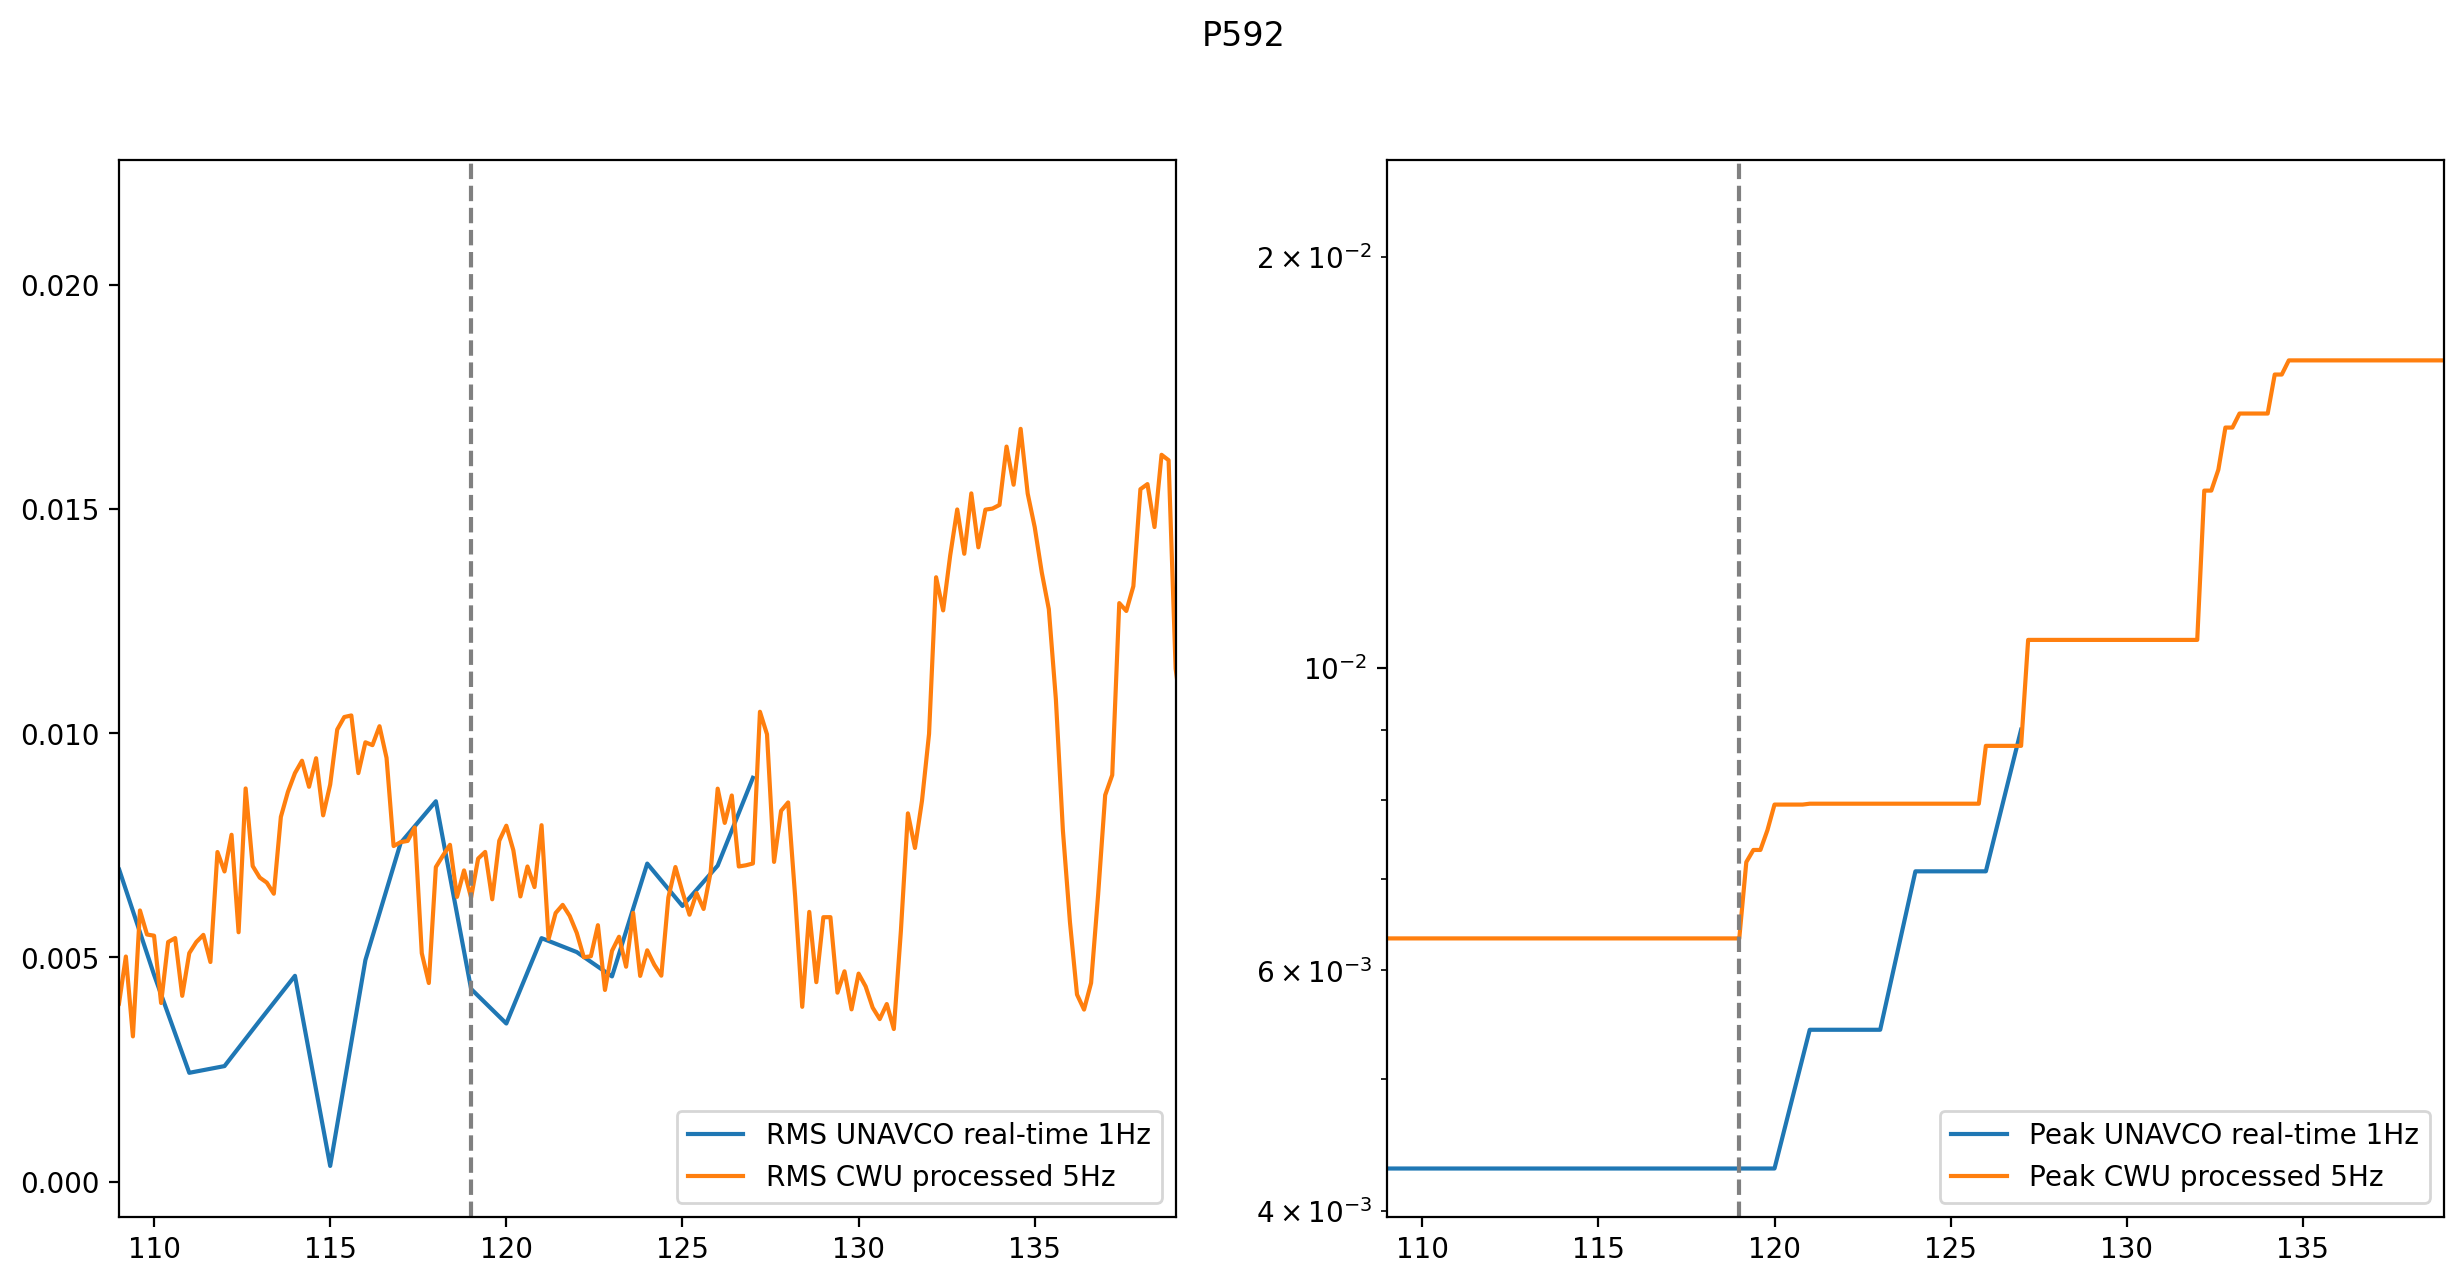

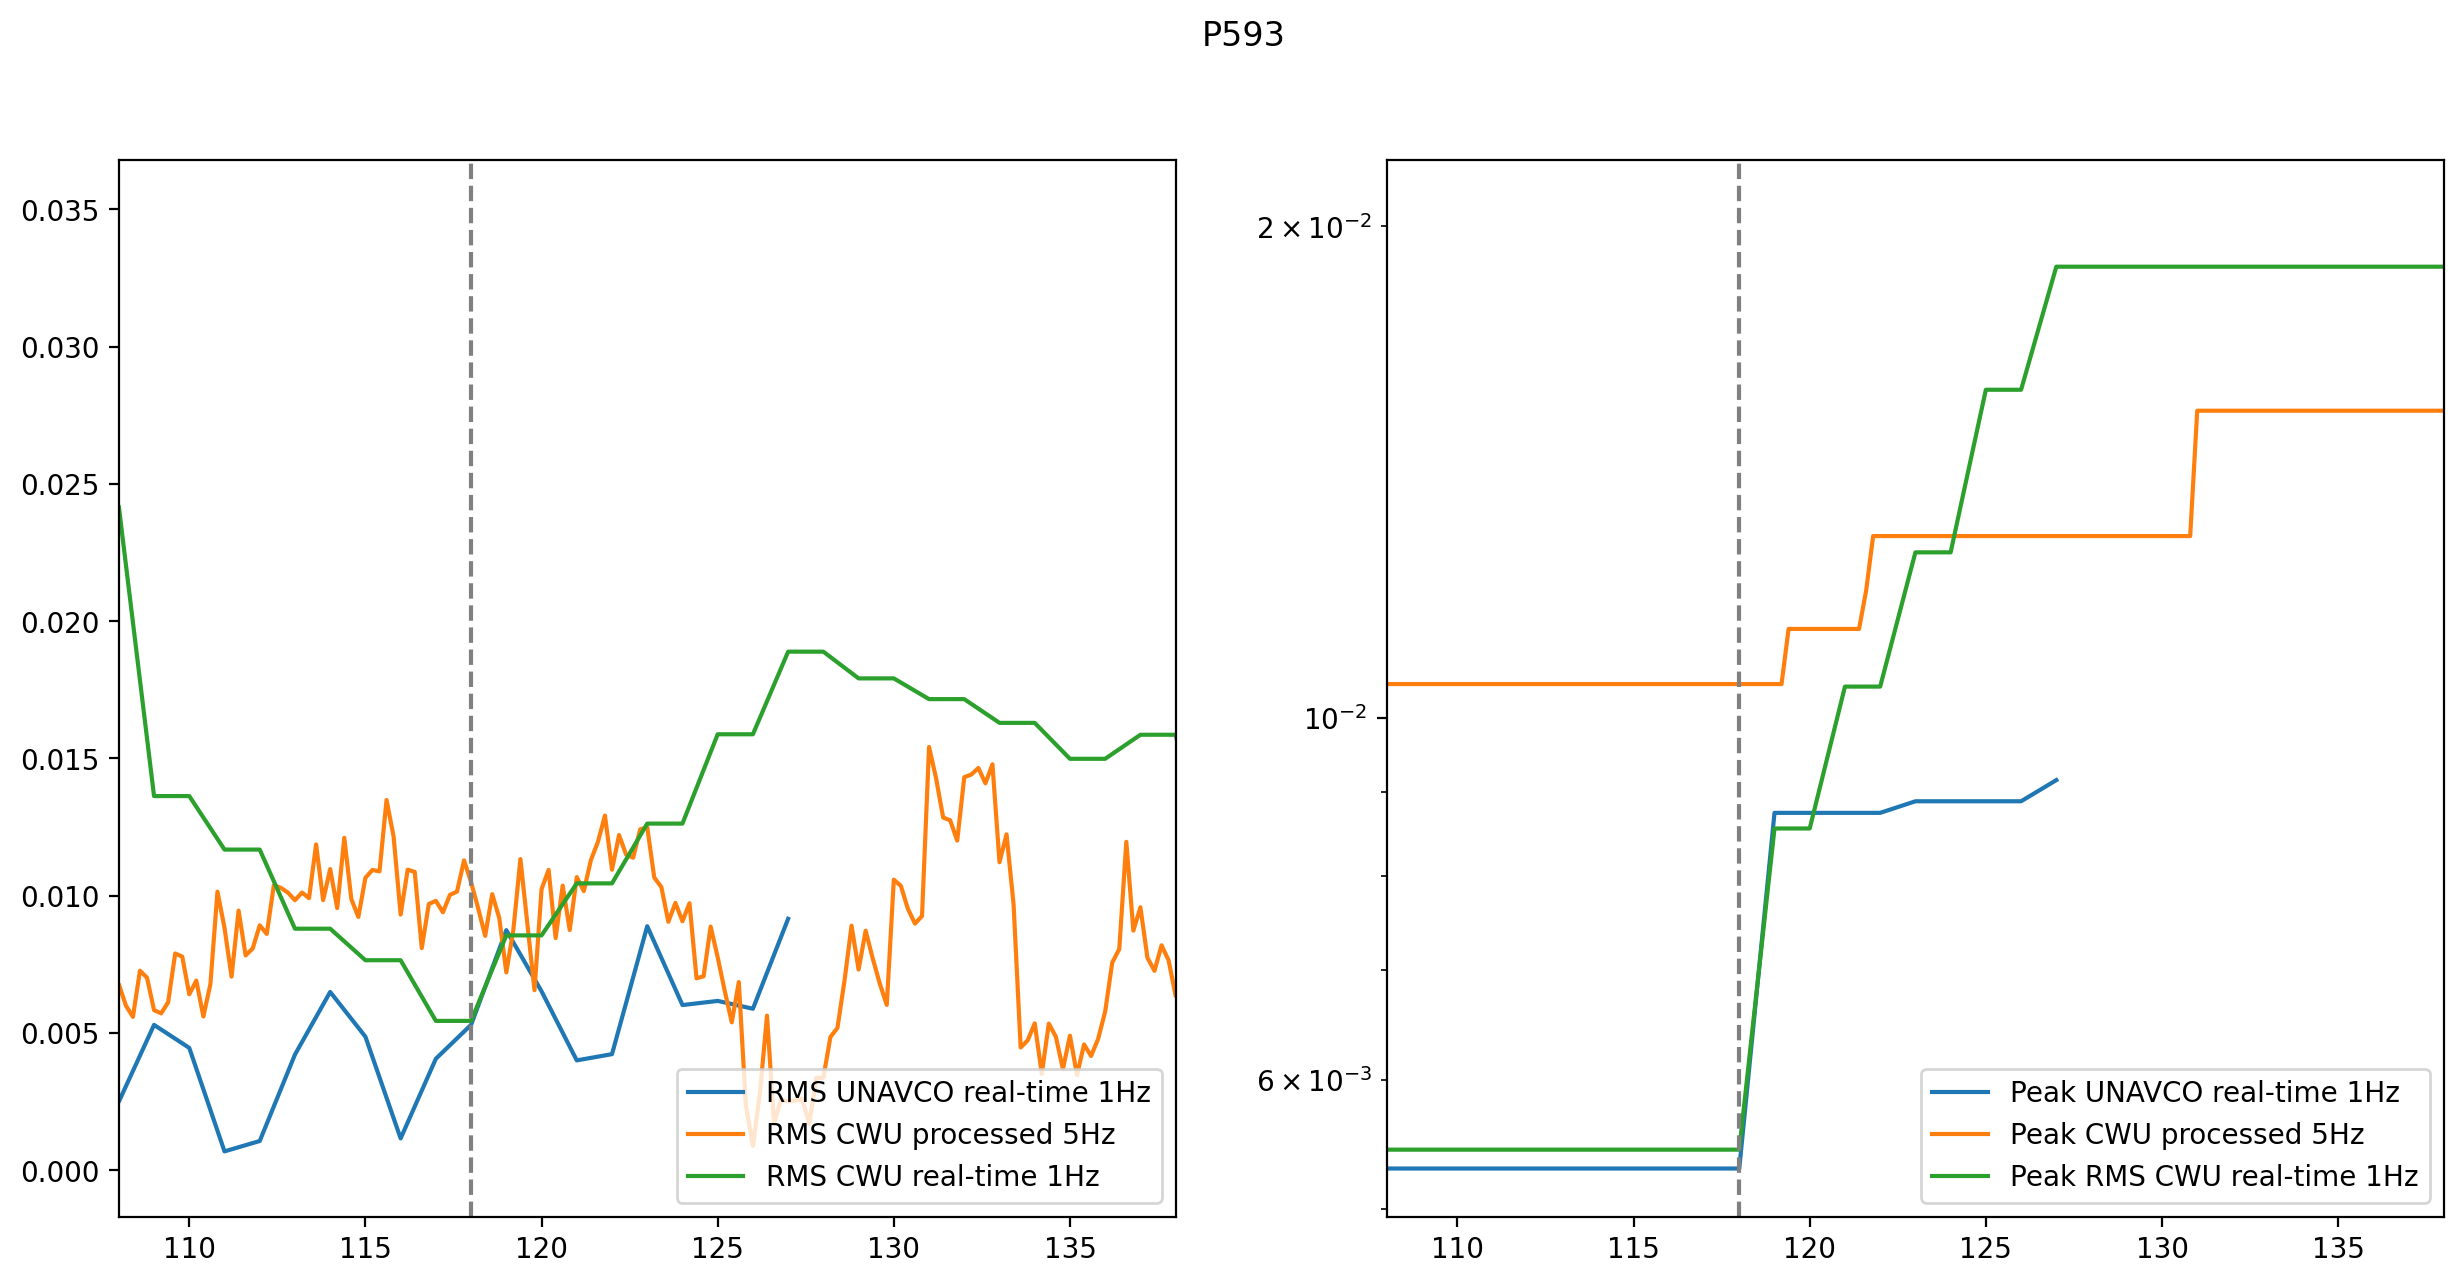

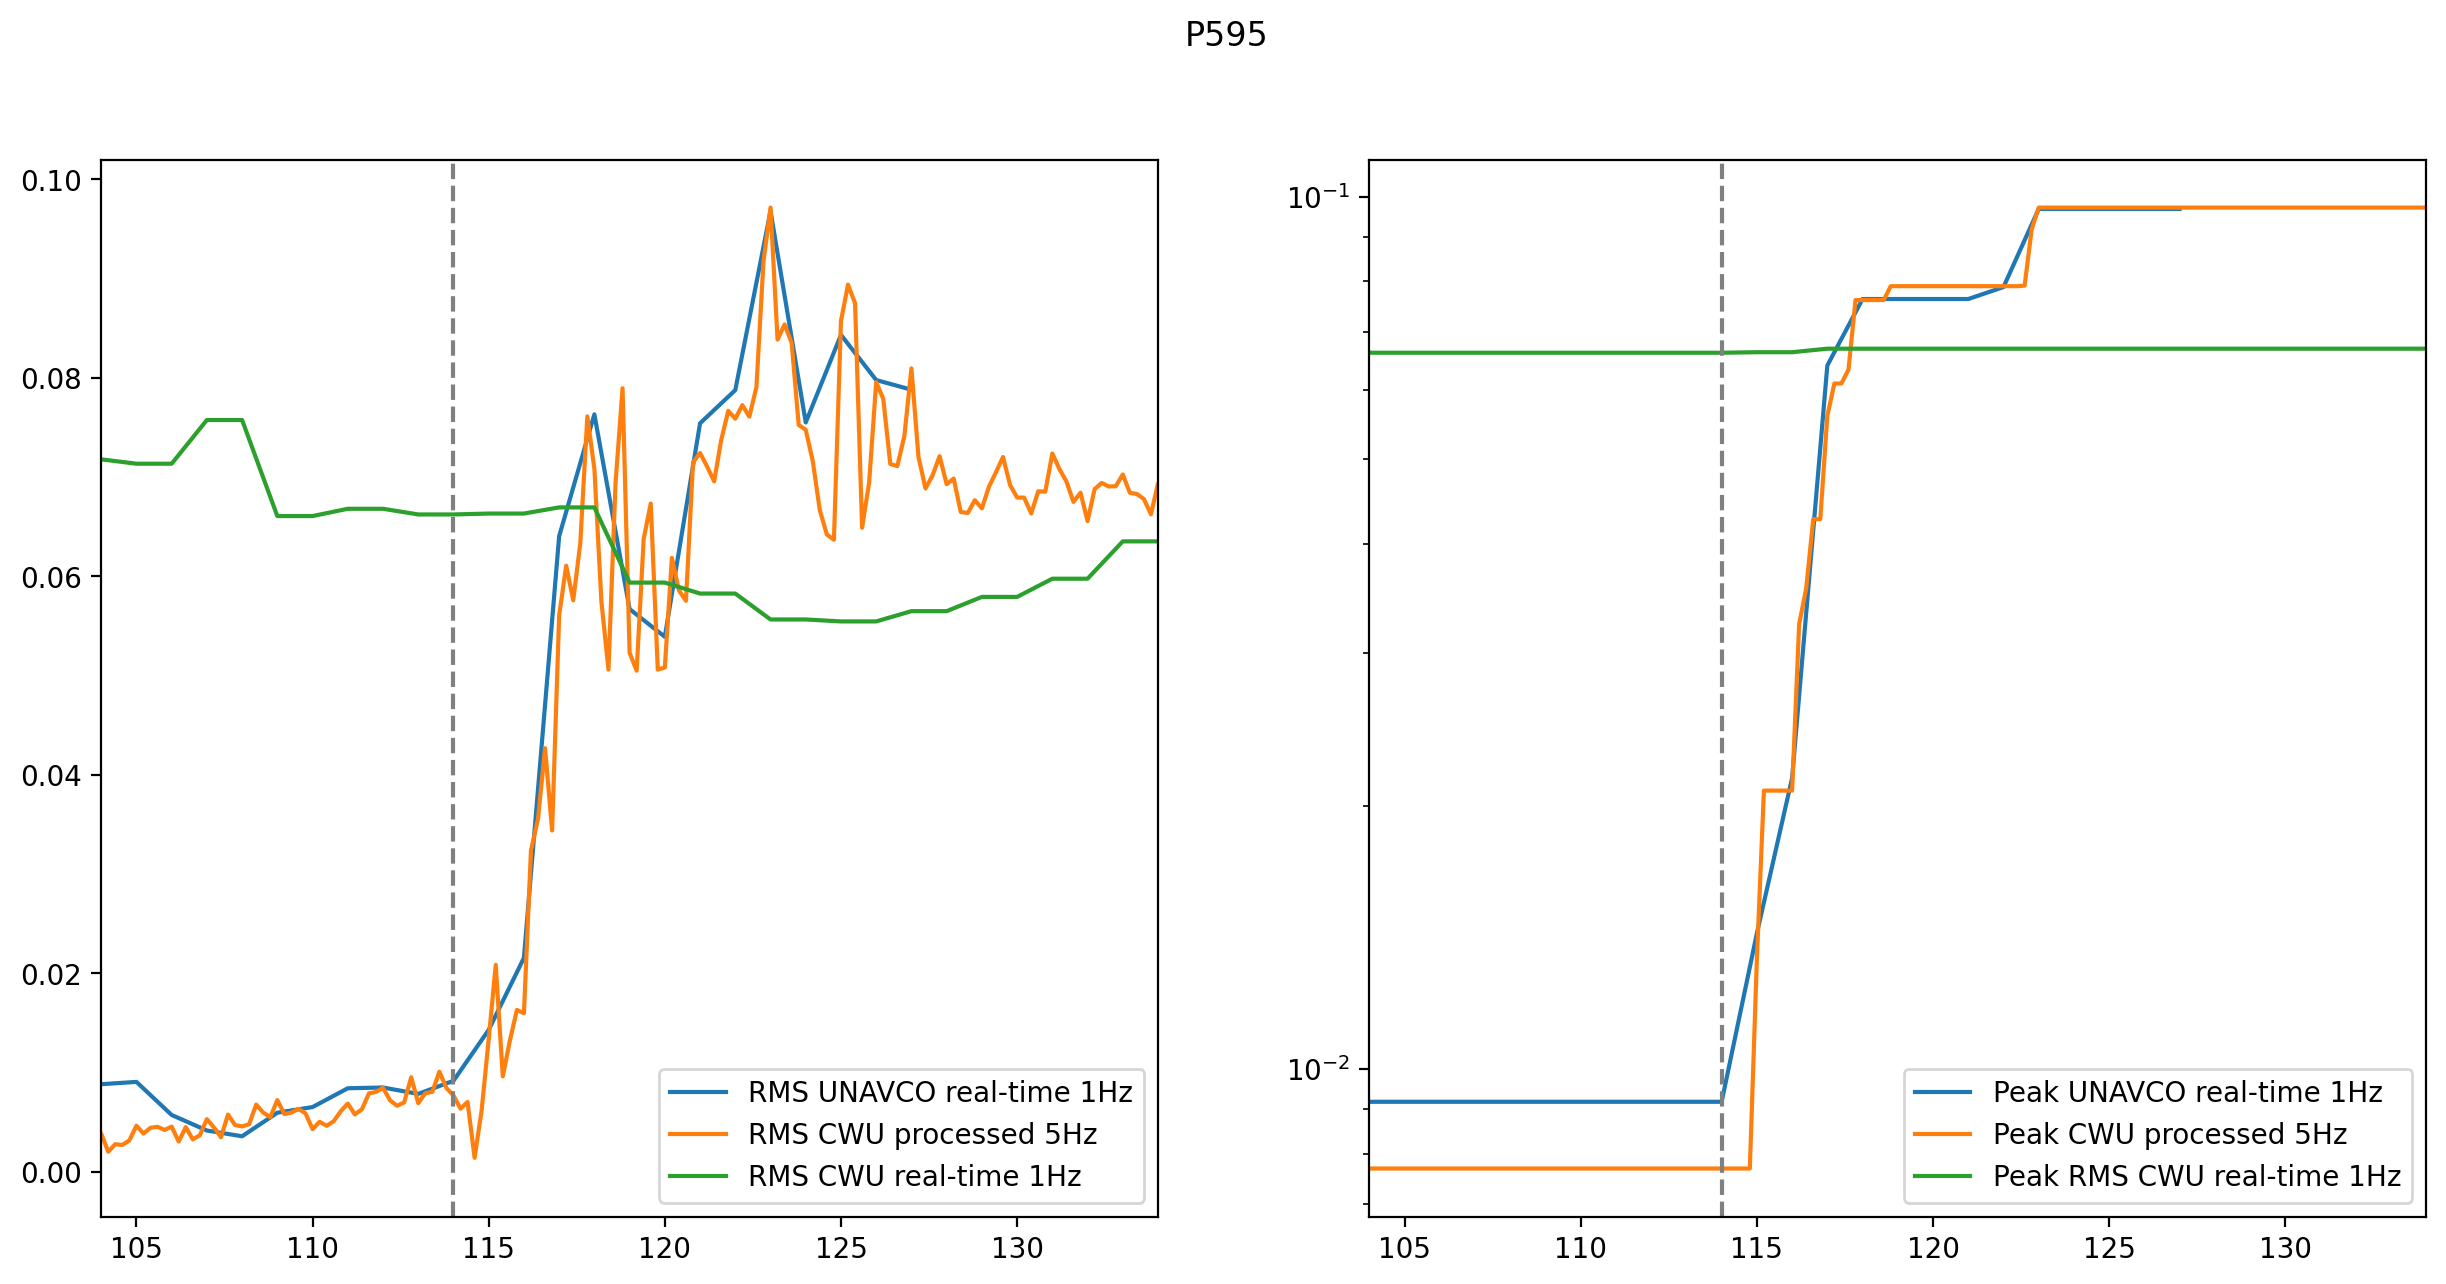

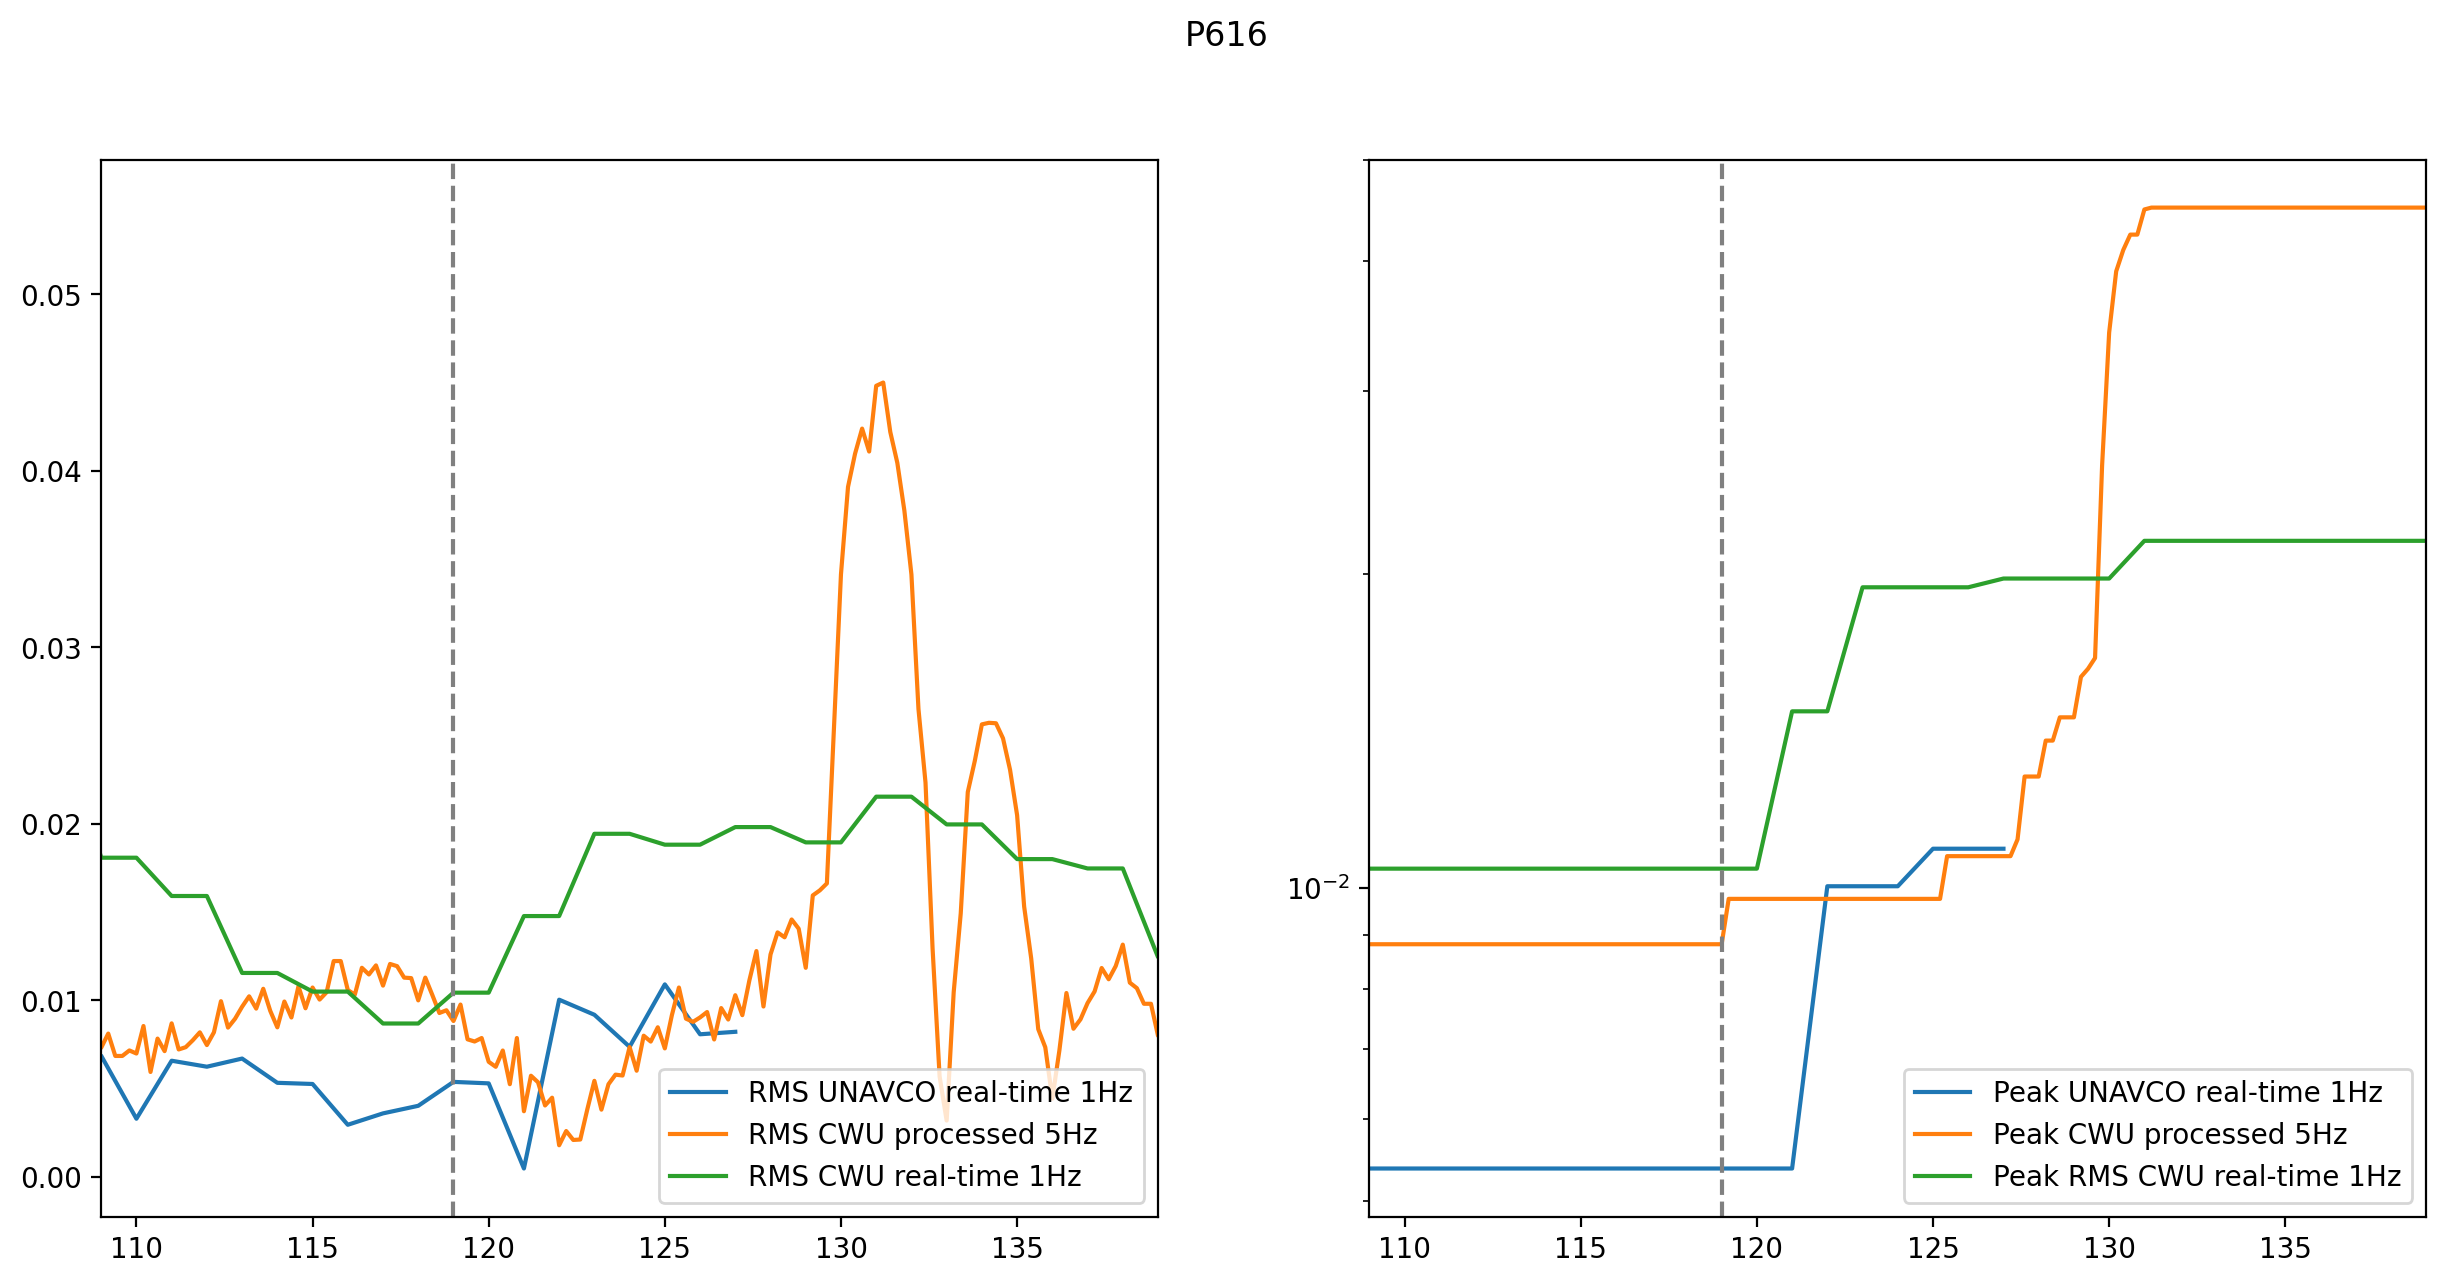

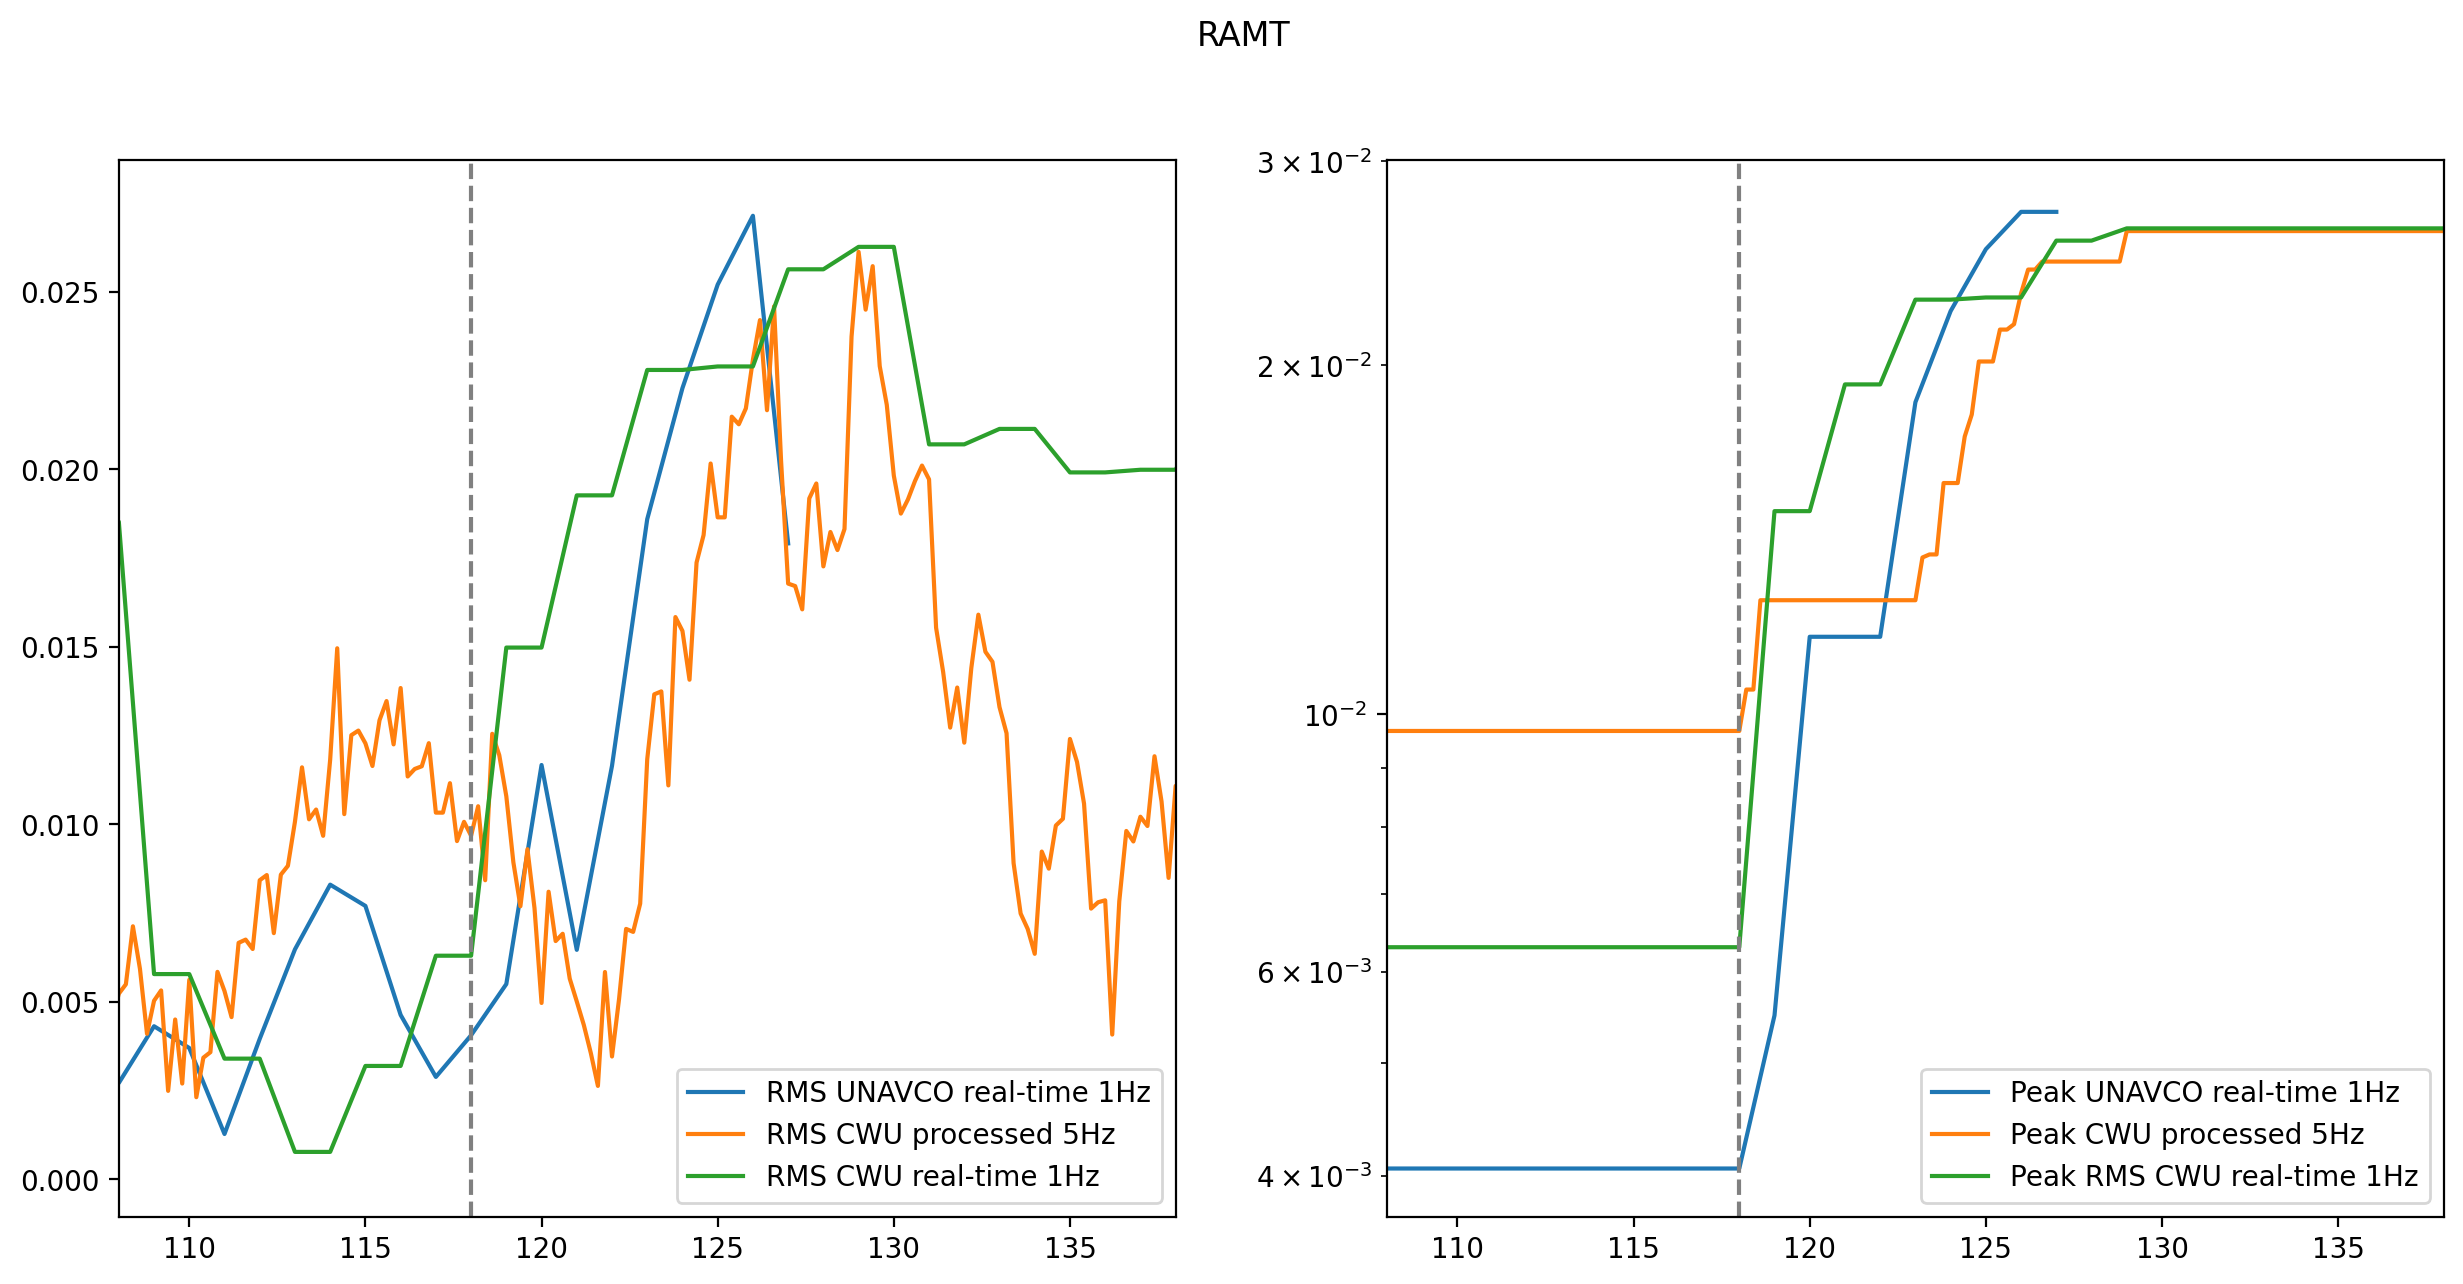

In [49]:
# M6 earthquake plots

pub_rt_n = None
pub_rt_e = None

for idx in range(len(unav_realtime_metadata)):
    
    unav_sta = unav_realtime_metadata[idx,0]
    mag = float(unav_realtime_metadata[idx,6])
    
    if unav_sta not in pub_proc_5hz_stas_M6 or mag != 6.4:
        continue
    
    pub_sta = unav_sta.lower()

    print(unav_sta, mag)

    ### UNAVCO data ###
    
    unav_p_arr_samp = int(unav_realtime_metadata[idx,5])
    p_arr_time = UTCDateTime(unav_realtime_metadata[idx,2]) + unav_p_arr_samp
    
    # Calculate RMS of UNAVCO horizontal data
    unav_rt_data_n = unav_realtime_data[idx,:128]
    unav_rt_data_e = unav_realtime_data[idx,128:256]
    
    unav_rt_times = np.arange(0,len(unav_rt_data_n),1)
    hoz_rms_unav_rt_data = np.sqrt((unav_rt_data_n**2 + unav_rt_data_e**2)/2)
    
    # Calculate the peak UNAVCO GNSS data
    peak_unav_rt = get_peak_gnss(hoz_rms_unav_rt_data, unav_p_arr_samp)
    
    ### Published CWU data ###
    
    # Calculate P arrival time in the published data
    pub_start_time = usgs_6_ot - 60
    pub_p_arr_sec = p_arr_time - pub_start_time

    # Calculate RMS of published horizontal data
    pub_proc_5hz_n = read(proc_5hz_M6_path + pub_sta + '.LYN.mseed')
    pub_proc_5hz_e = read(proc_5hz_M6_path + pub_sta + '.LYE.mseed')
    pub_proc_5hz_times = pub_proc_5hz_n[0].times()
    hoz_rms_pub_proc_5hz_data = np.sqrt((pub_proc_5hz_n[0].data**2 + pub_proc_5hz_e[0].data**2)/2)

    # Calculate P arrival sample in published data
    pub_p_arr_samp_proc_5hz = int(pub_p_arr_sec * pub_proc_5hz_n[0].stats.sampling_rate)

    # Calculate the peak published GNSS data
    peak_pub_proc_5hz = get_peak_gnss(hoz_rms_pub_proc_5hz_data, pub_p_arr_samp_proc_5hz)
    
    # Shift the published data to match the UNAVCO P-wave arrival time
    if pub_p_arr_sec >= unav_p_arr_samp: # Shift the published GNSS backward
        shift_amount = pub_p_arr_sec - unav_p_arr_samp
        pub_proc_5hz_times = pub_proc_5hz_times - shift_amount
        pub_p_arr_sec = pub_p_arr_sec - shift_amount
    else: # Shift the published GNSS forward
        shift_amount = unav_p_arr_samp - pub_p_arr_sec
        pub_proc_5hz_times = pub_proc_5hz_times + shift_amount
        pub_p_arr_sec = pub_p_arr_sec + shift_amount
    
    try:
        pub_rt_n = read(rt_1hz_M6_path + pub_sta + '.LYN.mseed')
        pub_rt_e = read(rt_1hz_M6_path + pub_sta + '.LYE.mseed')
    except:
        print('No published RT data for station ' + str(pub_sta))
    
    if pub_rt_n != None:
        pub_rt_times = pub_rt_n[0].times()
        hoz_rms_pub_rt_data = np.sqrt((pub_rt_n[0].data**2 + pub_rt_e[0].data**2)/2)

        # Calculate P arrival sample in published data
        pub_p_arr_samp_rt = int(pub_p_arr_sec * pub_rt_n[0].stats.sampling_rate)

        # Calculate the peak published GNSS data
        peak_pub_rt = get_peak_gnss(hoz_rms_pub_rt_data, pub_p_arr_samp_rt)

        # Shift the published data to match the UNAVCO P-wave arrival time
        if pub_p_arr_sec >= unav_p_arr_samp: # Shift the published GNSS backward
            shift_amount = pub_p_arr_sec - unav_p_arr_samp
            pub_rt_times = pub_rt_times - shift_amount
            pub_p_arr_sec = pub_p_arr_sec - shift_amount
        else: # Shift the published GNSS forward
            shift_amount = unav_p_arr_samp - pub_p_arr_sec
            pub_rt_times = pub_rt_times + shift_amount
            pub_p_arr_sec = pub_p_arr_sec + shift_amount

    xlim_low = pub_p_arr_sec - 10
    xlim_high = pub_p_arr_sec + 20
    
    plt.subplots(figsize = (15,7), dpi = 200)
    plt.suptitle(unav_sta)
    
    plt.subplot(121)
    plt.plot(unav_rt_times, hoz_rms_unav_rt_data, label = 'RMS UNAVCO real-time 1Hz')
    plt.plot(pub_proc_5hz_times, hoz_rms_pub_proc_5hz_data, label = 'RMS CWU processed 5Hz')
    if pub_rt_n != None:
        plt.plot(pub_rt_times, hoz_rms_pub_rt_data, label = 'RMS CWU real-time 1Hz')
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.legend(loc = 'lower right')
    
    plt.subplot(122)
    plt.plot(unav_rt_times, peak_unav_rt, label = 'Peak UNAVCO real-time 1Hz')
    plt.plot(pub_proc_5hz_times, peak_pub_proc_5hz, label = 'Peak CWU processed 5Hz')
    if pub_rt_n != None:
        plt.plot(pub_rt_times, peak_pub_rt, label = 'Peak RMS CWU real-time 1Hz')
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.semilogy()
    plt.legend(loc = 'lower right')
    
    # plt.show()
    
    pub_rt_n = None
    pub_rt_e = None
    
#     # Plot the actual GNSS data
    
#     xlim_low = pub_p_arr_sec - 5
#     xlim_high = pub_p_arr_sec + 10 
    
#     plt.subplots(figsize = (20,6))
#     plt.suptitle('M' + str(mag) + ' GNSS data (m), station ' + str(unav_sta))
    
#     plt.subplot(131)
#     # plt.plot(unav_rt_times_n, unav_rt_data_n, label = 'UNAVCO real-time 1Hz')
#     plt.plot(pub_proc_5hz_times_n, pub_proc_5hz_data_n, label = 'CWU processed 5Hz')
#     plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
#     plt.xlim(xlim_low, xlim_high)
#     plt.xlabel('Time (s)')
#     plt.ylabel('N-S displacement (m)')
#     plt.legend(loc = 'lower right')
    
#     plt.subplot(132)
#     # plt.plot(unav_rt_times_e, unav_rt_data_e, label = 'UNAVCO real-time 1Hz')
#     plt.plot(pub_proc_5hz_times_e, pub_proc_5hz_data_e, label = 'CWU processed 5Hz')
#     plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
#     plt.xlim(xlim_low, xlim_high)
#     plt.xlabel('Time (s)')
#     plt.ylabel('E-W displacement (m)')
#     plt.legend(loc = 'lower right')
    
#     plt.subplot(133)
#     # plt.plot(unav_rt_times_z, unav_rt_data_z, label = 'UNAVCO real-time 1Hz')
#     plt.plot(pub_proc_5hz_times_z, pub_proc_5hz_data_z, label = 'CWU processed 5Hz')
#     plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
#     plt.xlim(xlim_low, xlim_high)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Vertical displacement (m)')
#     plt.legend(loc = 'lower right')
    
#     plt.show()
    
    
#     # Plot the peak GNSS data
    
#     plt.subplots(figsize = (20,6))
#     plt.suptitle('M' + str(mag) + ' peak GNSS data (m), station ' + str(unav_sta))
    
#     plt.subplot(131)
#     # plt.plot(unav_rt_times_n, peak_unav_rt_n, label = 'UNAVCO real-time 1Hz')
#     plt.plot(pub_proc_5hz_times_n, peak_pub_proc_5hz_n, label = 'CWU processed 5Hz')
#     plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
#     plt.xlim(xlim_low, xlim_high)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Peak N-S displacement (m)')
#     plt.semilogy()
#     plt.legend(loc = 'lower right')

#     plt.subplot(132)
#     # plt.plot(unav_rt_times_e, peak_unav_rt_e, label = 'UNAVCO real-time 1Hz')
#     plt.plot(pub_proc_5hz_times_e, peak_pub_proc_5hz_e, label = 'CWU processed 5Hz')
#     plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
#     plt.xlim(xlim_low, xlim_high)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Peak E-W displacement (m)')
#     plt.semilogy()
#     plt.legend(loc = 'lower right')
    
#     plt.subplot(133)
#     # plt.plot(unav_rt_times_z, peak_unav_rt_z, label = 'UNAVCO real-time 1Hz')
#     plt.plot(pub_proc_5hz_times_z, peak_pub_proc_5hz_z, label = 'CWU processed 5Hz')
#     plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
#     plt.xlim(xlim_low, xlim_high)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Peak Vertical displacement (m)')
#     plt.semilogy()
#     plt.legend(loc = 'lower right')
    
#     plt.show()

CCCC 7.1
60
325
60
50
50
275


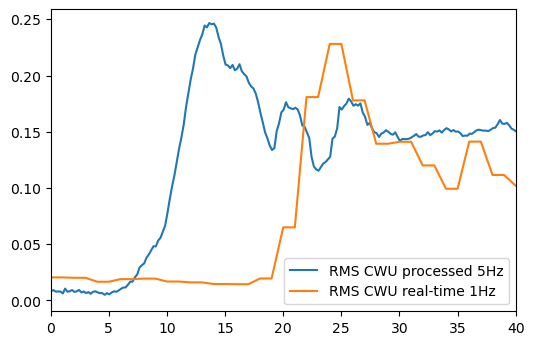

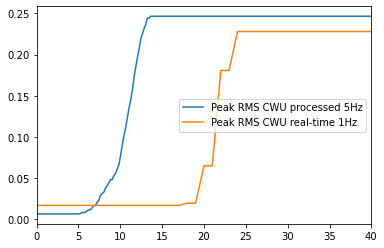

LNMT 7.1
No published RT data for station lnmt
72
385
62
335


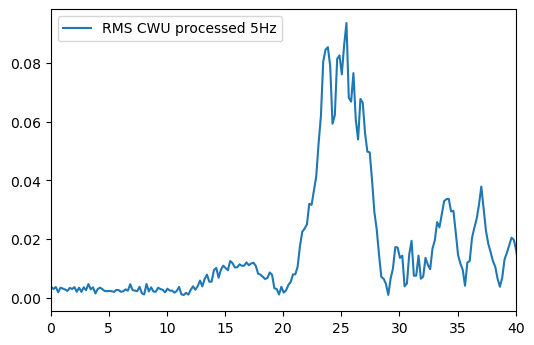

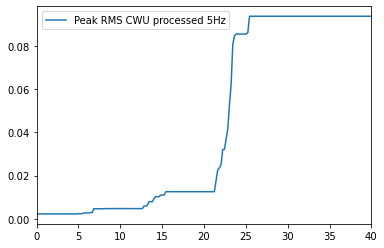

P091 7.1
No published RT data for station p091
71
380
61
330


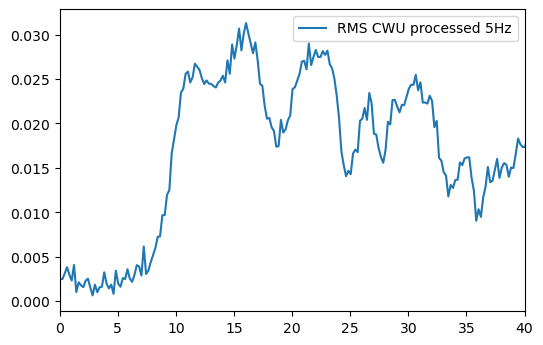

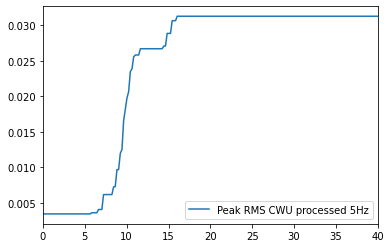

P093 7.1
No published RT data for station p093
75
400
65
350


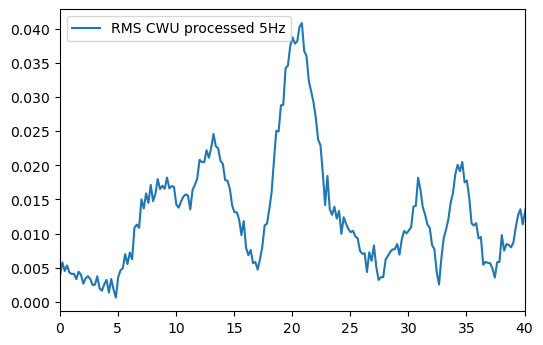

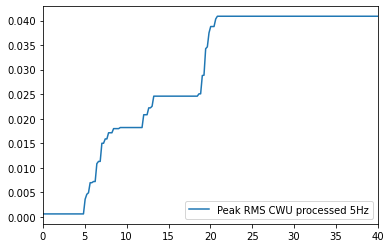

P463 7.1
64
345
64
54
54
295


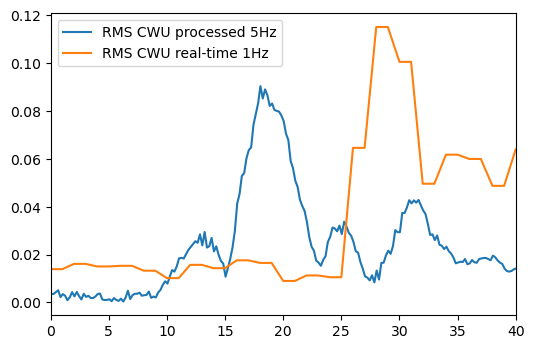

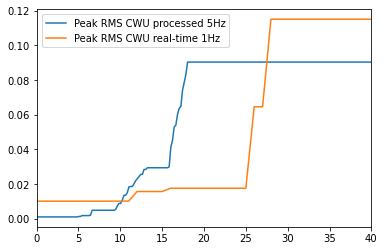

P466 7.1
69
370
69
59
59
320


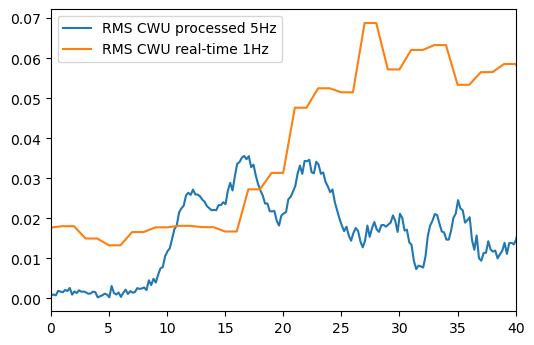

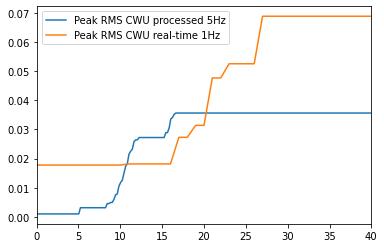

P467 7.1
No published RT data for station p467
75
400
65
350


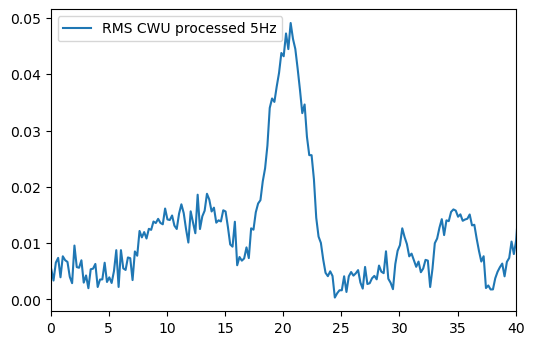

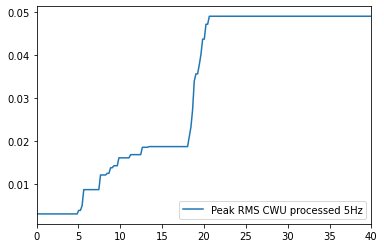

P570 7.1
No published RT data for station p570
65
350
55
300


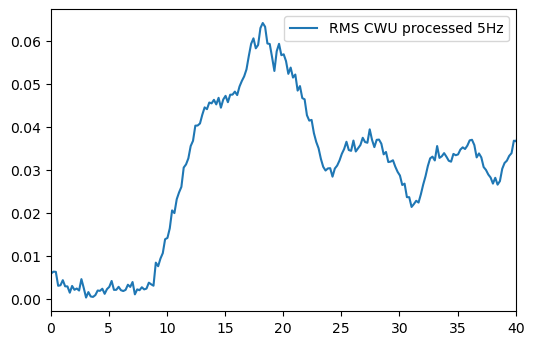

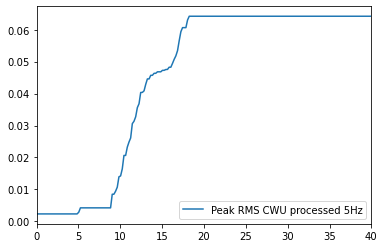

P579 7.1
No published RT data for station p579
114
375
104
325


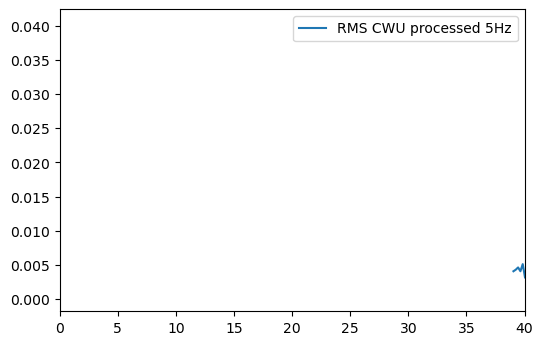

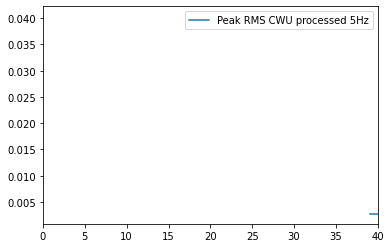

P580 7.1
63
340
63
53
53
290


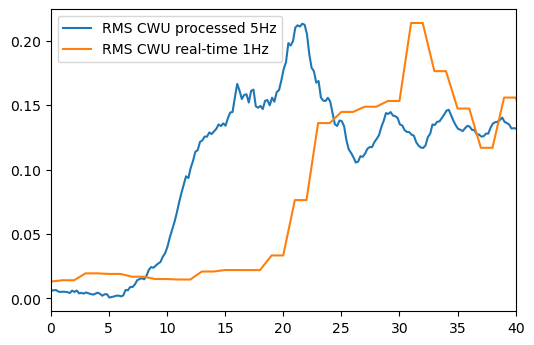

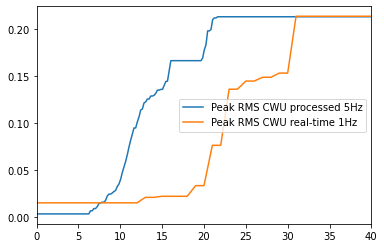

P590 7.1
No published RT data for station p590
68
365
58
315


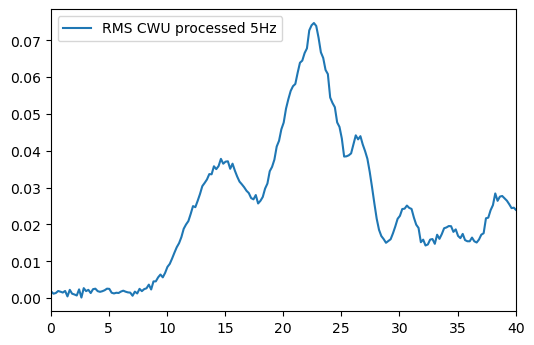

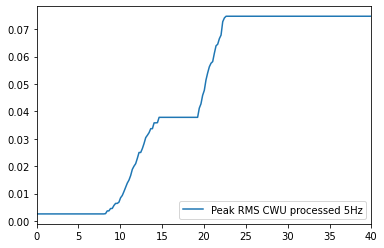

P592 7.1
No published RT data for station p592
66
355
56
305


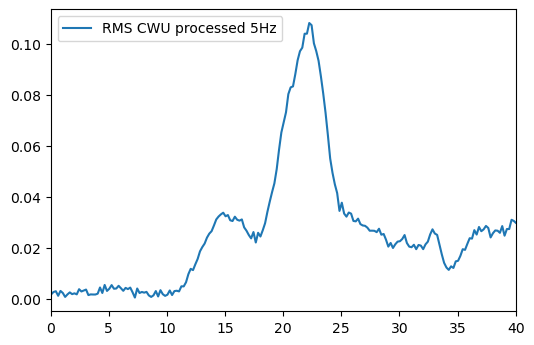

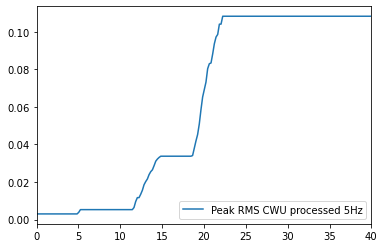

P593 7.1
64
345
64
54
54
295


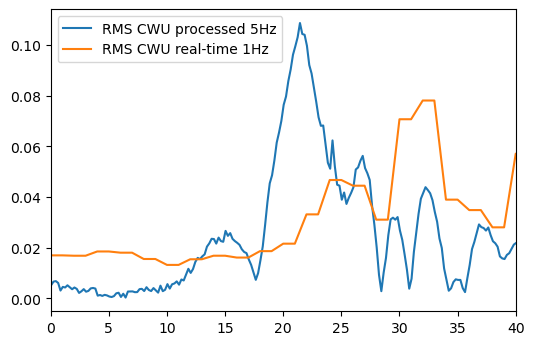

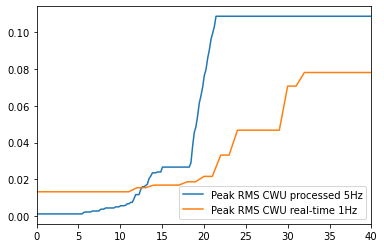

P595 7.1
59
320
59
49
49
270


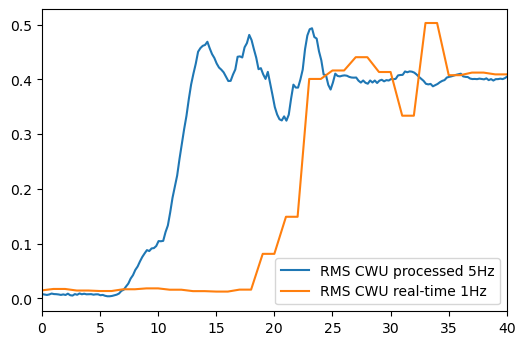

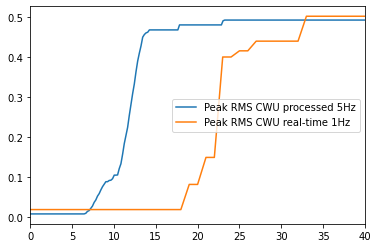

P615 7.1
No published RT data for station p615
72
385
62
335


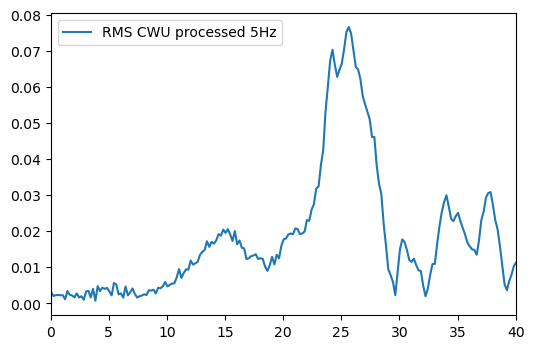

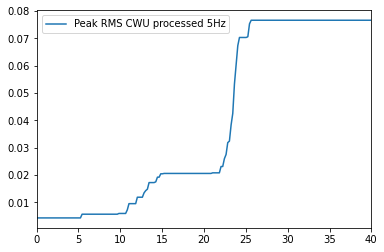

P616 7.1
63
340
63
53
53
290


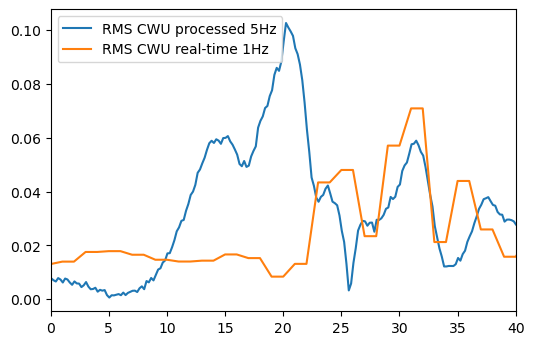

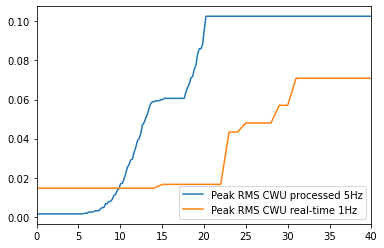

In [100]:
# M7 earthquake plots

pub_rt_n = None
pub_rt_e = None

for idx in range(len(unav_realtime_metadata)):
    
    unav_sta = unav_realtime_metadata[idx,0]
    mag = float(unav_realtime_metadata[idx,6])
    
    if unav_sta not in pub_proc_5hz_stas_M7 or mag != 7.1:
        continue
    
    pub_sta = unav_sta.lower()

    print(unav_sta, mag)

    ### UNAVCO data ###
    
    unav_samp_rate = 1
    unav_p_arr_samp = int(unav_realtime_metadata[idx,5])
    p_arr_time = UTCDateTime(unav_realtime_metadata[idx,2]) + unav_p_arr_samp
    
    # Calculate RMS of UNAVCO horizontal data
    unav_rt_data_n = unav_realtime_data[idx,:128]
    unav_rt_data_e = unav_realtime_data[idx,128:256]
    
    unav_rt_times = np.arange(0,len(unav_rt_data_n),1)
    hoz_rms_unav_rt_data = np.sqrt((unav_rt_data_n**2 + unav_rt_data_e**2)/2)
    
    # Calculate the peak UNAVCO GNSS data
    peak_unav_rt = get_peak_gnss(hoz_rms_unav_rt_data, unav_p_arr_samp)
    
    ### Published CWU data ###
    
    # Calculate P arrival time in the published data
    pub_start_time = usgs_7_ot - 60
    pub_p_arr_sec = p_arr_time - pub_start_time

    # Calculate RMS of published horizontal data
    pub_proc_5hz_n = read(proc_5hz_M7_path + pub_sta + '.LYN.mseed')
    pub_proc_5hz_e = read(proc_5hz_M7_path + pub_sta + '.LYE.mseed')
    pub_proc_5hz_times = pub_proc_5hz_n[0].times()
    hoz_rms_pub_proc_5hz_data = np.sqrt((pub_proc_5hz_n[0].data**2 + pub_proc_5hz_e[0].data**2)/2)

    # Calculate P arrival sample in published data
    pub_proc_5hz_samp_rate = pub_proc_5hz_n[0].stats.sampling_rate
    pub_p_arr_samp_proc_5hz = int(pub_p_arr_sec * pub_proc_5hz_samp_rate)

    # Calculate the peak published GNSS data
    peak_pub_proc_5hz = get_peak_gnss(hoz_rms_pub_proc_5hz_data, pub_p_arr_samp_proc_5hz)
    
    # Shift the published data to match the UNAVCO P-wave arrival time
    if pub_p_arr_sec >= unav_p_arr_samp: # Shift the published GNSS backward
        shift_amount = pub_p_arr_sec - unav_p_arr_samp
        pub_proc_5hz_times = pub_proc_5hz_times - shift_amount
        pub_p_arr_sec = pub_p_arr_sec - shift_amount
    else: # Shift the published GNSS forward
        shift_amount = unav_p_arr_samp - pub_p_arr_sec
        pub_proc_5hz_times = pub_proc_5hz_times + shift_amount
        pub_p_arr_sec = pub_p_arr_sec + shift_amount
    
    try:
        pub_rt_n = read(rt_1hz_M7_path + pub_sta + '.LYN.mseed')
        pub_rt_e = read(rt_1hz_M7_path + pub_sta + '.LYE.mseed')
    except:
        print('No published RT data for station ' + str(pub_sta))
    
    if pub_rt_n != None:
        pub_rt_times = pub_rt_n[0].times()
        hoz_rms_pub_rt_data = np.sqrt((pub_rt_n[0].data**2 + pub_rt_e[0].data**2)/2)

        # Calculate P arrival sample in published data
        pub_rt_samp_rate = pub_rt_n[0].stats.sampling_rate
        pub_p_arr_samp_rt = int(pub_p_arr_sec * pub_rt_samp_rate)

        # Calculate the peak published GNSS data
        peak_pub_rt = get_peak_gnss(hoz_rms_pub_rt_data, pub_p_arr_samp_rt)

        # Shift the published data to match the UNAVCO P-wave arrival time
        if pub_p_arr_sec >= unav_p_arr_samp: # Shift the published GNSS backward
            shift_amount = pub_p_arr_sec - unav_p_arr_samp
            pub_rt_times = pub_rt_times - shift_amount
            # pub_p_arr_sec = pub_p_arr_sec - shift_amount
        else: # Shift the published GNSS forward
            shift_amount = unav_p_arr_samp - pub_p_arr_sec
            pub_rt_times = pub_rt_times + shift_amount
            # pub_p_arr_sec = pub_p_arr_sec + shift_amount

    xlim_low = pub_p_arr_sec - 10
    xlim_high = pub_p_arr_sec + 30
    
#     plt.subplots(figsize = (15,7), dpi = 200)
#     plt.suptitle(unav_sta)
    
#     plt.subplot(121)
#     plt.plot(unav_rt_times, hoz_rms_unav_rt_data, label = 'RMS UNAVCO real-time 1Hz')
#     plt.plot(pub_proc_5hz_times, hoz_rms_pub_proc_5hz_data, label = 'RMS CWU processed 5Hz')
#     if pub_rt_n != None:
#         plt.plot(pub_rt_times, hoz_rms_pub_rt_data, label = 'RMS CWU real-time 1Hz')
#     plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
#     plt.xlim(xlim_low, xlim_high)
#     plt.legend(loc = 'lower right')
    
#     plt.subplot(122)
#     plt.plot(unav_rt_times, peak_unav_rt, label = 'Peak UNAVCO real-time 1Hz')
#     plt.plot(pub_proc_5hz_times, peak_pub_proc_5hz, label = 'Peak CWU processed 5Hz')
#     if pub_rt_n != None:
#         plt.plot(pub_rt_times, peak_pub_rt, label = 'Peak RMS CWU real-time 1Hz')
#     plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
#     plt.xlim(xlim_low, xlim_high)
#     plt.semilogy()
#     plt.legend(loc = 'lower right')
    
    # plt.show()
    
    # print(pub_p_arr_sec)
    # print(pub_proc_5hz_times)

    tol = 0.1
    unav_current_p_idx = np.where(unav_rt_times == pub_p_arr_sec)[0][0]
    print(unav_current_p_idx)
    pub_proc_5hz_current_p_idx = np.where(np.abs(pub_proc_5hz_times - pub_p_arr_sec) < tol)[0][0]
    print(pub_proc_5hz_current_p_idx)
    if pub_rt_n != None:
        pub_rt_current_p_idx = np.where(np.abs(pub_rt_times - pub_p_arr_sec) < tol)[0][0]
        print(pub_rt_current_p_idx)
    goal_secs_before_p = 10
    unav_new_start_idx = int(unav_current_p_idx - goal_secs_before_p * unav_samp_rate)
    pub_proc_5hz_new_start_idx = int(pub_proc_5hz_current_p_idx - goal_secs_before_p * pub_proc_5hz_samp_rate)
    if pub_rt_n != None:
        pub_rt_new_start_idx = int(pub_rt_current_p_idx - goal_secs_before_p * pub_rt_samp_rate)
        print(pub_rt_new_start_idx)
    print(unav_new_start_idx)
    print(pub_proc_5hz_new_start_idx)
    
    cut_unav = hoz_rms_unav_rt_data[unav_new_start_idx:].shape[0]
    cut_5hz = hoz_rms_pub_proc_5hz_data[pub_proc_5hz_new_start_idx:].shape[0]
    cut_pubrt = hoz_rms_pub_rt_data[pub_rt_new_start_idx:].shape[0]
    
    plt.figure(dpi = 100)
    # plt.plot(unav_rt_times[:cut_unav], hoz_rms_unav_rt_data[unav_new_start_idx:], label = 'RMS UNAVCO real-time 1Hz')
    plt.plot(pub_proc_5hz_times[:cut_5hz], hoz_rms_pub_proc_5hz_data[pub_proc_5hz_new_start_idx:], label = 'RMS CWU processed 5Hz')
    if pub_rt_n != None:
        plt.plot(pub_rt_times[:cut_pubrt], hoz_rms_pub_rt_data[pub_rt_new_start_idx:], label = 'RMS CWU real-time 1Hz')
    plt.xlim(0,40)
    plt.legend()
    plt.show()
    
    # plt.plot(unav_rt_times[:cut_unav], peak_unav_rt[unav_new_start_idx:], label = 'Peak RMS UNAVCO real-time 1Hz')
    plt.plot(pub_proc_5hz_times[:cut_5hz], peak_pub_proc_5hz[pub_proc_5hz_new_start_idx:], label = 'Peak RMS CWU processed 5Hz')
    if pub_rt_n != None:
        plt.plot(pub_rt_times[:cut_pubrt], peak_pub_rt[pub_rt_new_start_idx:], label = 'Peak RMS CWU real-time 1Hz')
    
    
    plt.xlim(0,40)
    plt.legend()
    plt.show()
    
    pub_rt_n = None
    pub_rt_e = None

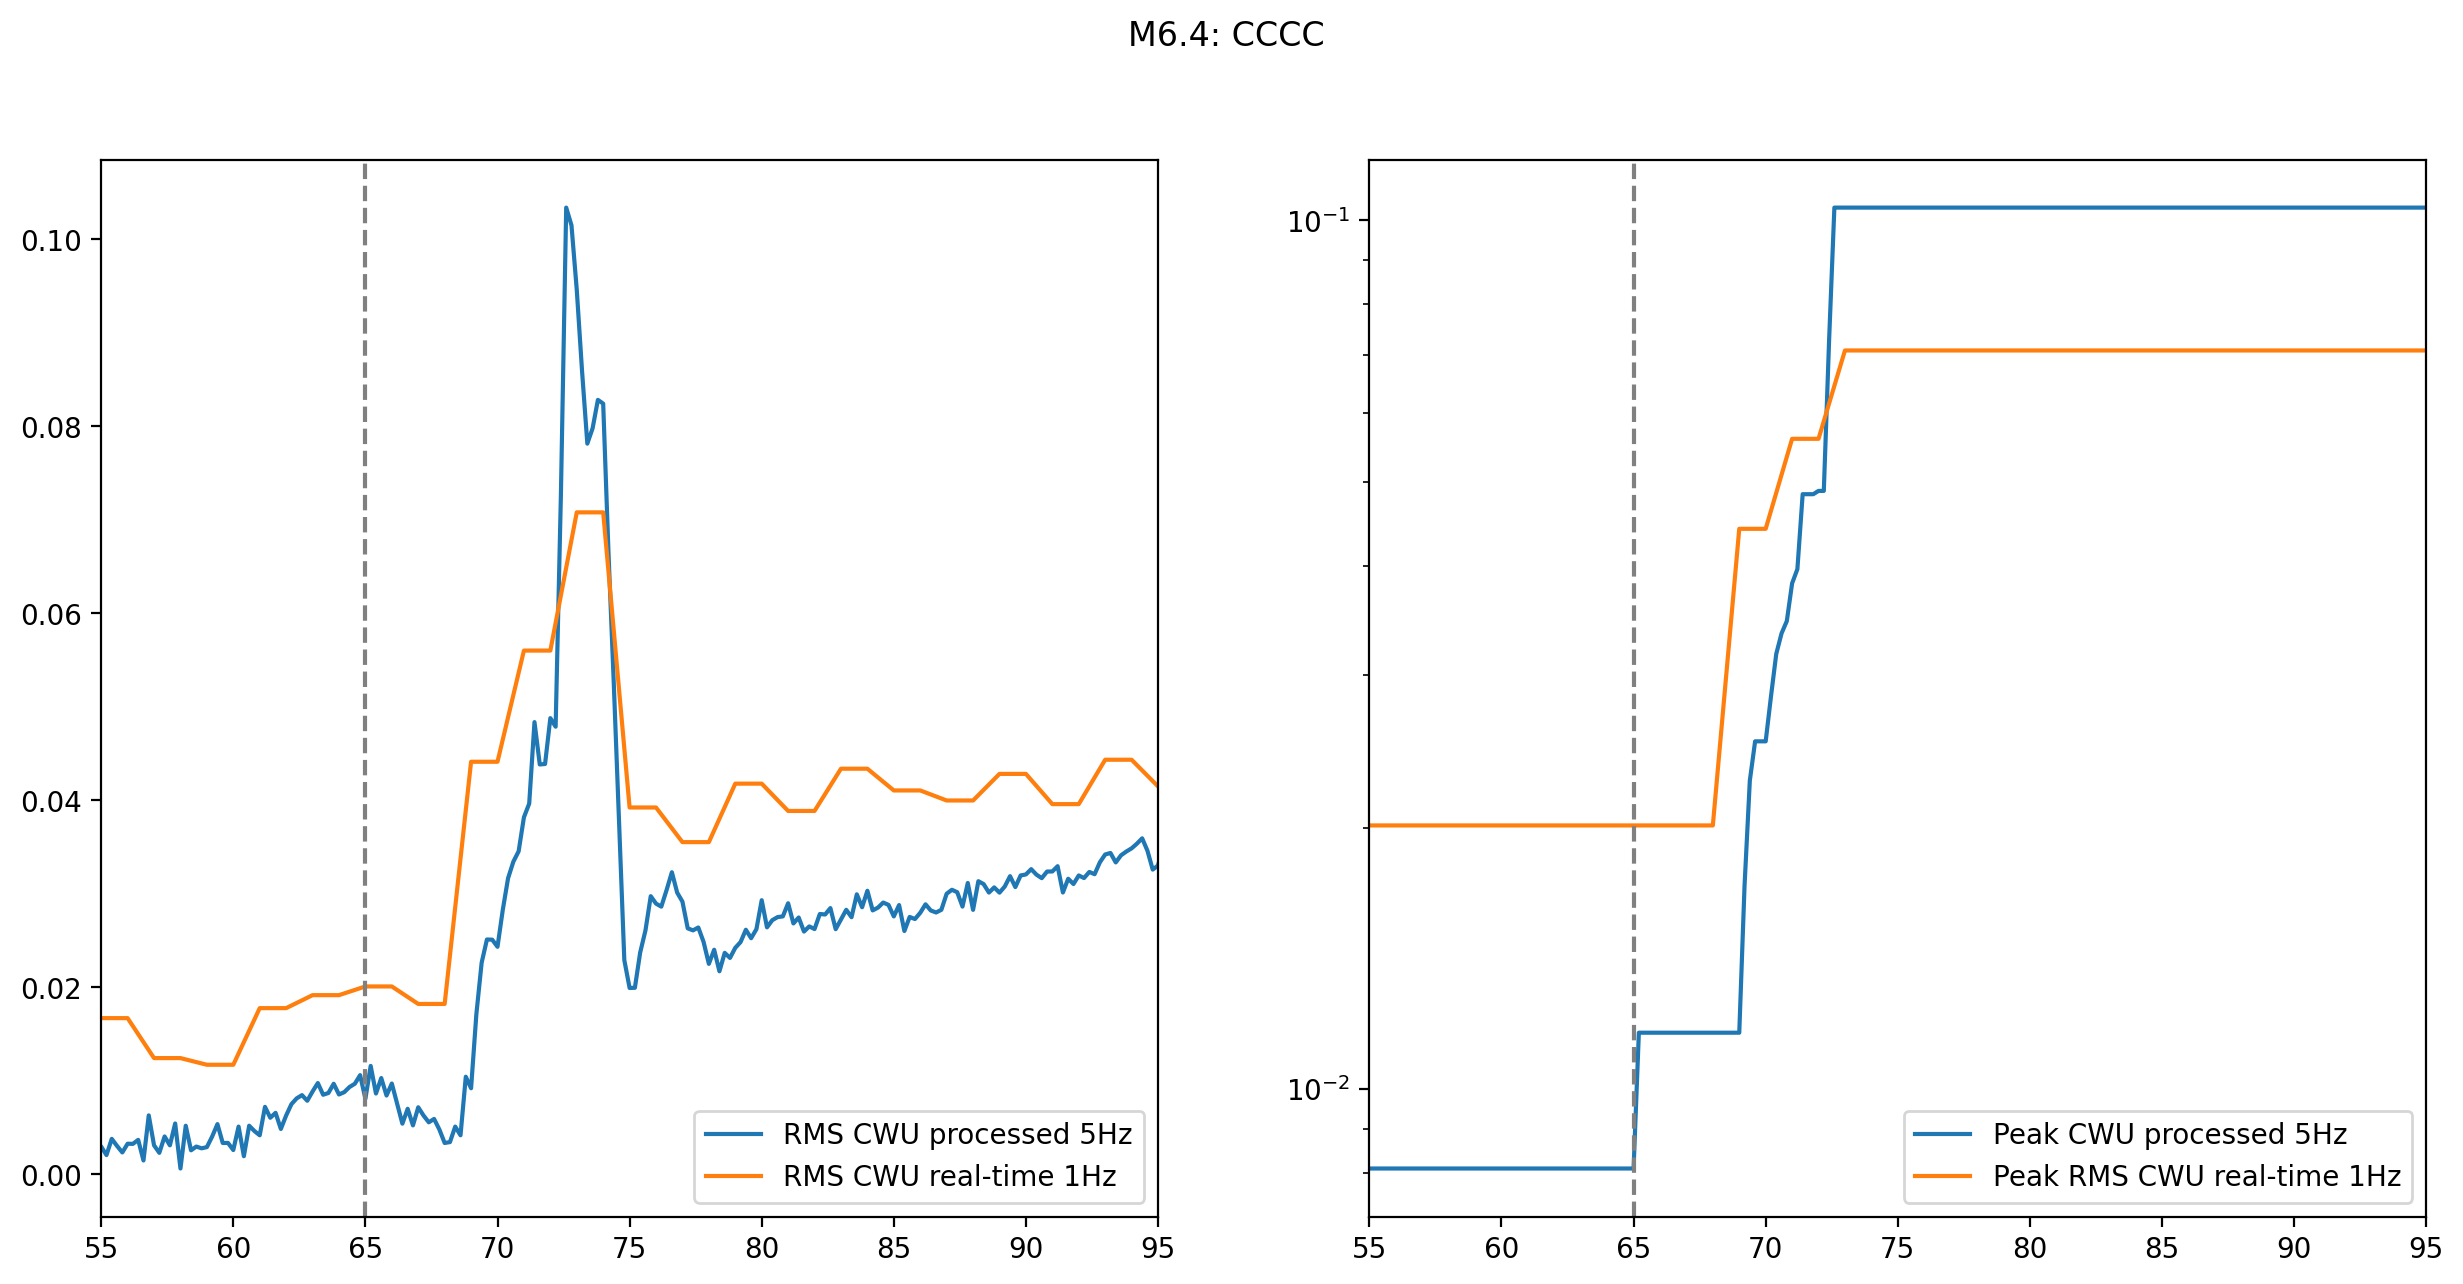

No published RT data for station p463


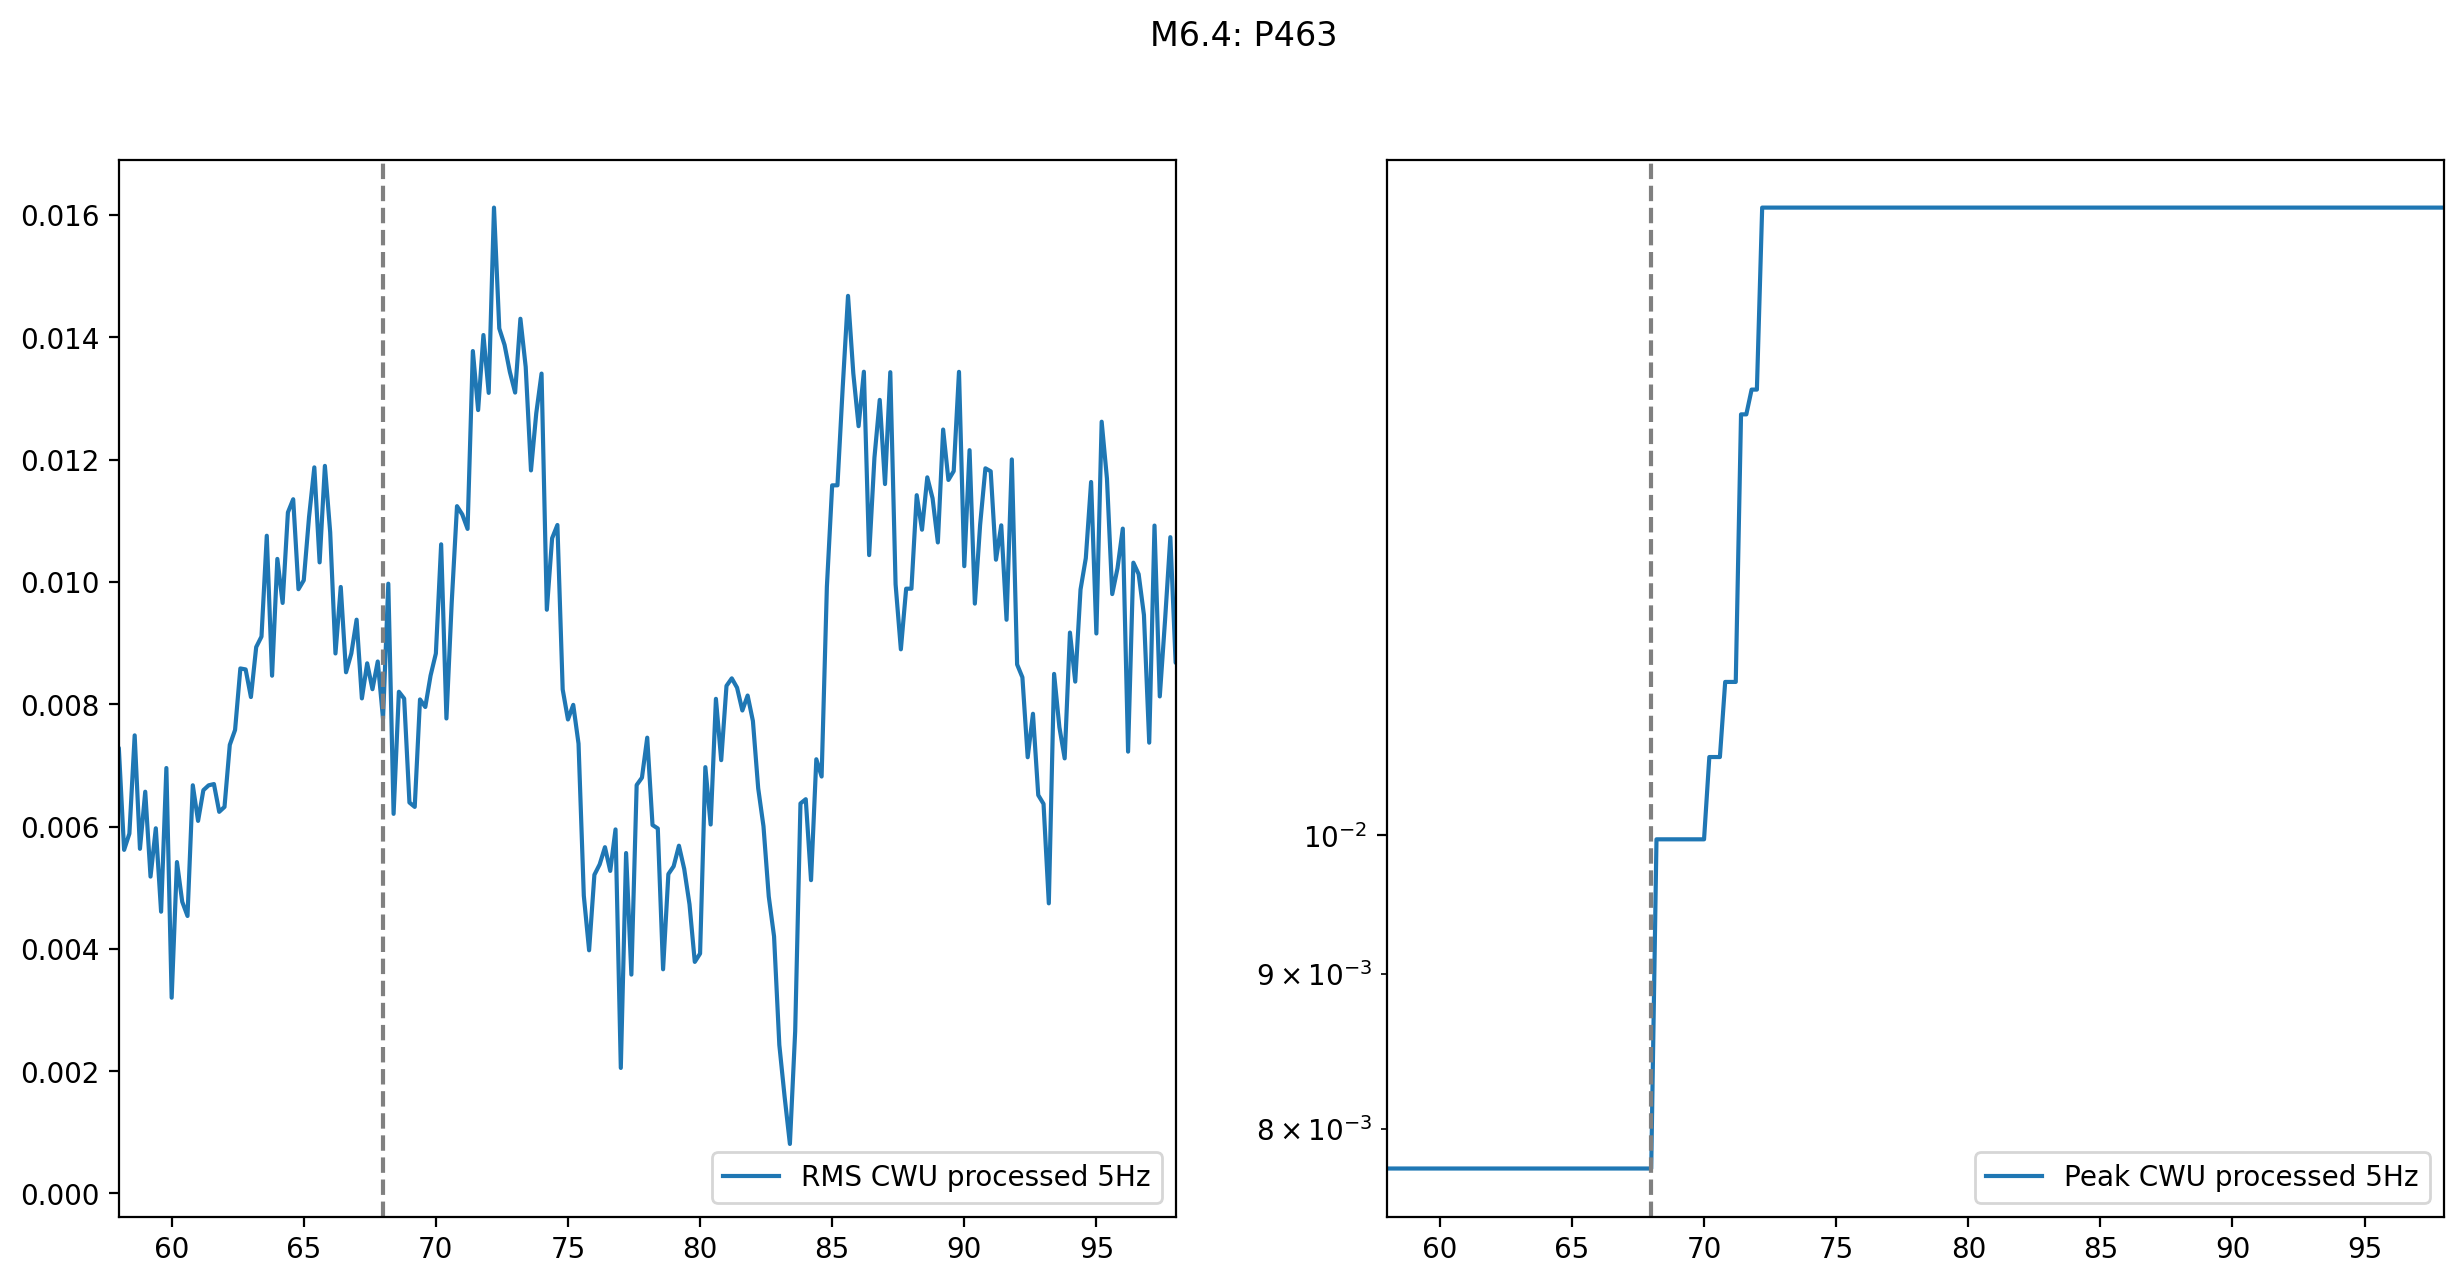

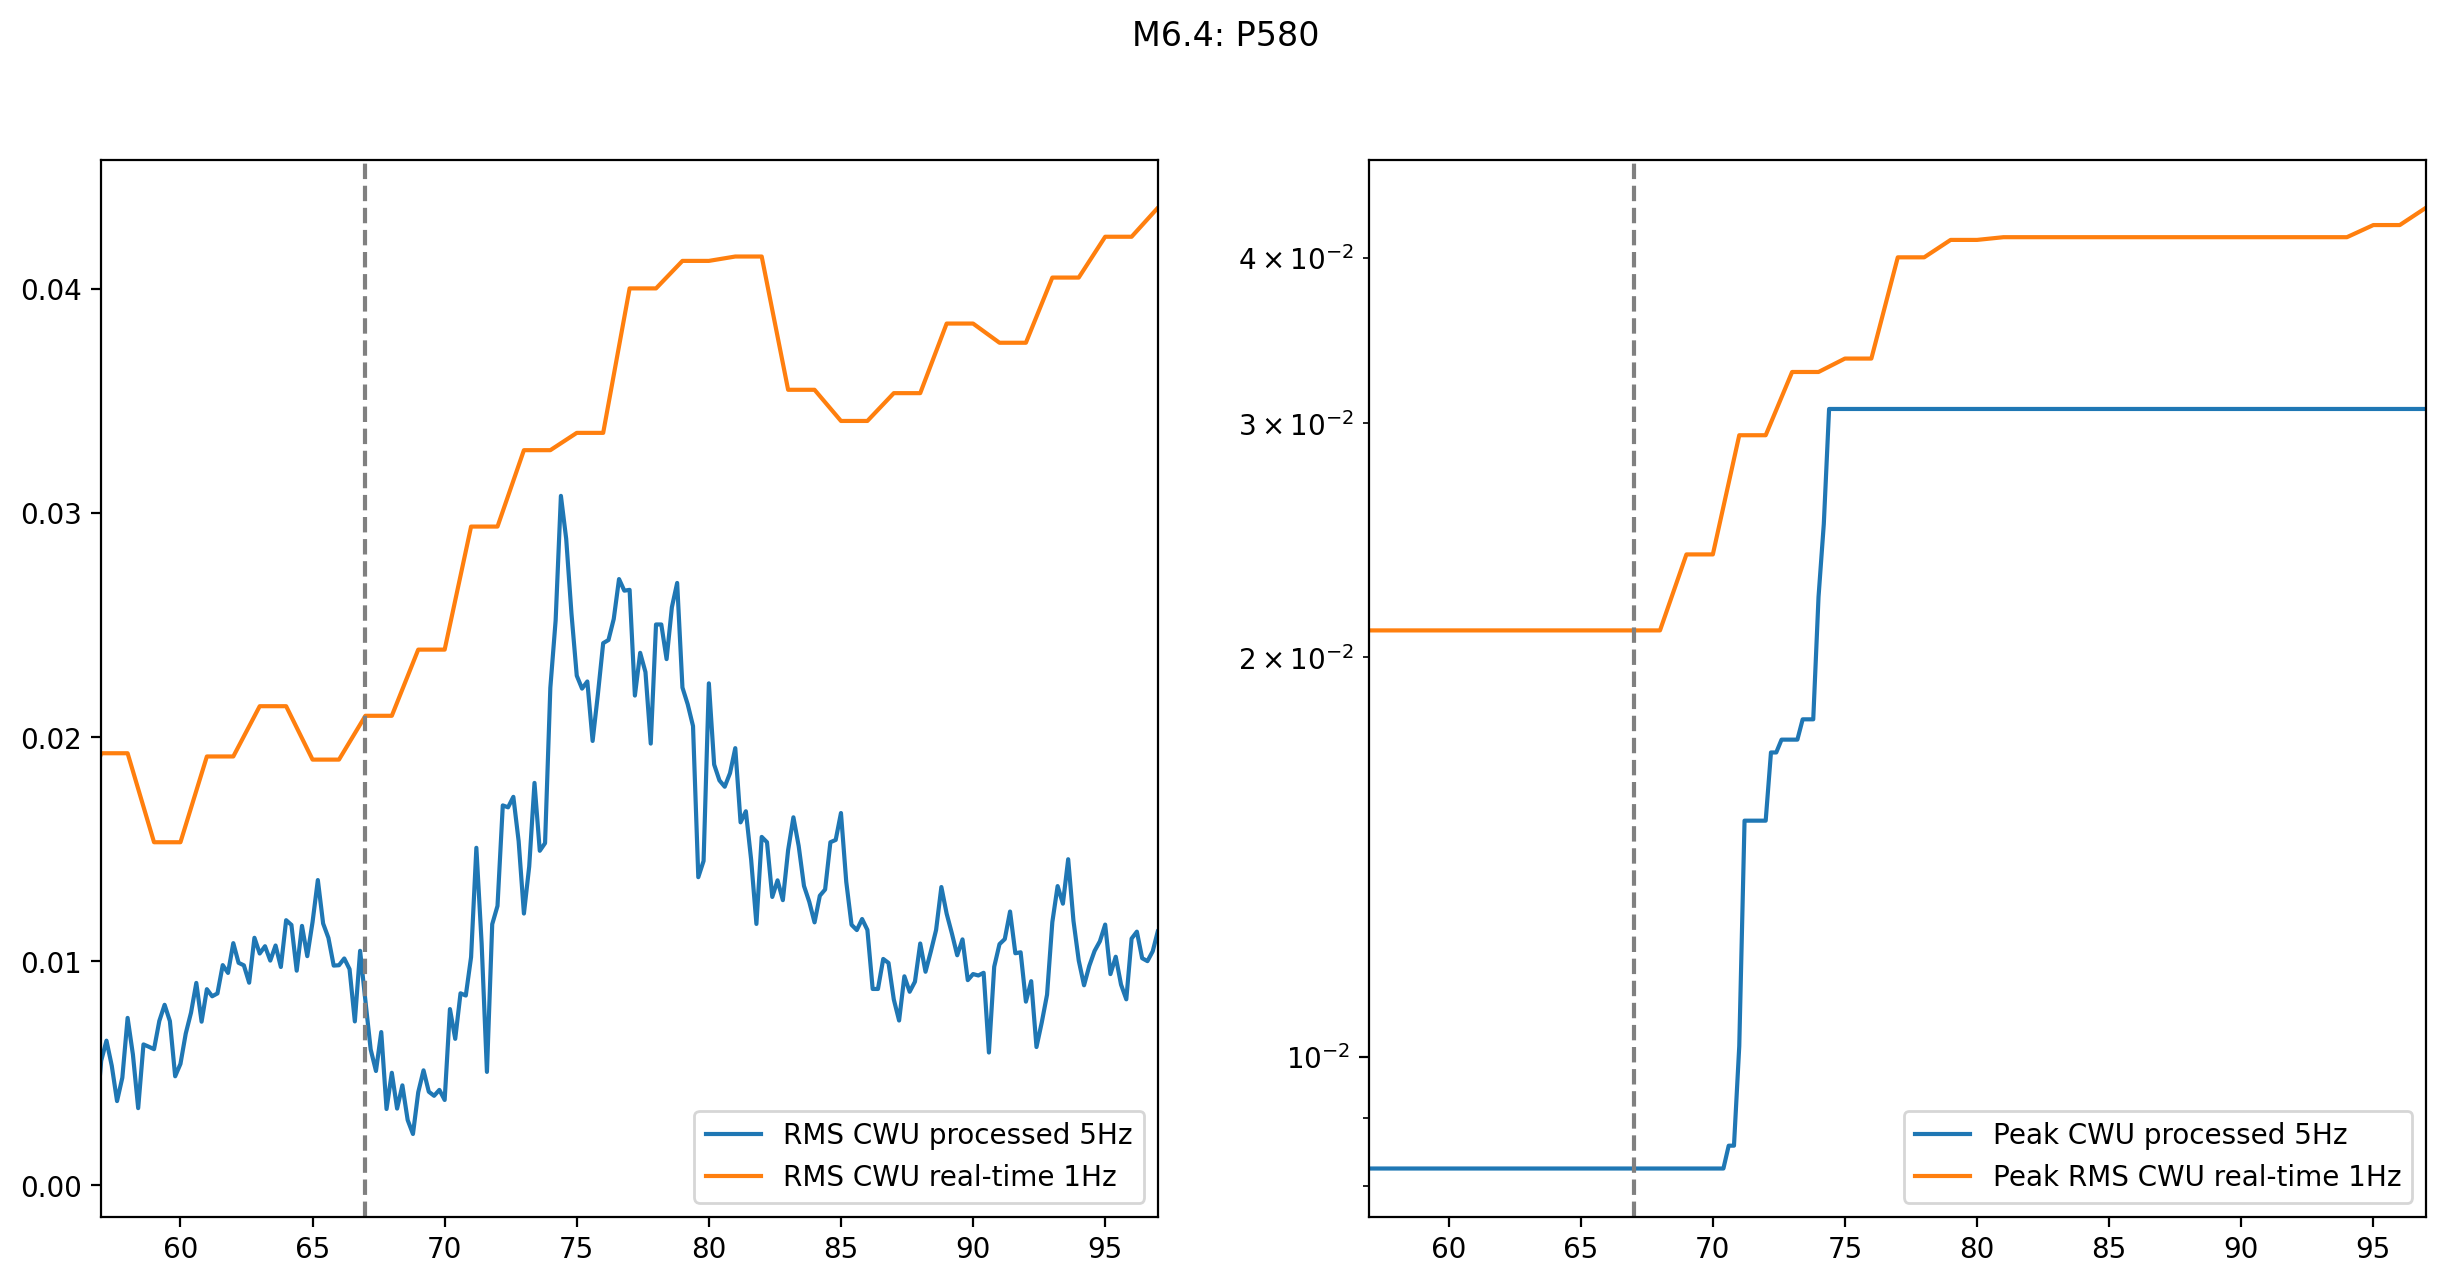

No published RT data for station p590


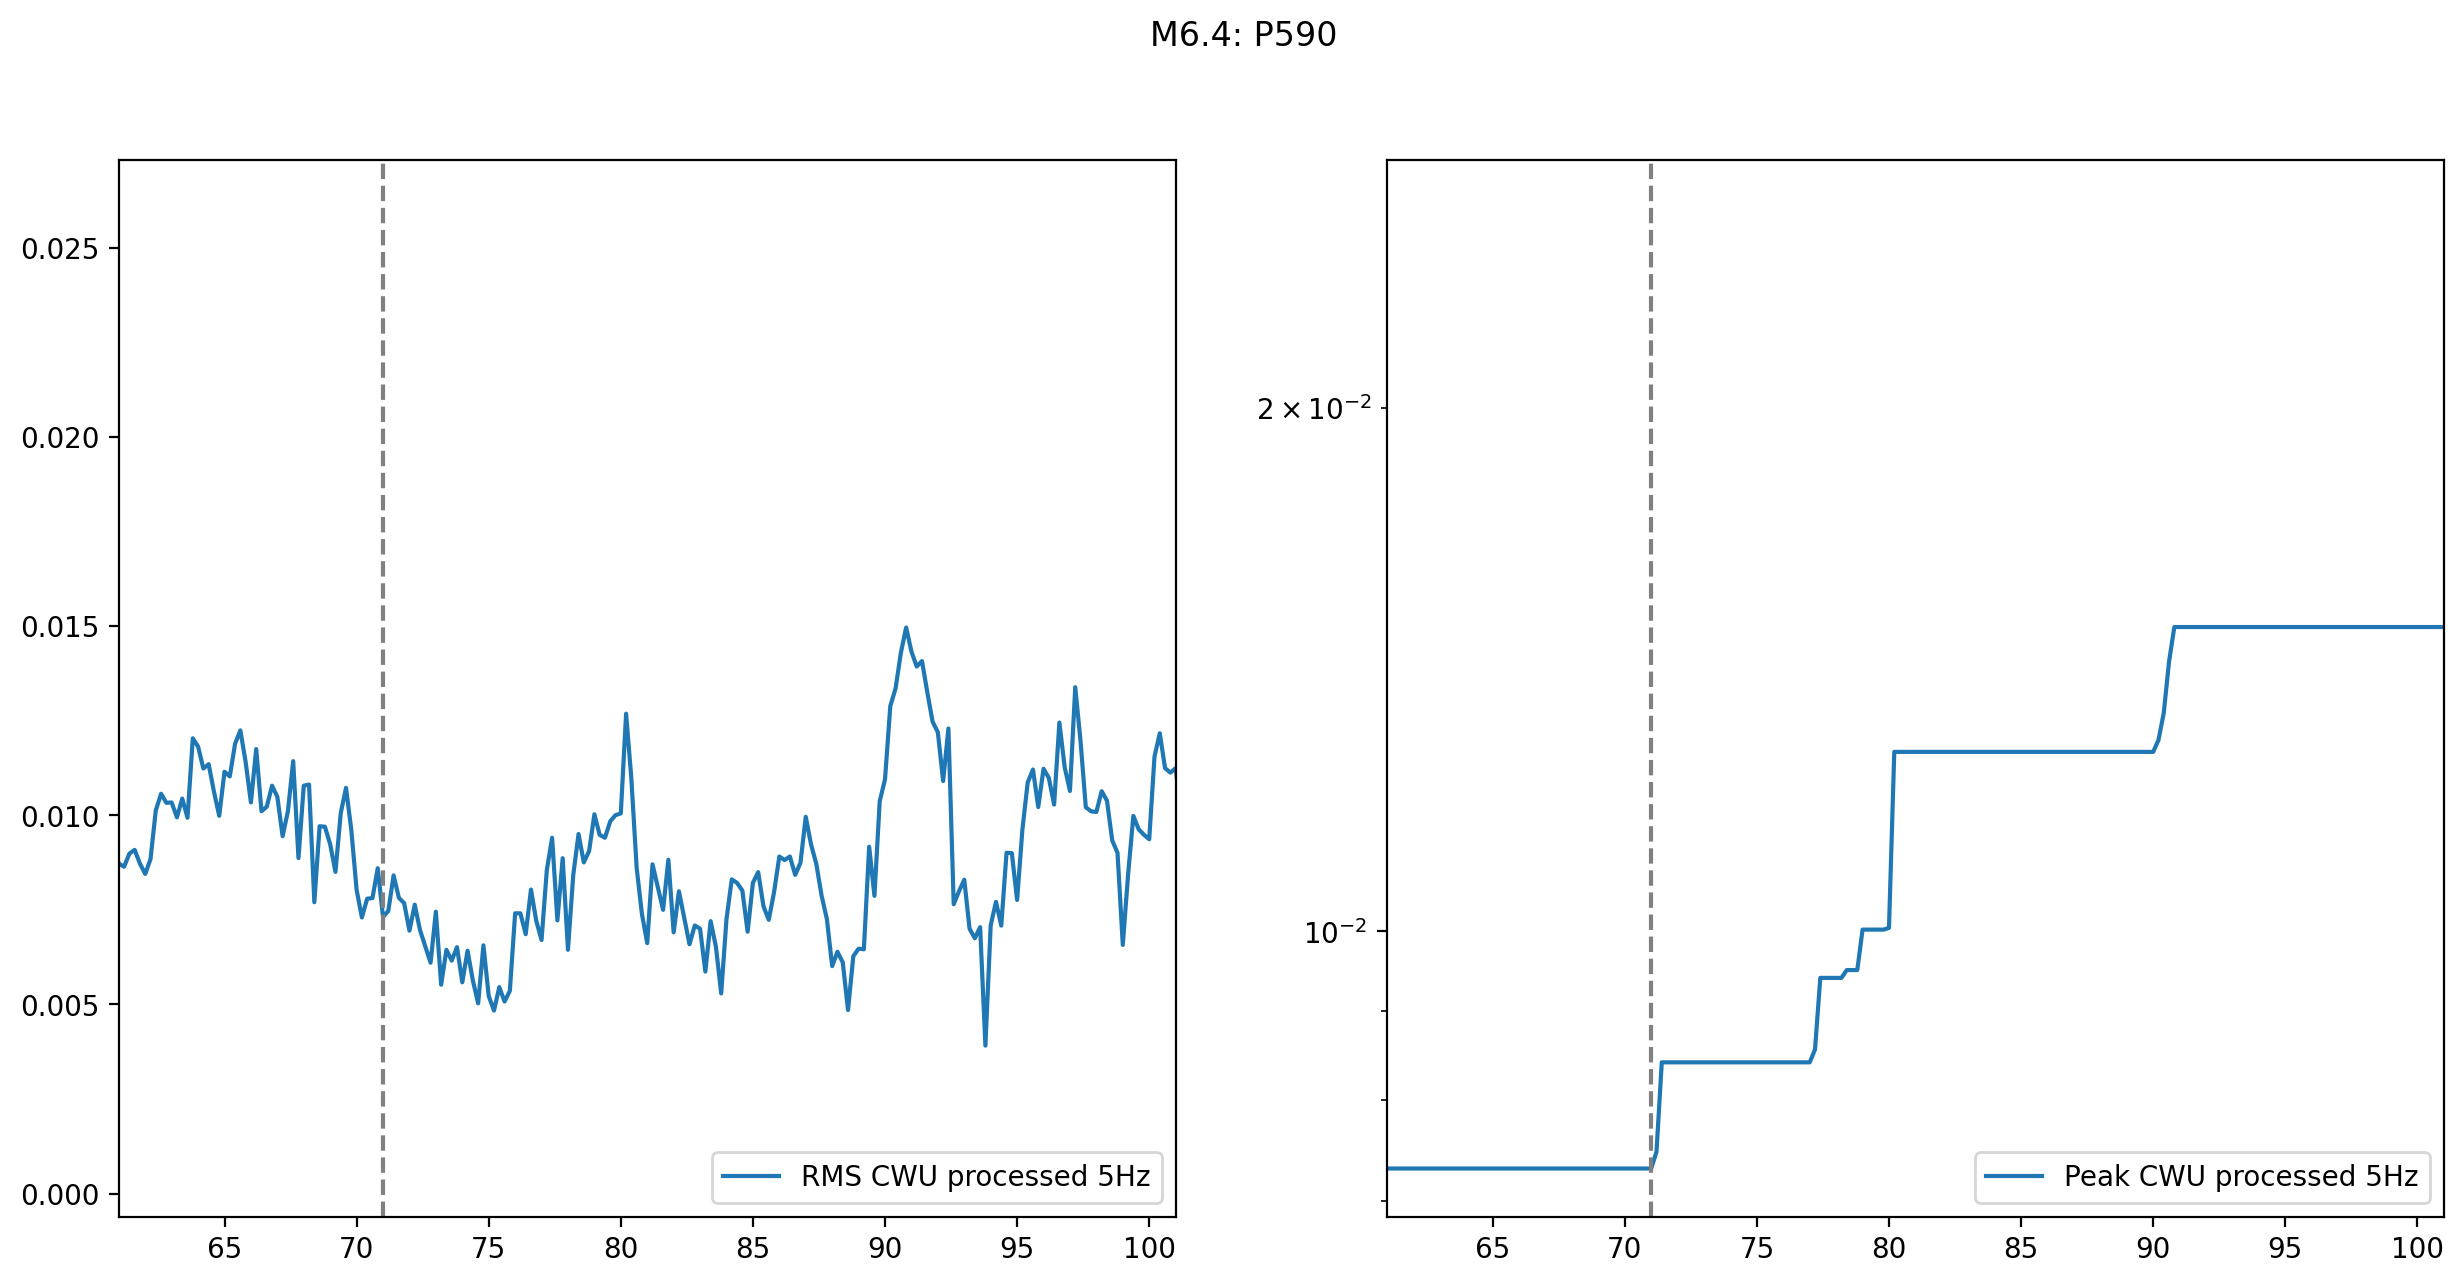

No published RT data for station p592


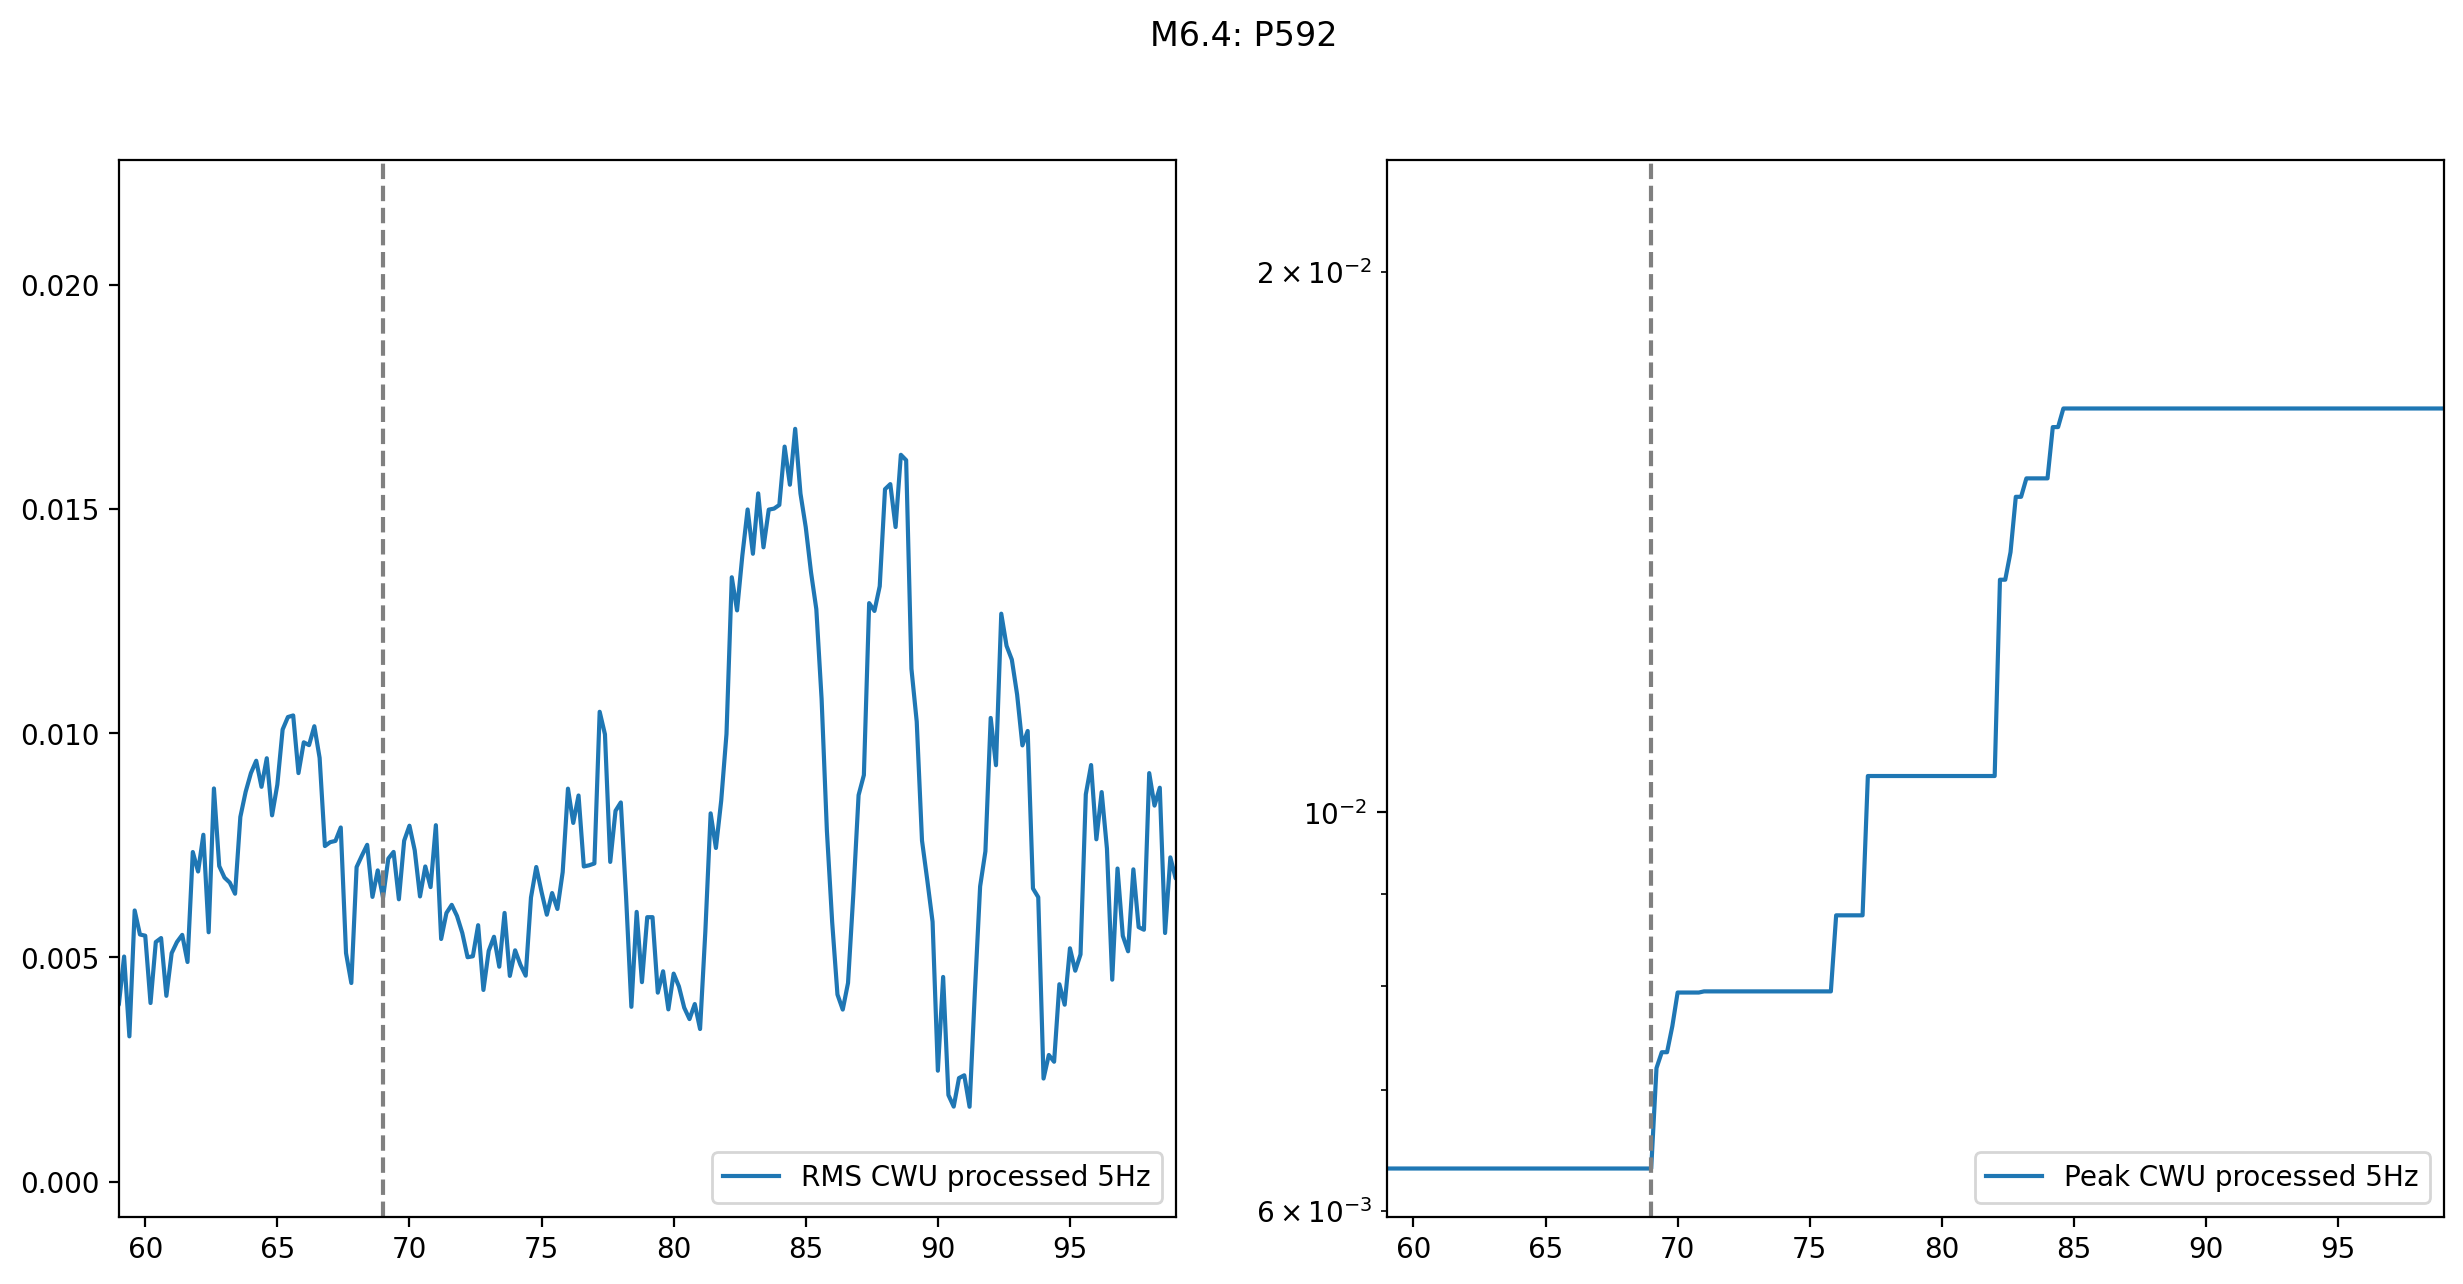

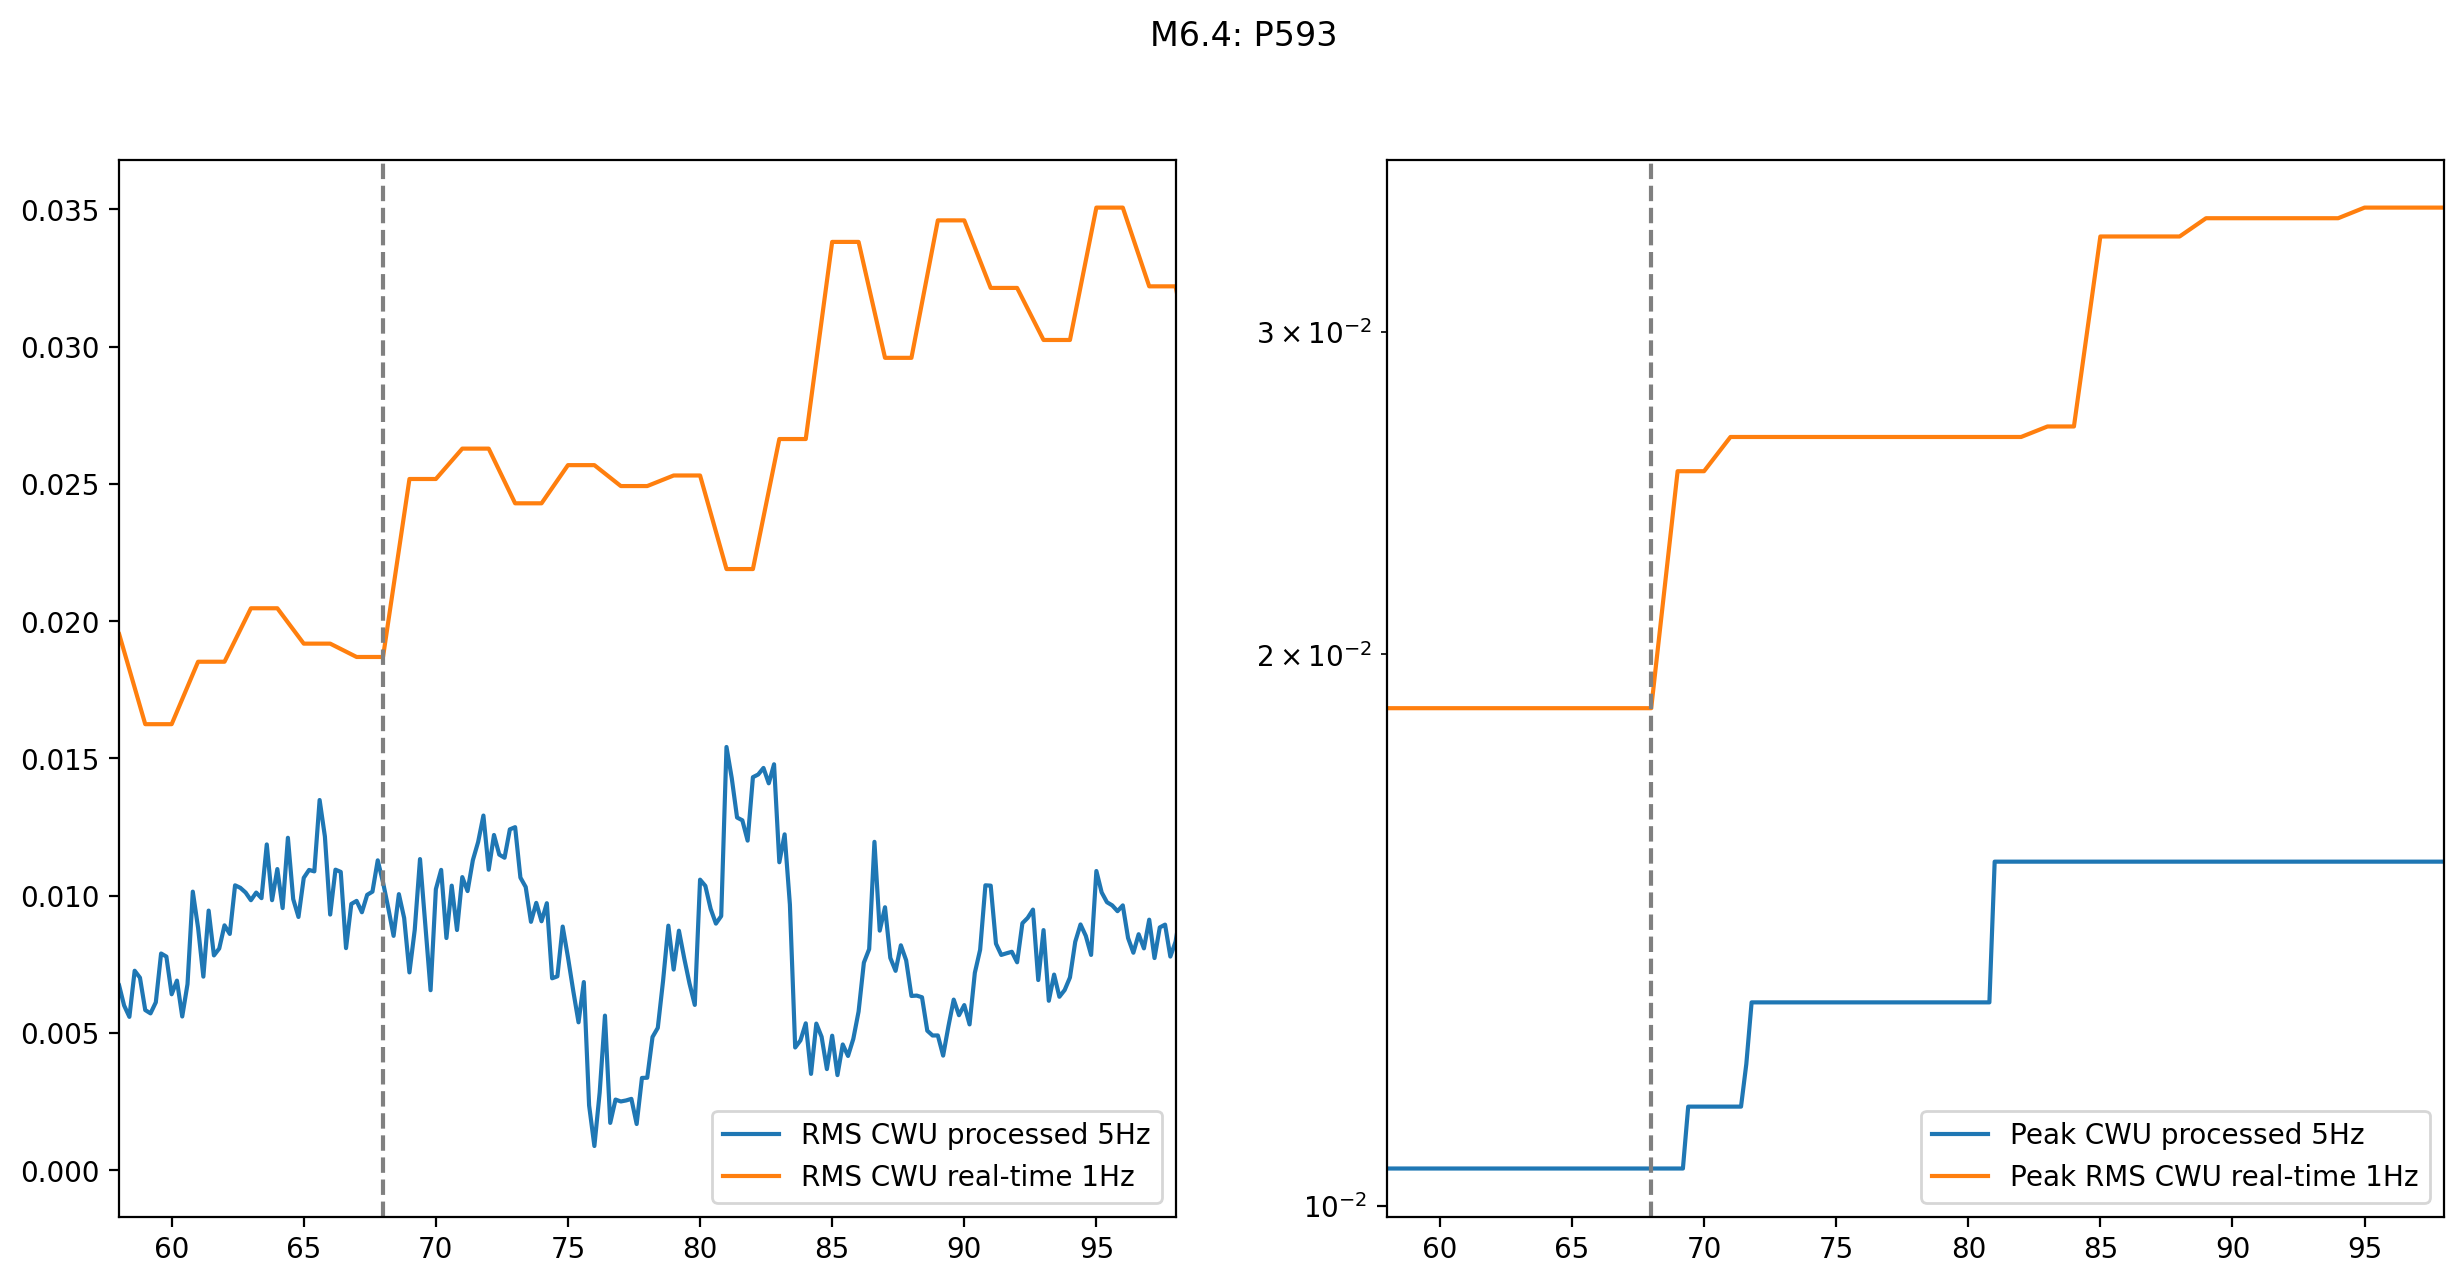

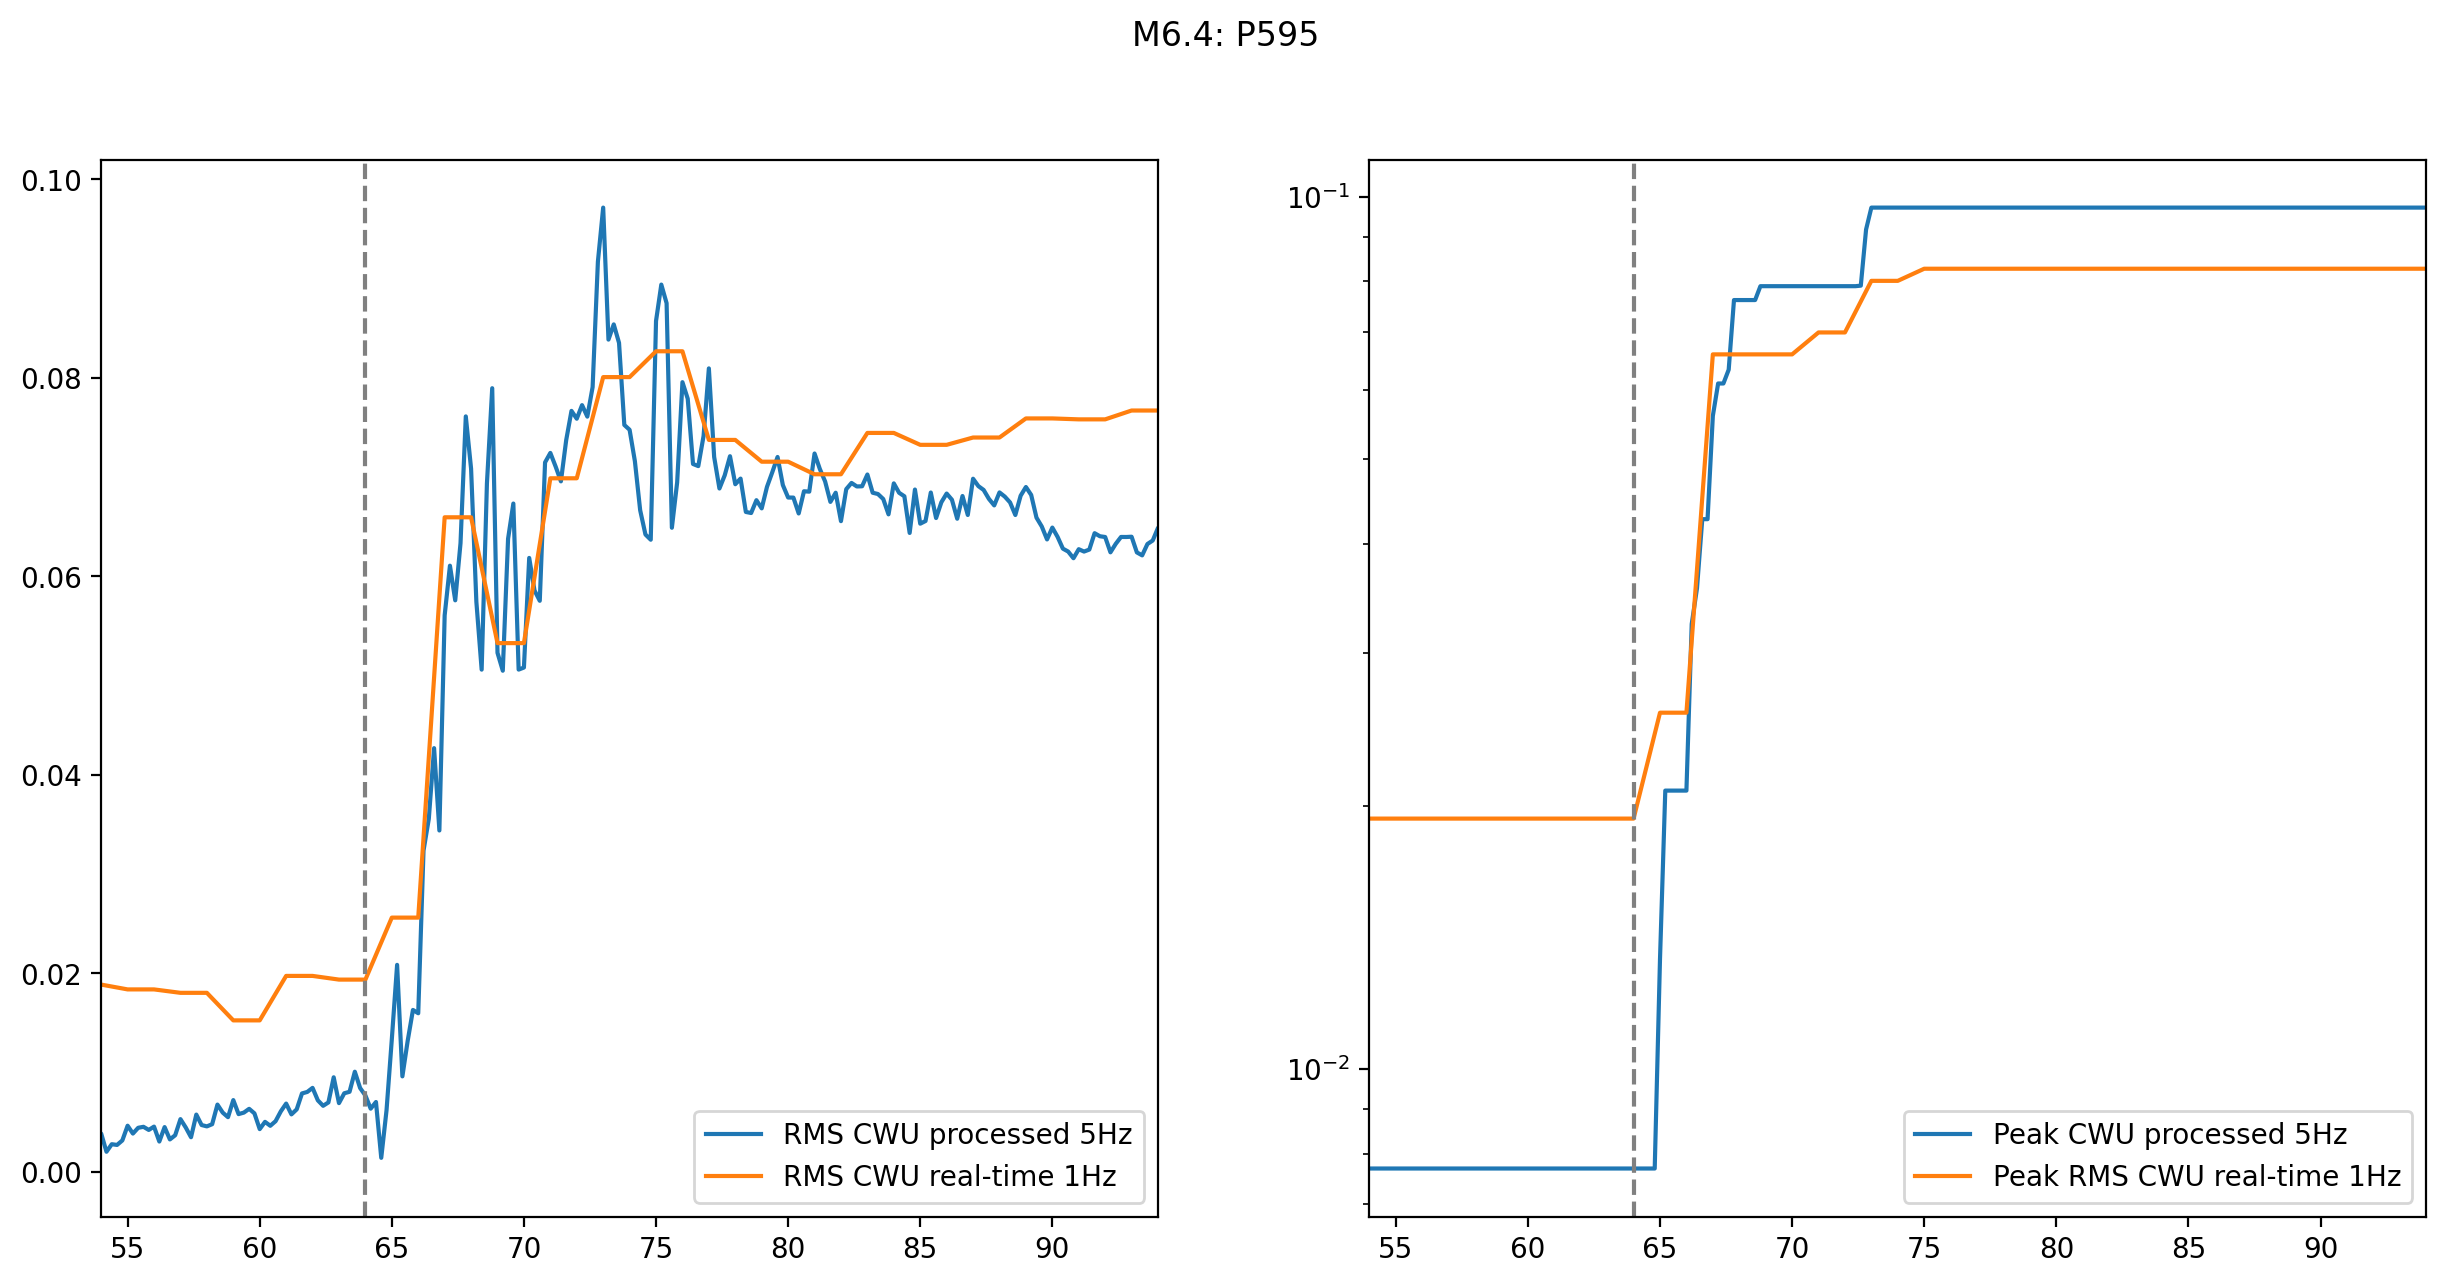

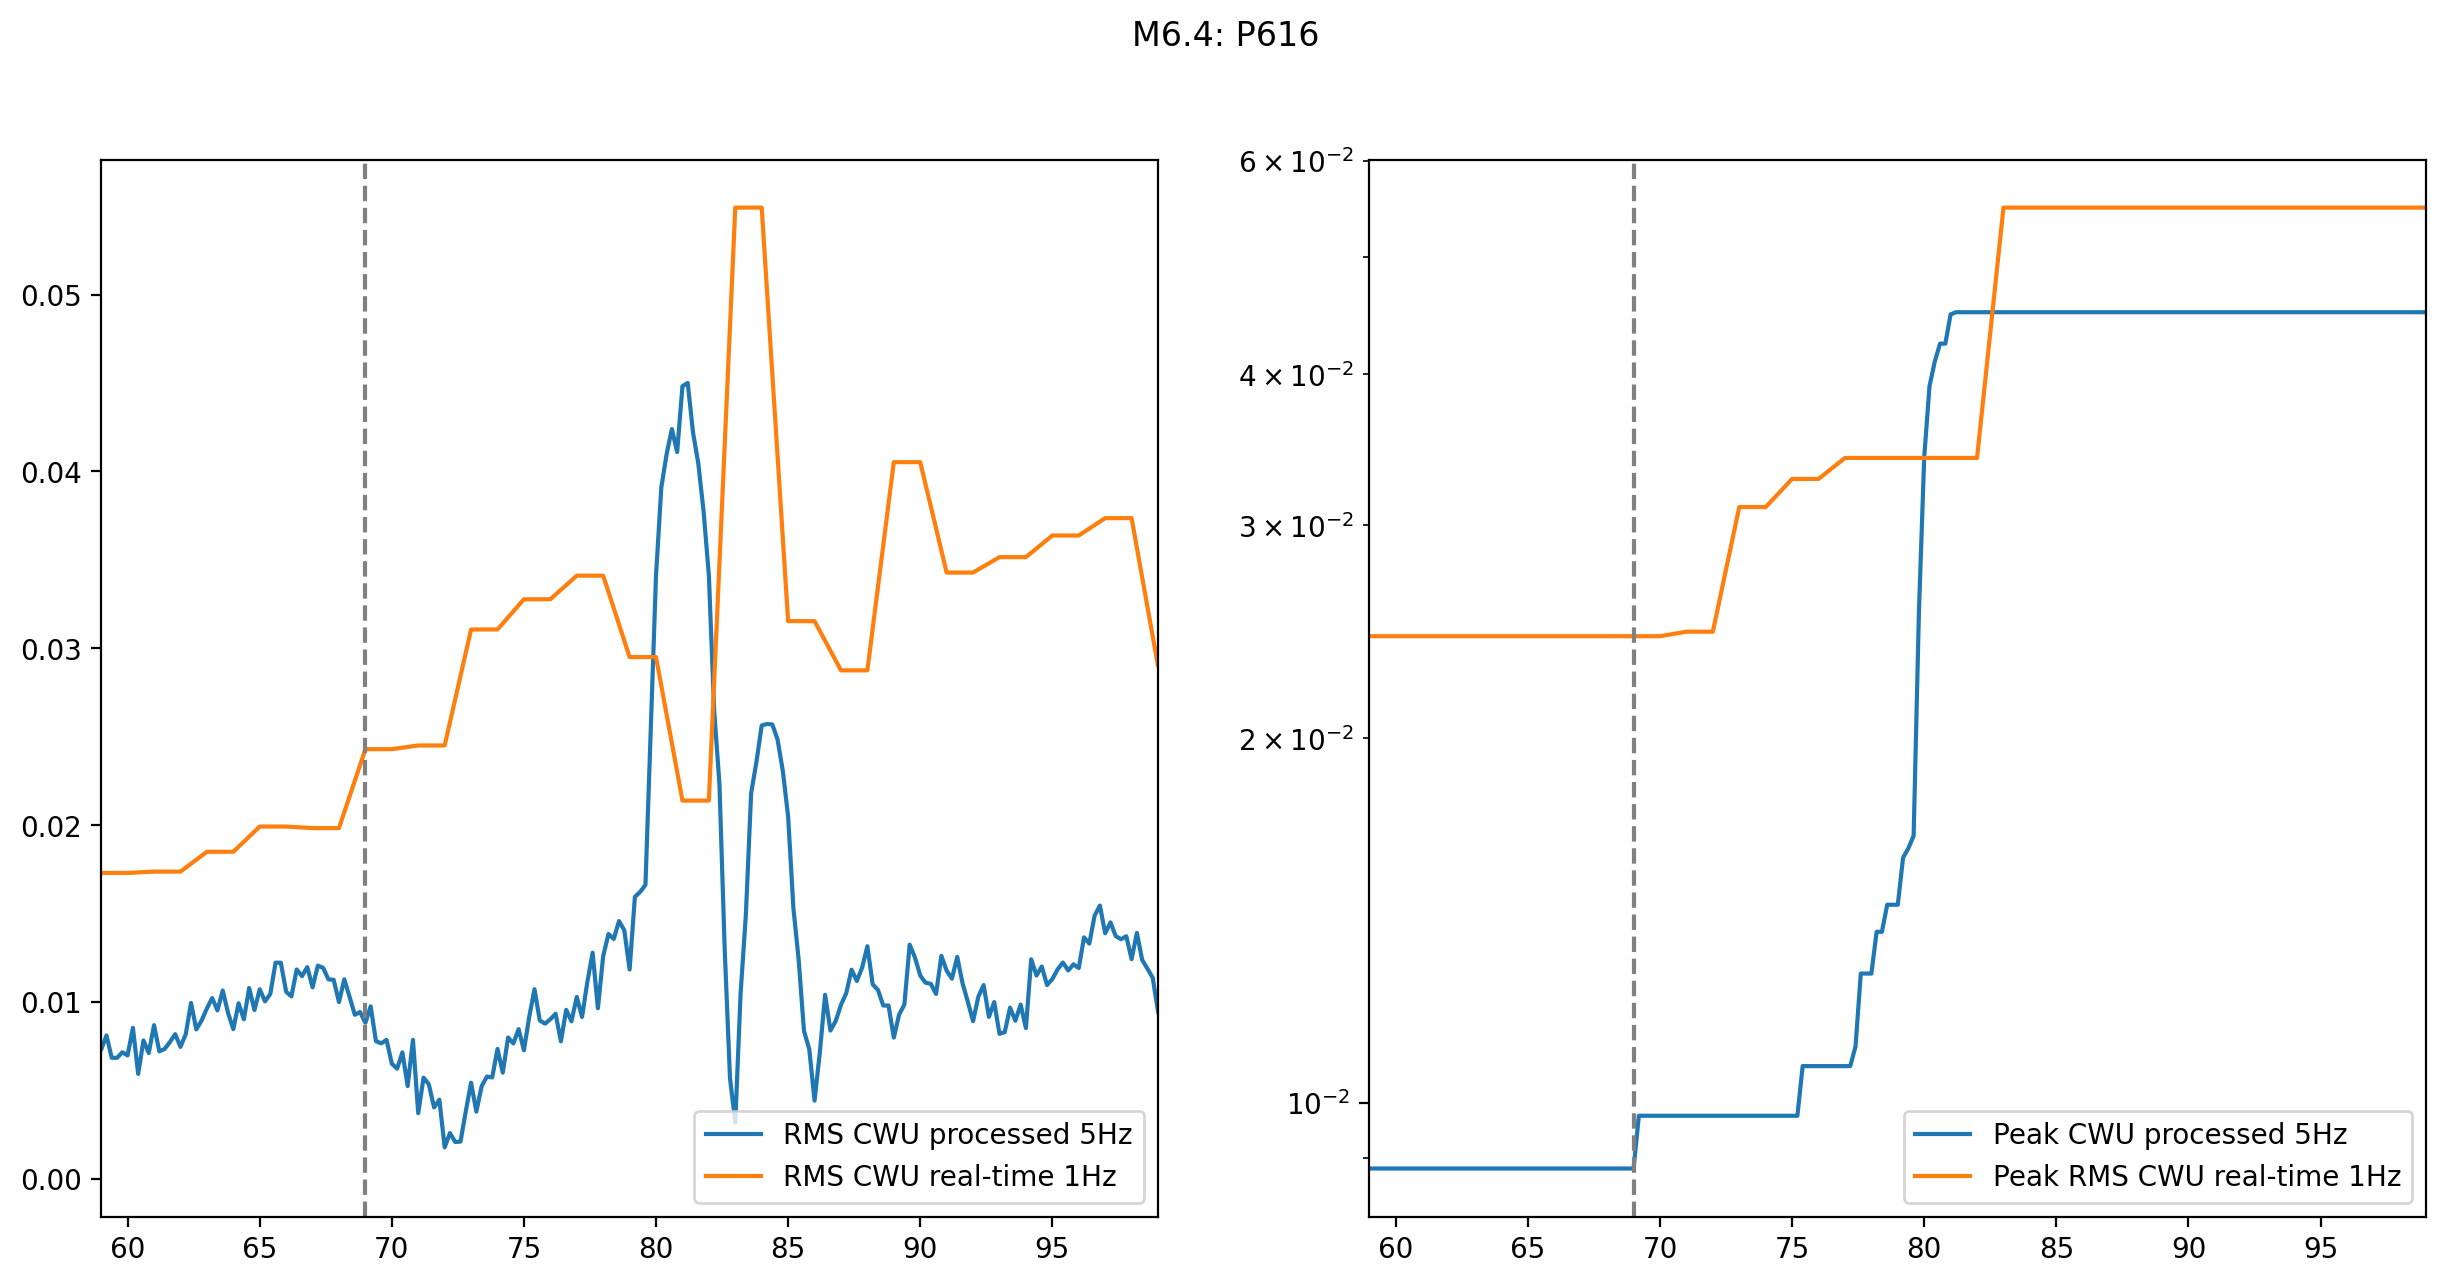

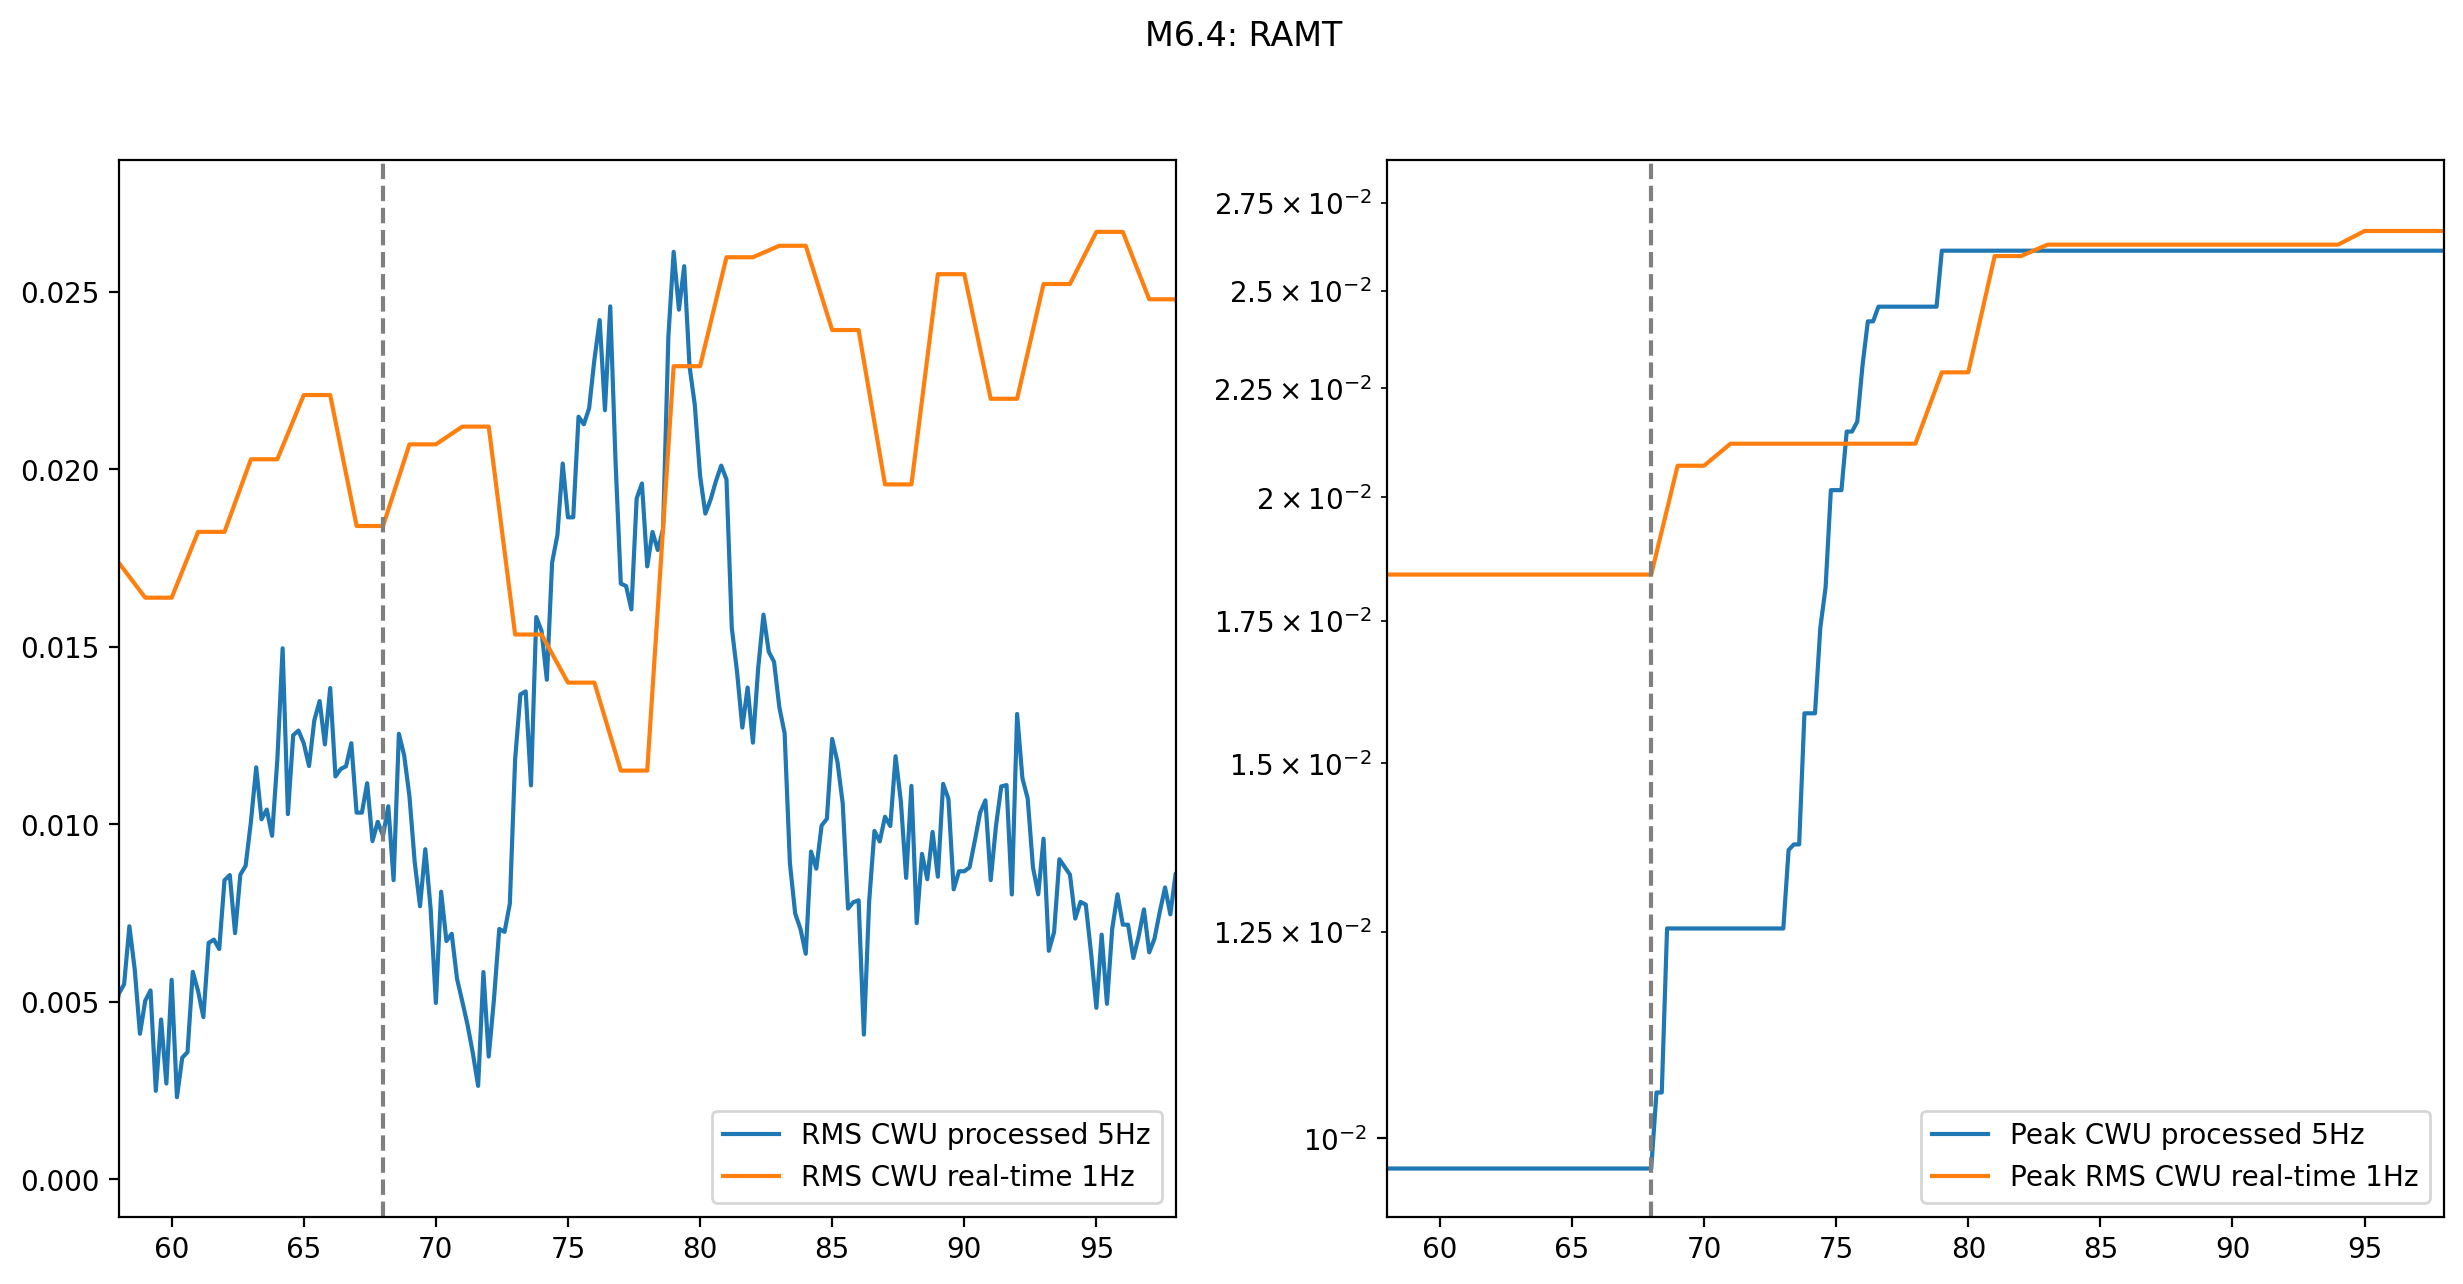

In [106]:
# M6 plots, just published data. Not messing with shifting

pub_rt_n = None
pub_rt_e = None

for idx in range(len(unav_realtime_metadata)):
    
    unav_sta = unav_realtime_metadata[idx,0]
    mag = float(unav_realtime_metadata[idx,6])
    
    if unav_sta not in pub_proc_5hz_stas_M6 or mag != 6.4:
        continue
    
    pub_sta = unav_sta.lower()

    # print(unav_sta, mag)

    ### UNAVCO data ###
    
    unav_samp_rate = 1
    unav_p_arr_samp = int(unav_realtime_metadata[idx,5])
    p_arr_time = UTCDateTime(unav_realtime_metadata[idx,2]) + unav_p_arr_samp
    
    ### Published CWU data ###
    
    # Calculate P arrival time in the published data
    pub_start_time = usgs_6_ot - 60
    pub_p_arr_sec = p_arr_time - pub_start_time

    # Calculate RMS of published horizontal data
    pub_proc_5hz_n = read(proc_5hz_M6_path + pub_sta + '.LYN.mseed')
    pub_proc_5hz_e = read(proc_5hz_M6_path + pub_sta + '.LYE.mseed')
    pub_proc_5hz_times = pub_proc_5hz_n[0].times()
    hoz_rms_pub_proc_5hz_data = np.sqrt((pub_proc_5hz_n[0].data**2 + pub_proc_5hz_e[0].data**2)/2)

    # Calculate P arrival sample in published data
    pub_proc_5hz_samp_rate = pub_proc_5hz_n[0].stats.sampling_rate
    pub_p_arr_samp_proc_5hz = int(pub_p_arr_sec * pub_proc_5hz_samp_rate)

    # Calculate the peak published GNSS data
    peak_pub_proc_5hz = get_peak_gnss(hoz_rms_pub_proc_5hz_data, pub_p_arr_samp_proc_5hz)
    
    try:
        pub_rt_n = read(rt_1hz_M6_path + pub_sta + '.LYN.mseed')
        pub_rt_e = read(rt_1hz_M6_path + pub_sta + '.LYE.mseed')
    except:
        print('No published RT data for station ' + str(pub_sta))
    
    if pub_rt_n != None:
        pub_rt_times = pub_rt_n[0].times()
        hoz_rms_pub_rt_data = np.sqrt((pub_rt_n[0].data**2 + pub_rt_e[0].data**2)/2)

        # Calculate P arrival sample in published data
        pub_rt_samp_rate = pub_rt_n[0].stats.sampling_rate
        pub_p_arr_samp_rt = int(pub_p_arr_sec * pub_rt_samp_rate)

        # Calculate the peak published GNSS data
        peak_pub_rt = get_peak_gnss(hoz_rms_pub_rt_data, pub_p_arr_samp_rt)

    xlim_low = pub_p_arr_sec - 10
    xlim_high = pub_p_arr_sec + 30
    
    plt.subplots(figsize = (15,7), dpi = 200)
    plt.suptitle('M6.4: ' + unav_sta)
    
    plt.subplot(121)
    # plt.plot(unav_rt_times, hoz_rms_unav_rt_data, label = 'RMS UNAVCO real-time 1Hz')
    plt.plot(pub_proc_5hz_times, hoz_rms_pub_proc_5hz_data, label = 'RMS CWU processed 5Hz')
    if pub_rt_n != None:
        plt.plot(pub_rt_times, hoz_rms_pub_rt_data, label = 'RMS CWU real-time 1Hz')
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.legend(loc = 'lower right')
    
    plt.subplot(122)
    # plt.plot(unav_rt_times, peak_unav_rt, label = 'Peak UNAVCO real-time 1Hz')
    plt.plot(pub_proc_5hz_times, peak_pub_proc_5hz, label = 'Peak CWU processed 5Hz')
    if pub_rt_n != None:
        plt.plot(pub_rt_times, peak_pub_rt, label = 'Peak RMS CWU real-time 1Hz')
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.semilogy()
    plt.legend(loc = 'lower right')
    
    plt.show()
    
    pub_rt_n = None
    pub_rt_e = None

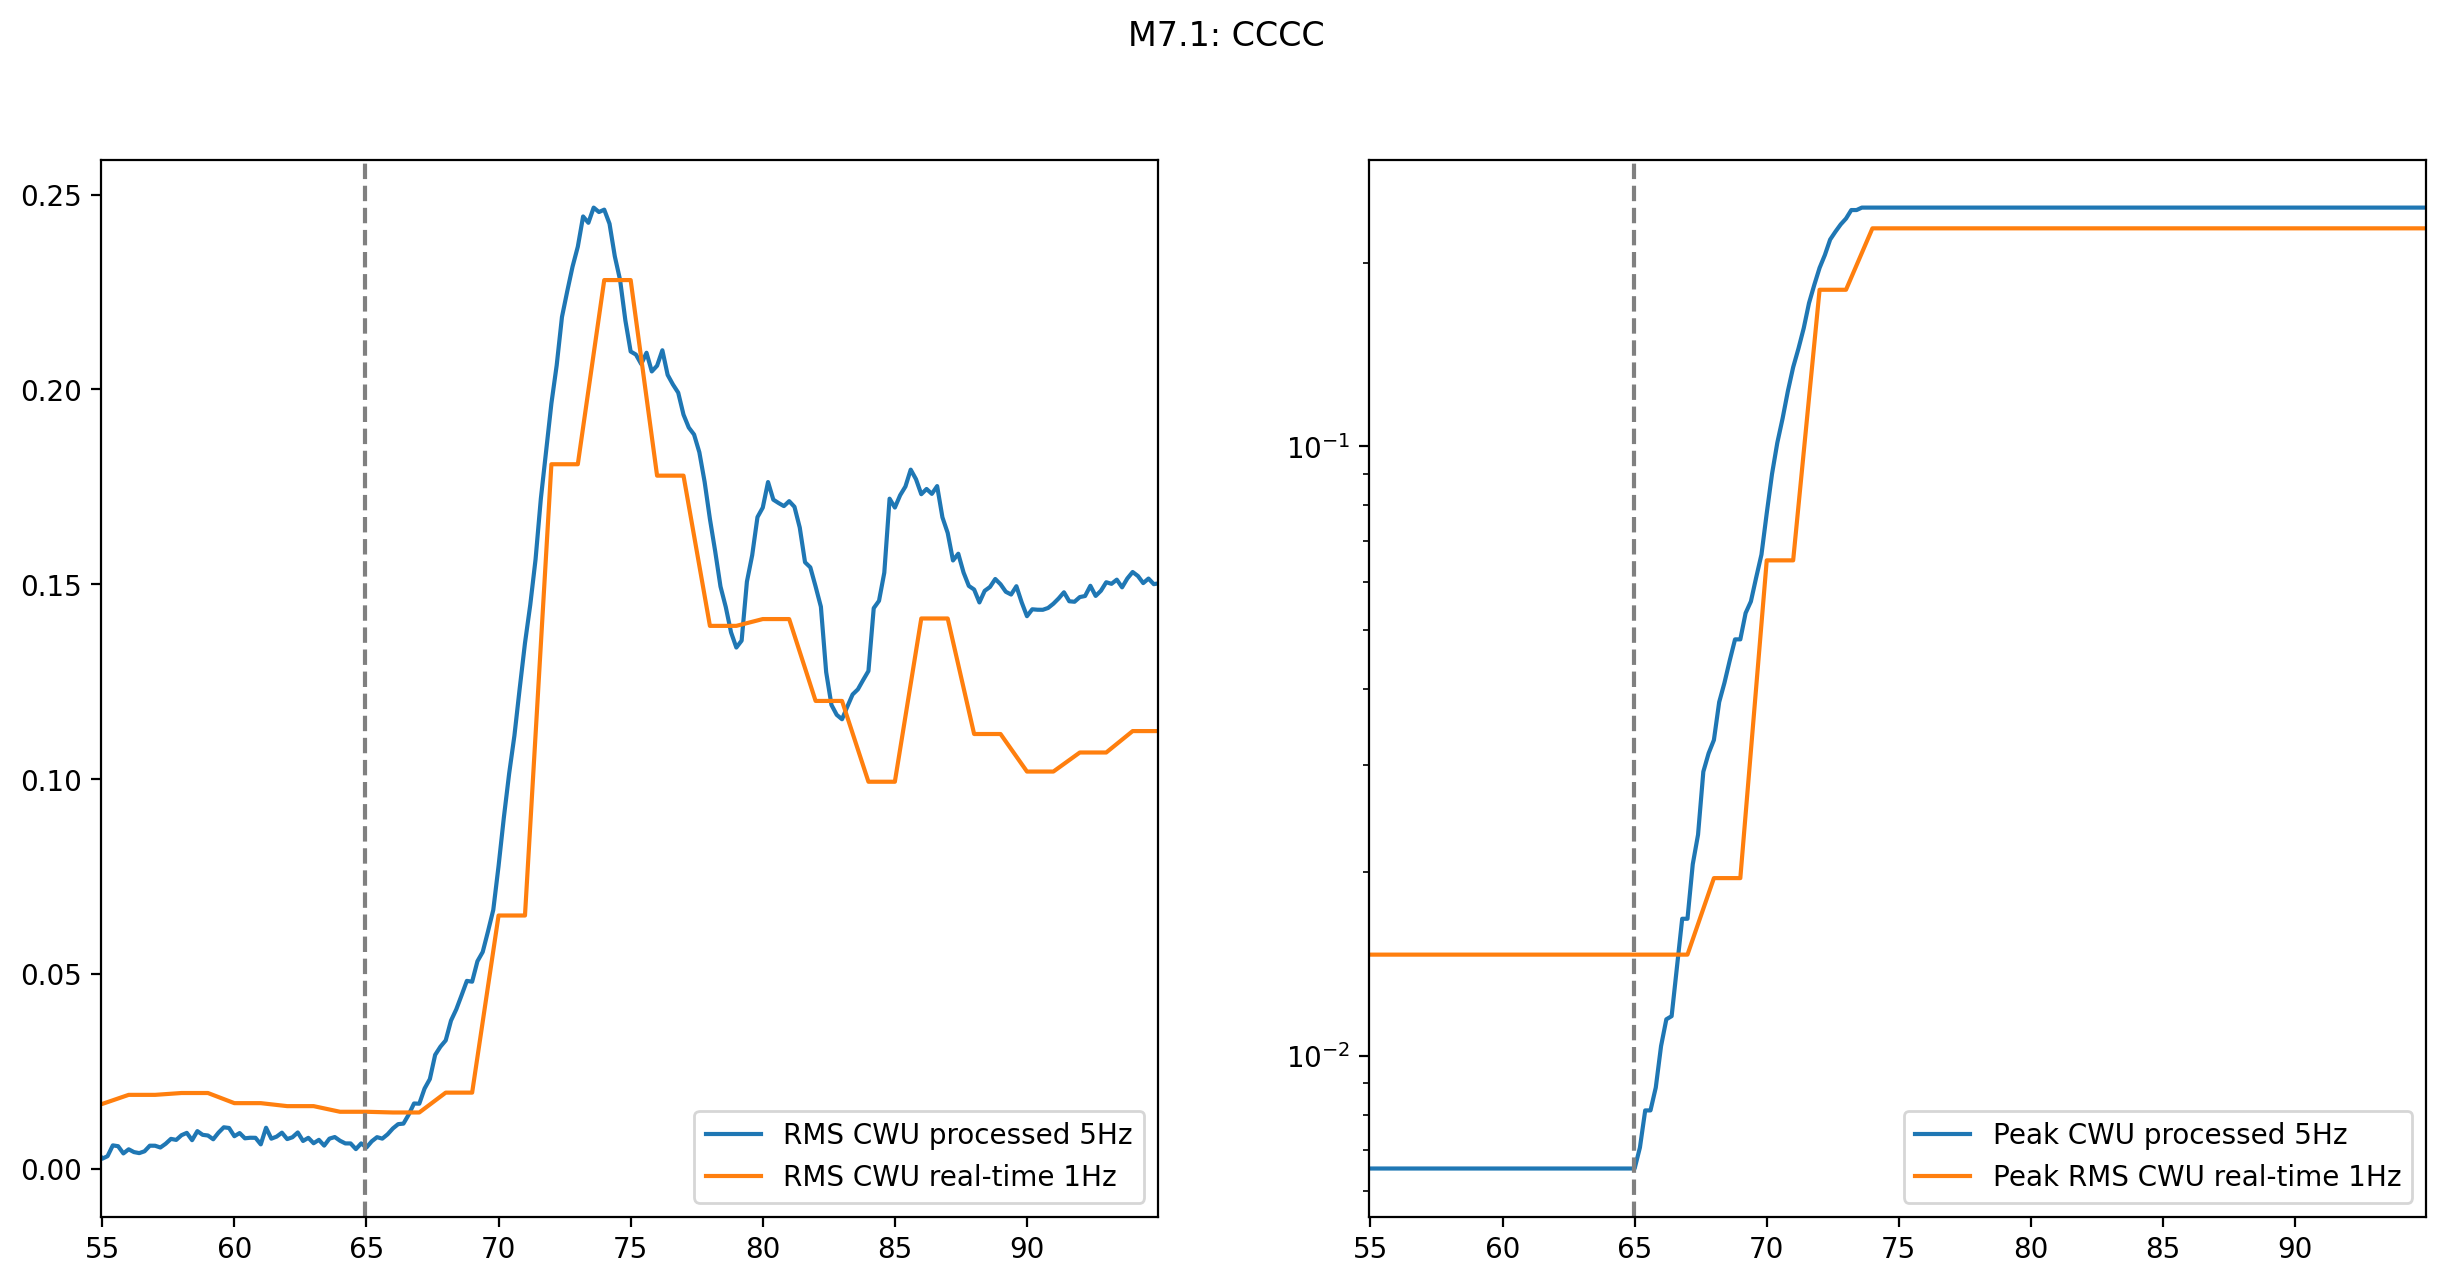

No published RT data for station lnmt


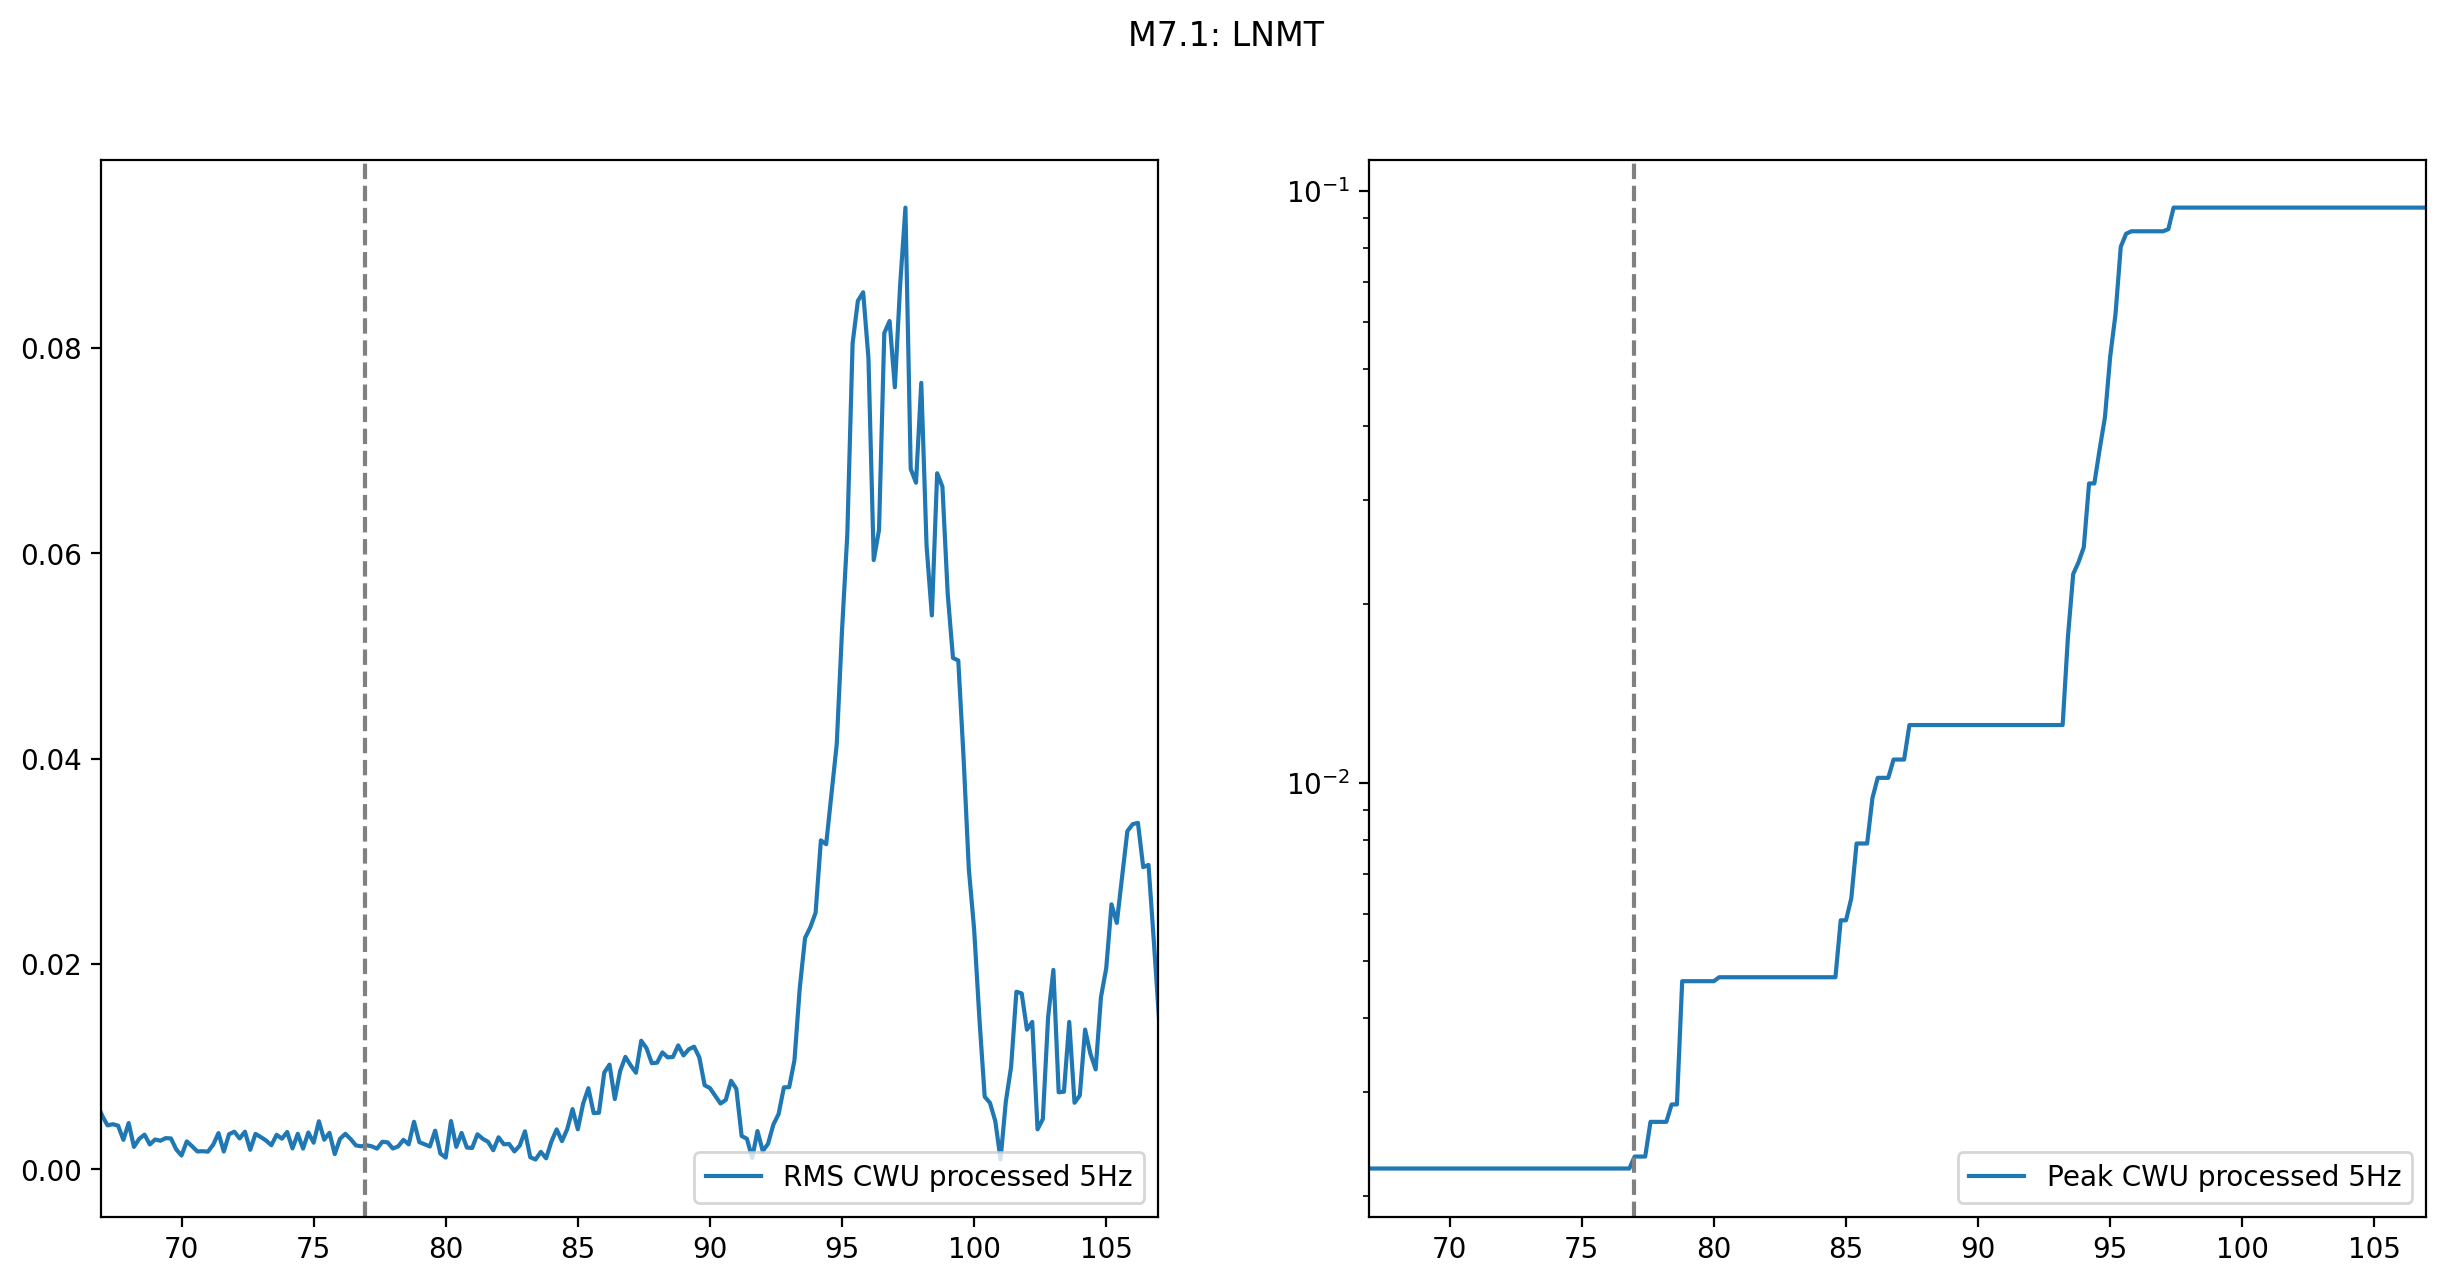

No published RT data for station p091


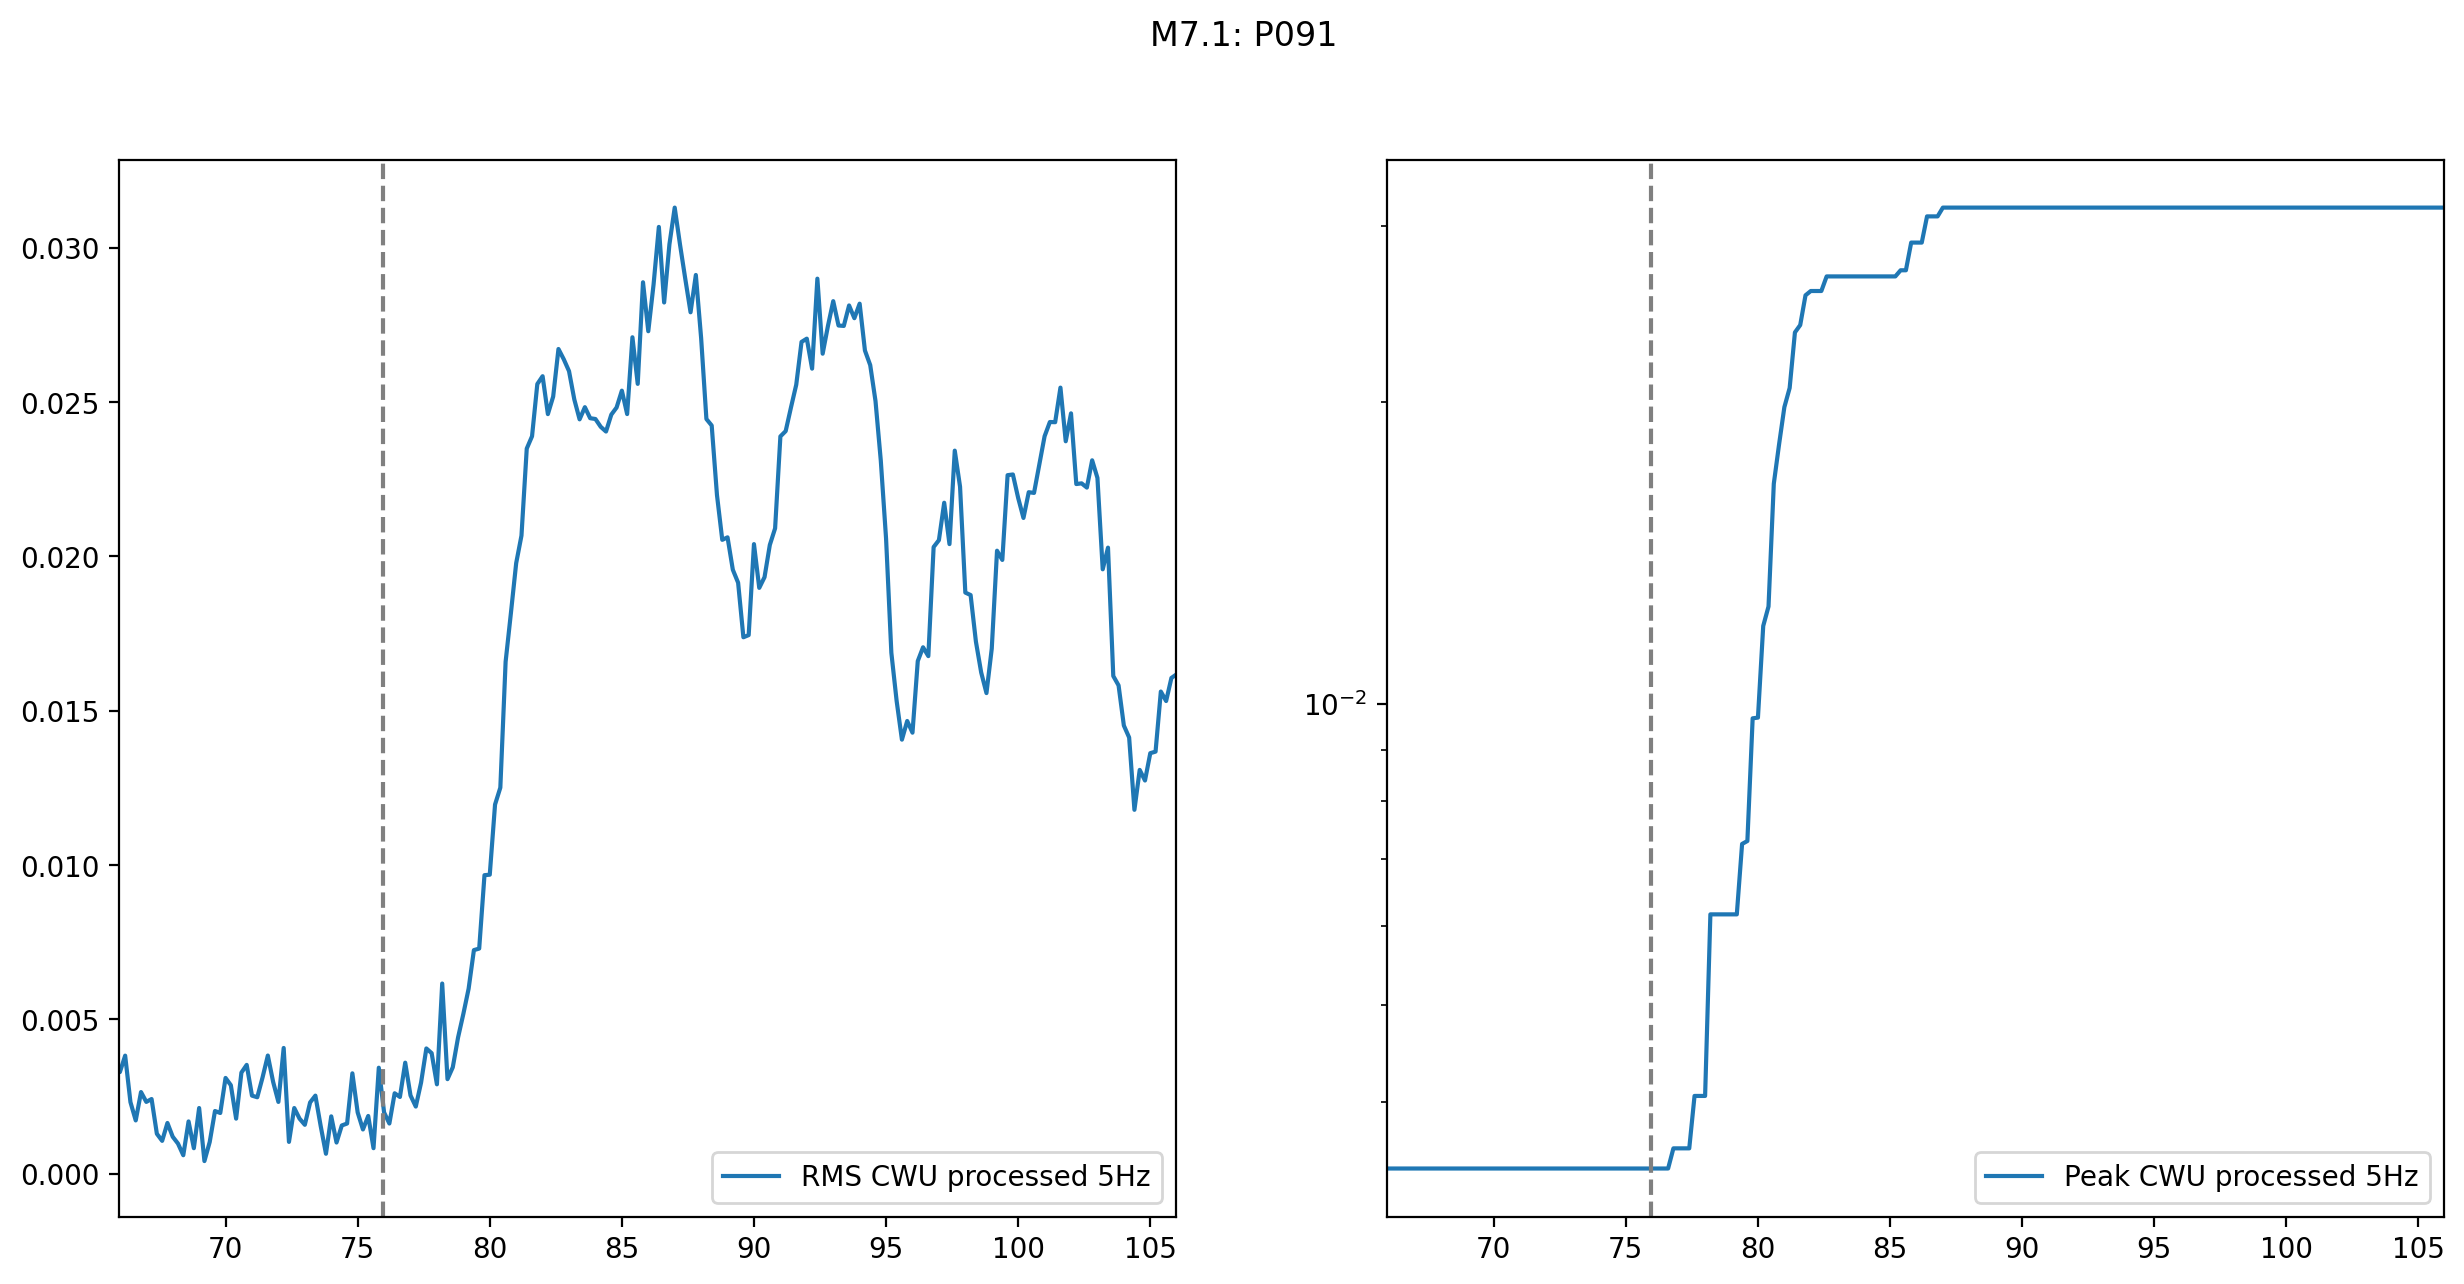

No published RT data for station p093


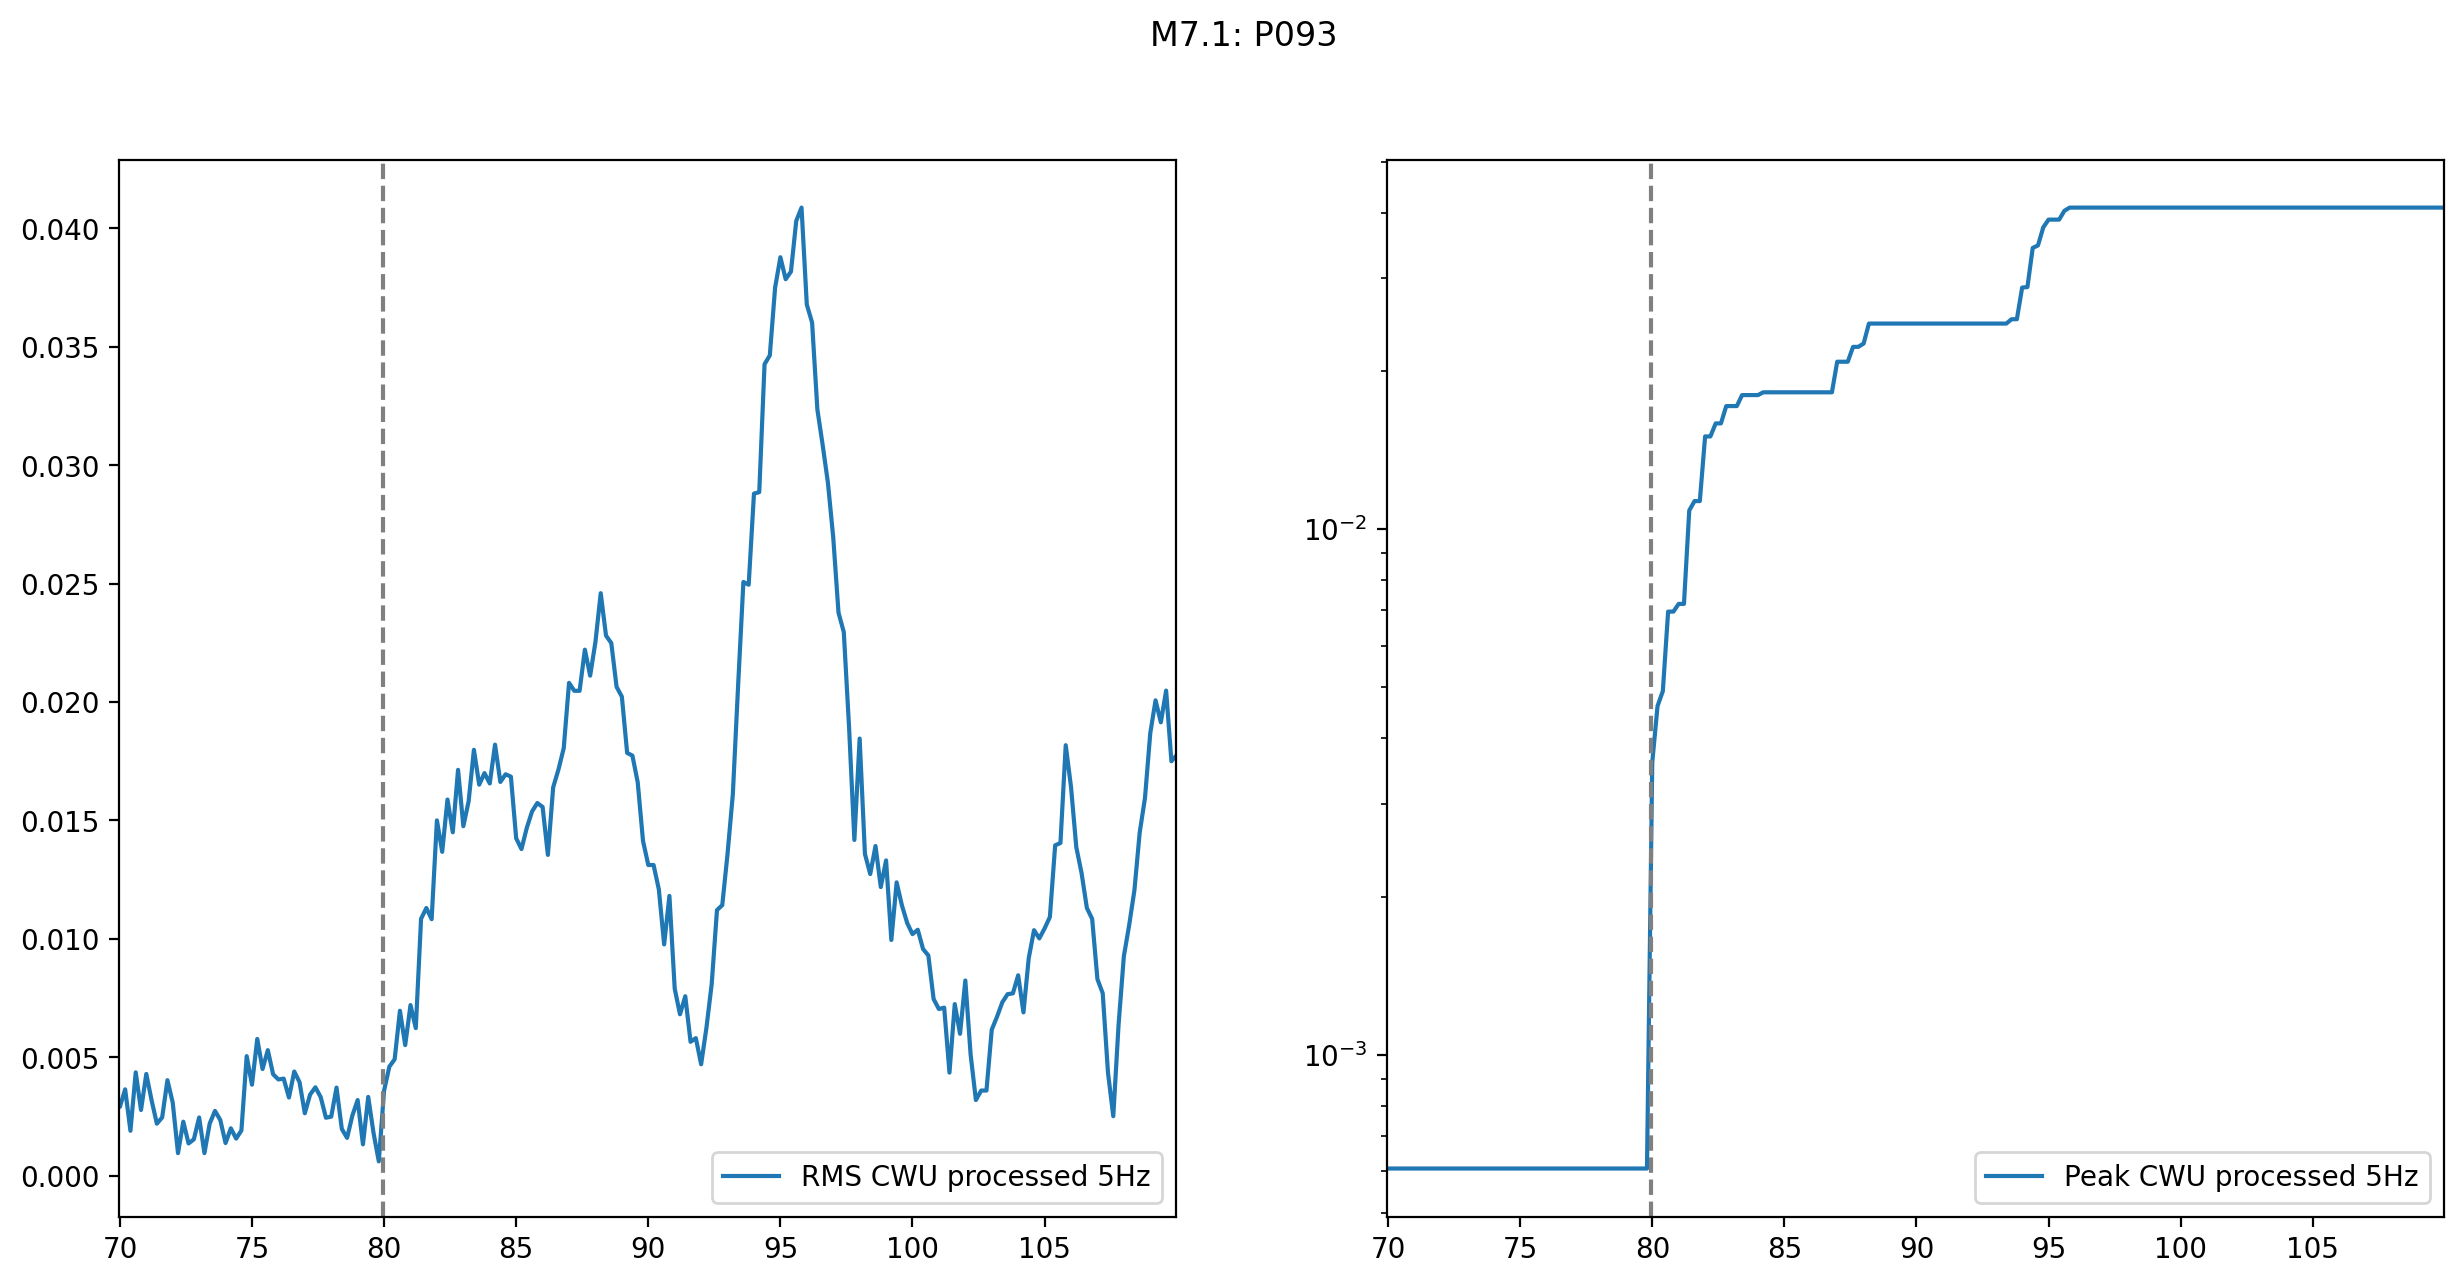

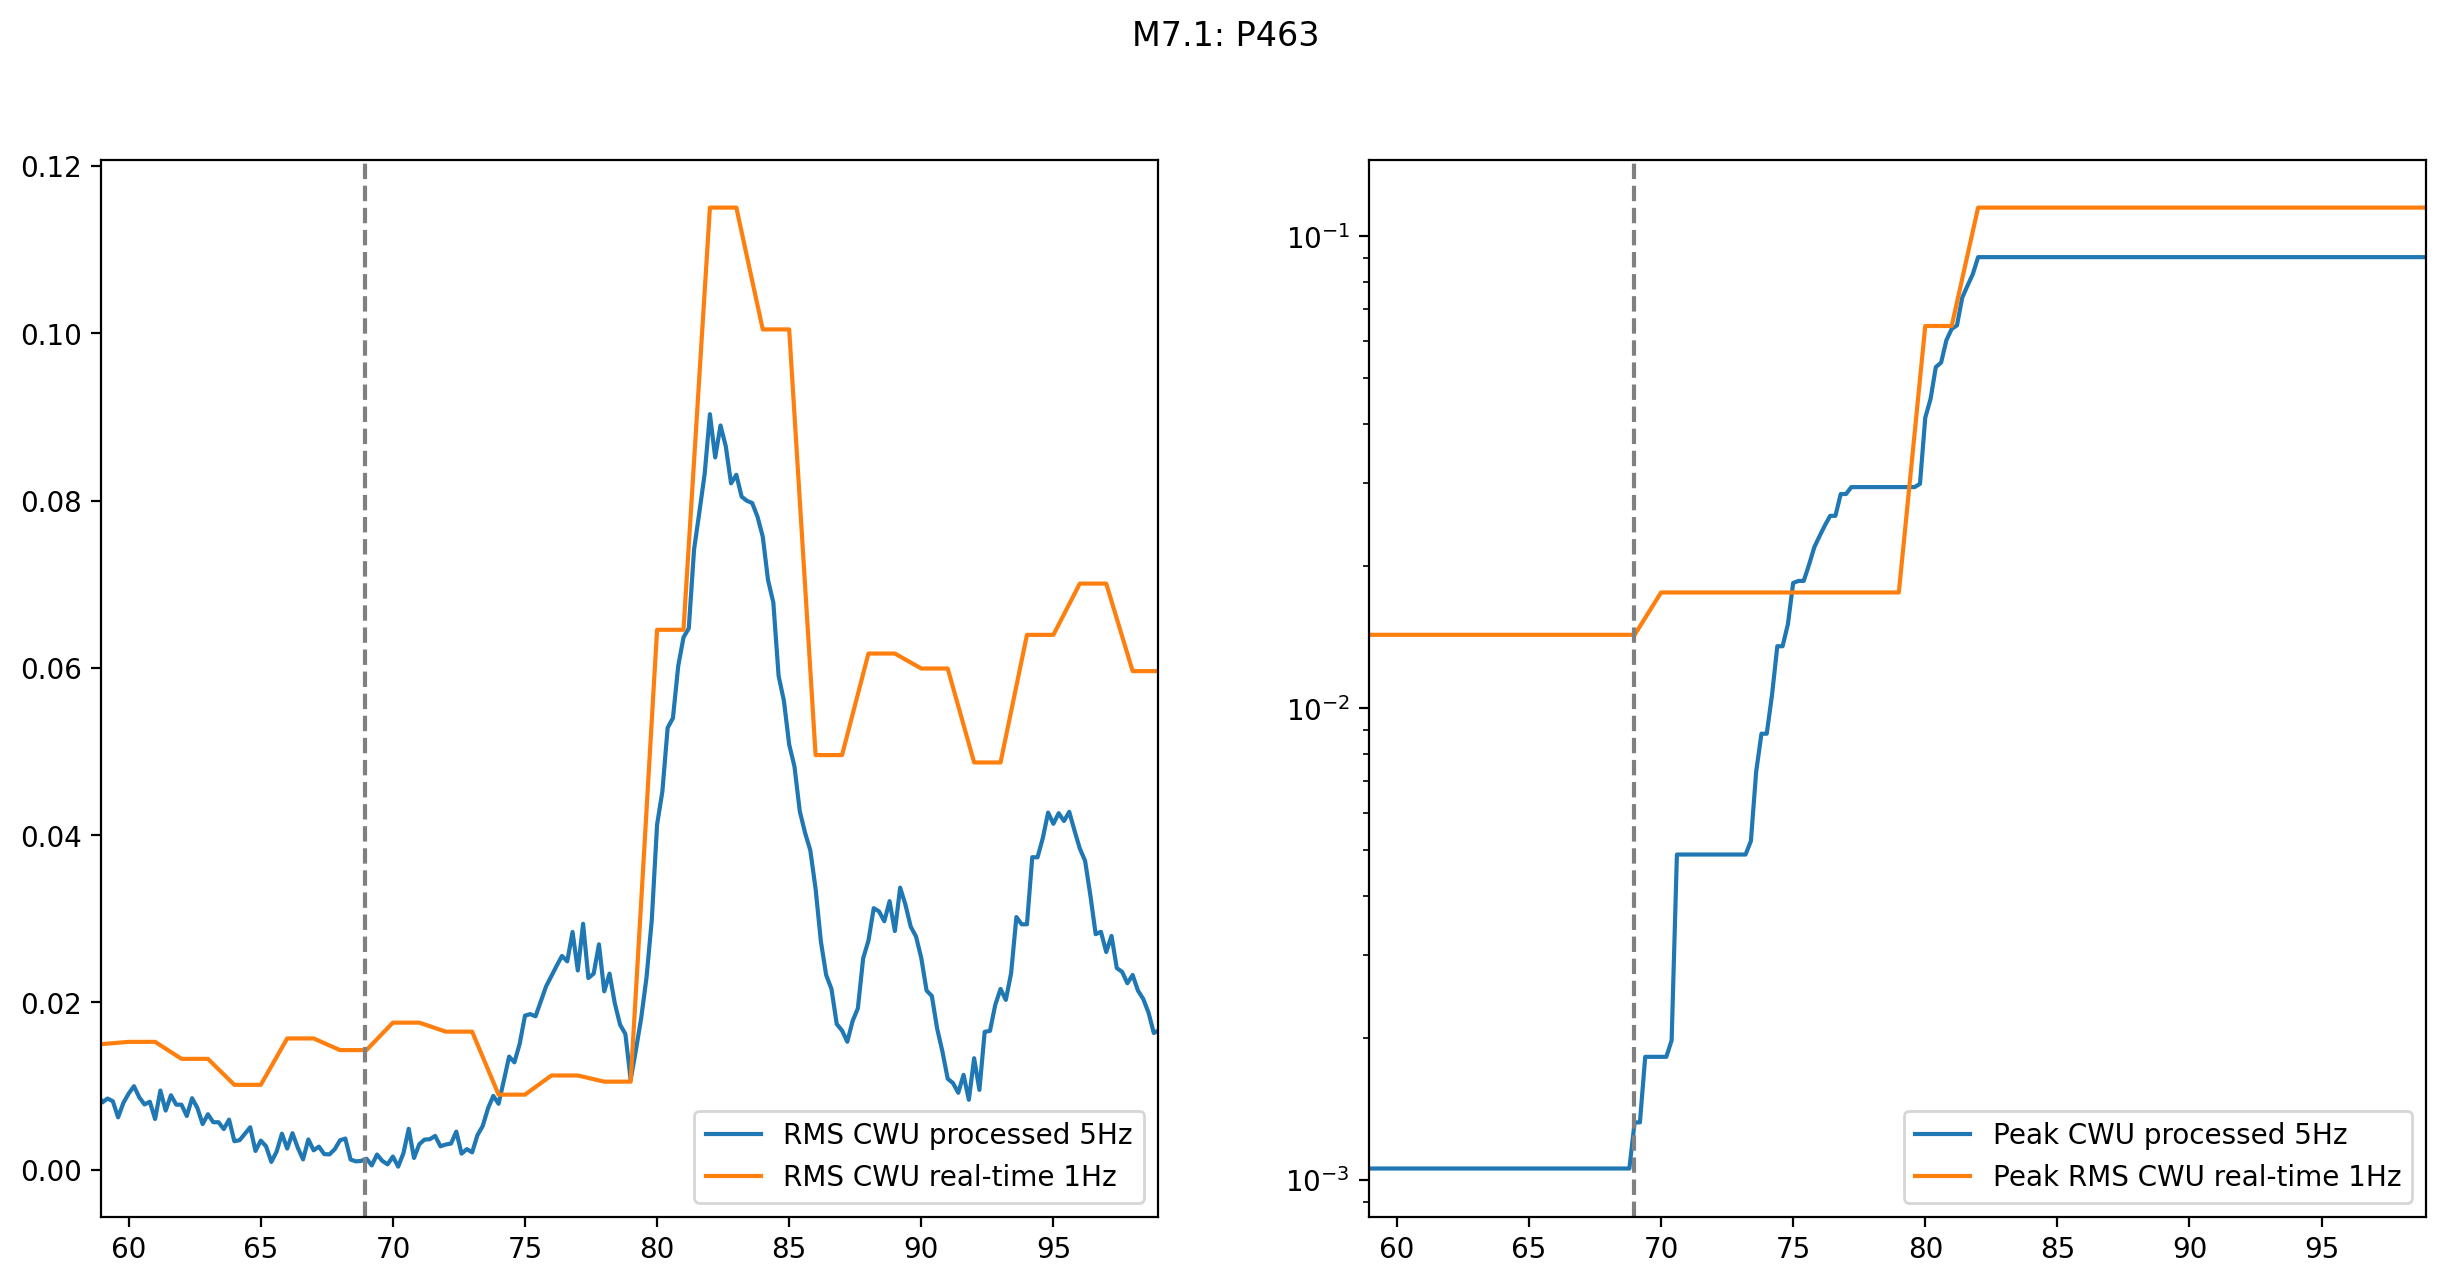

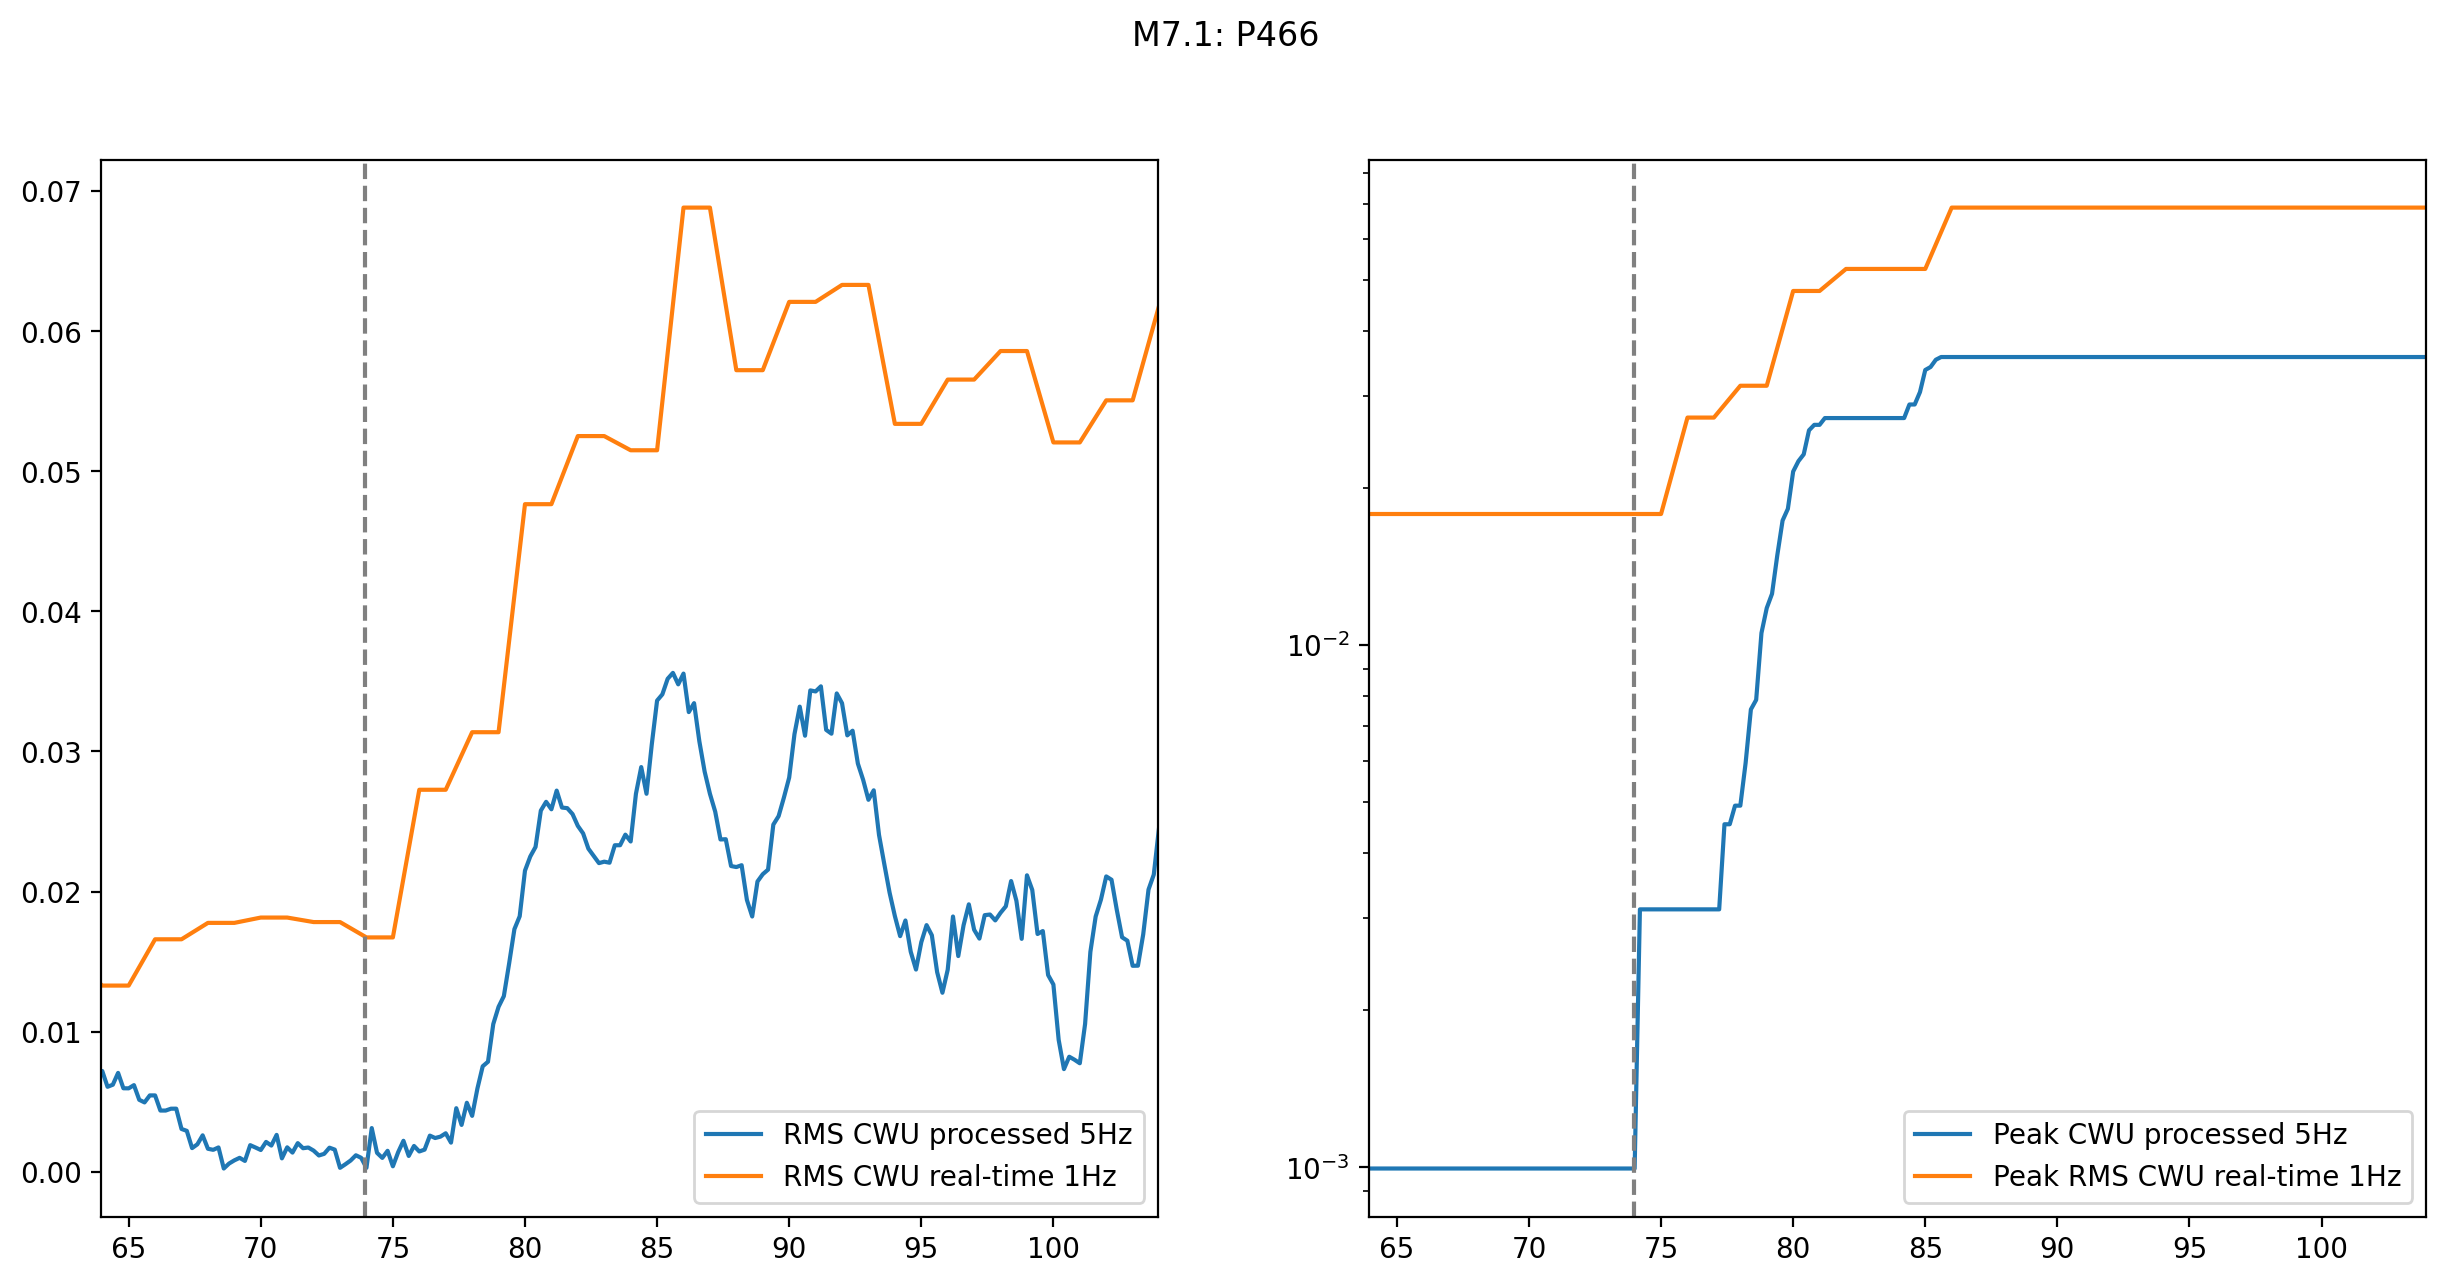

No published RT data for station p467


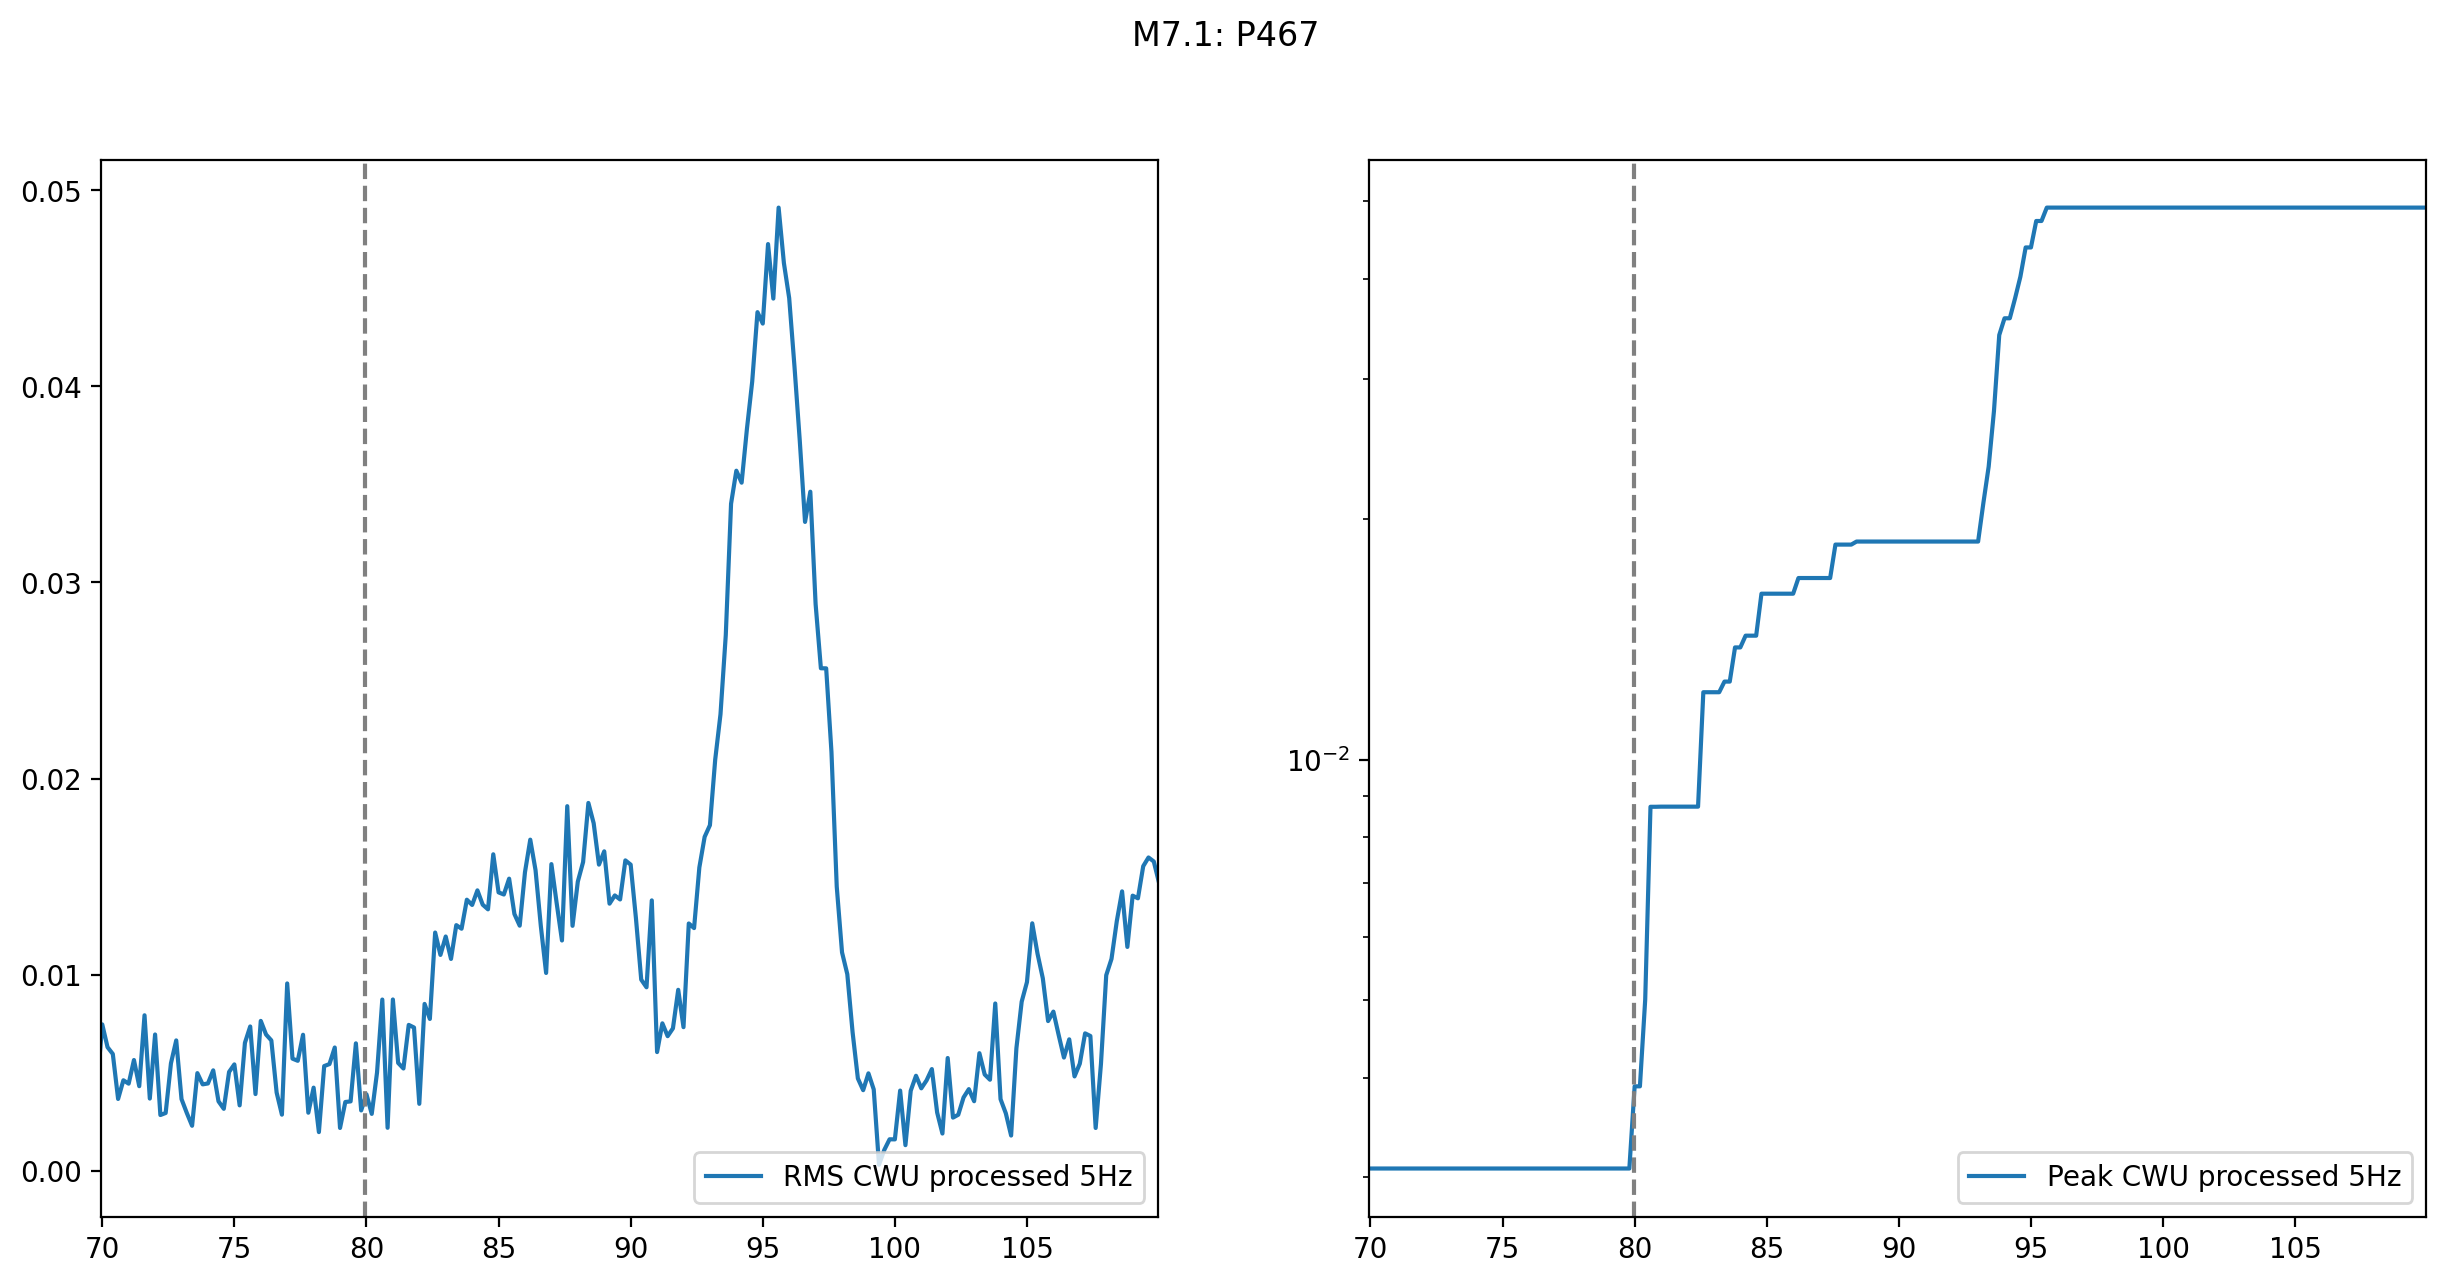

No published RT data for station p570


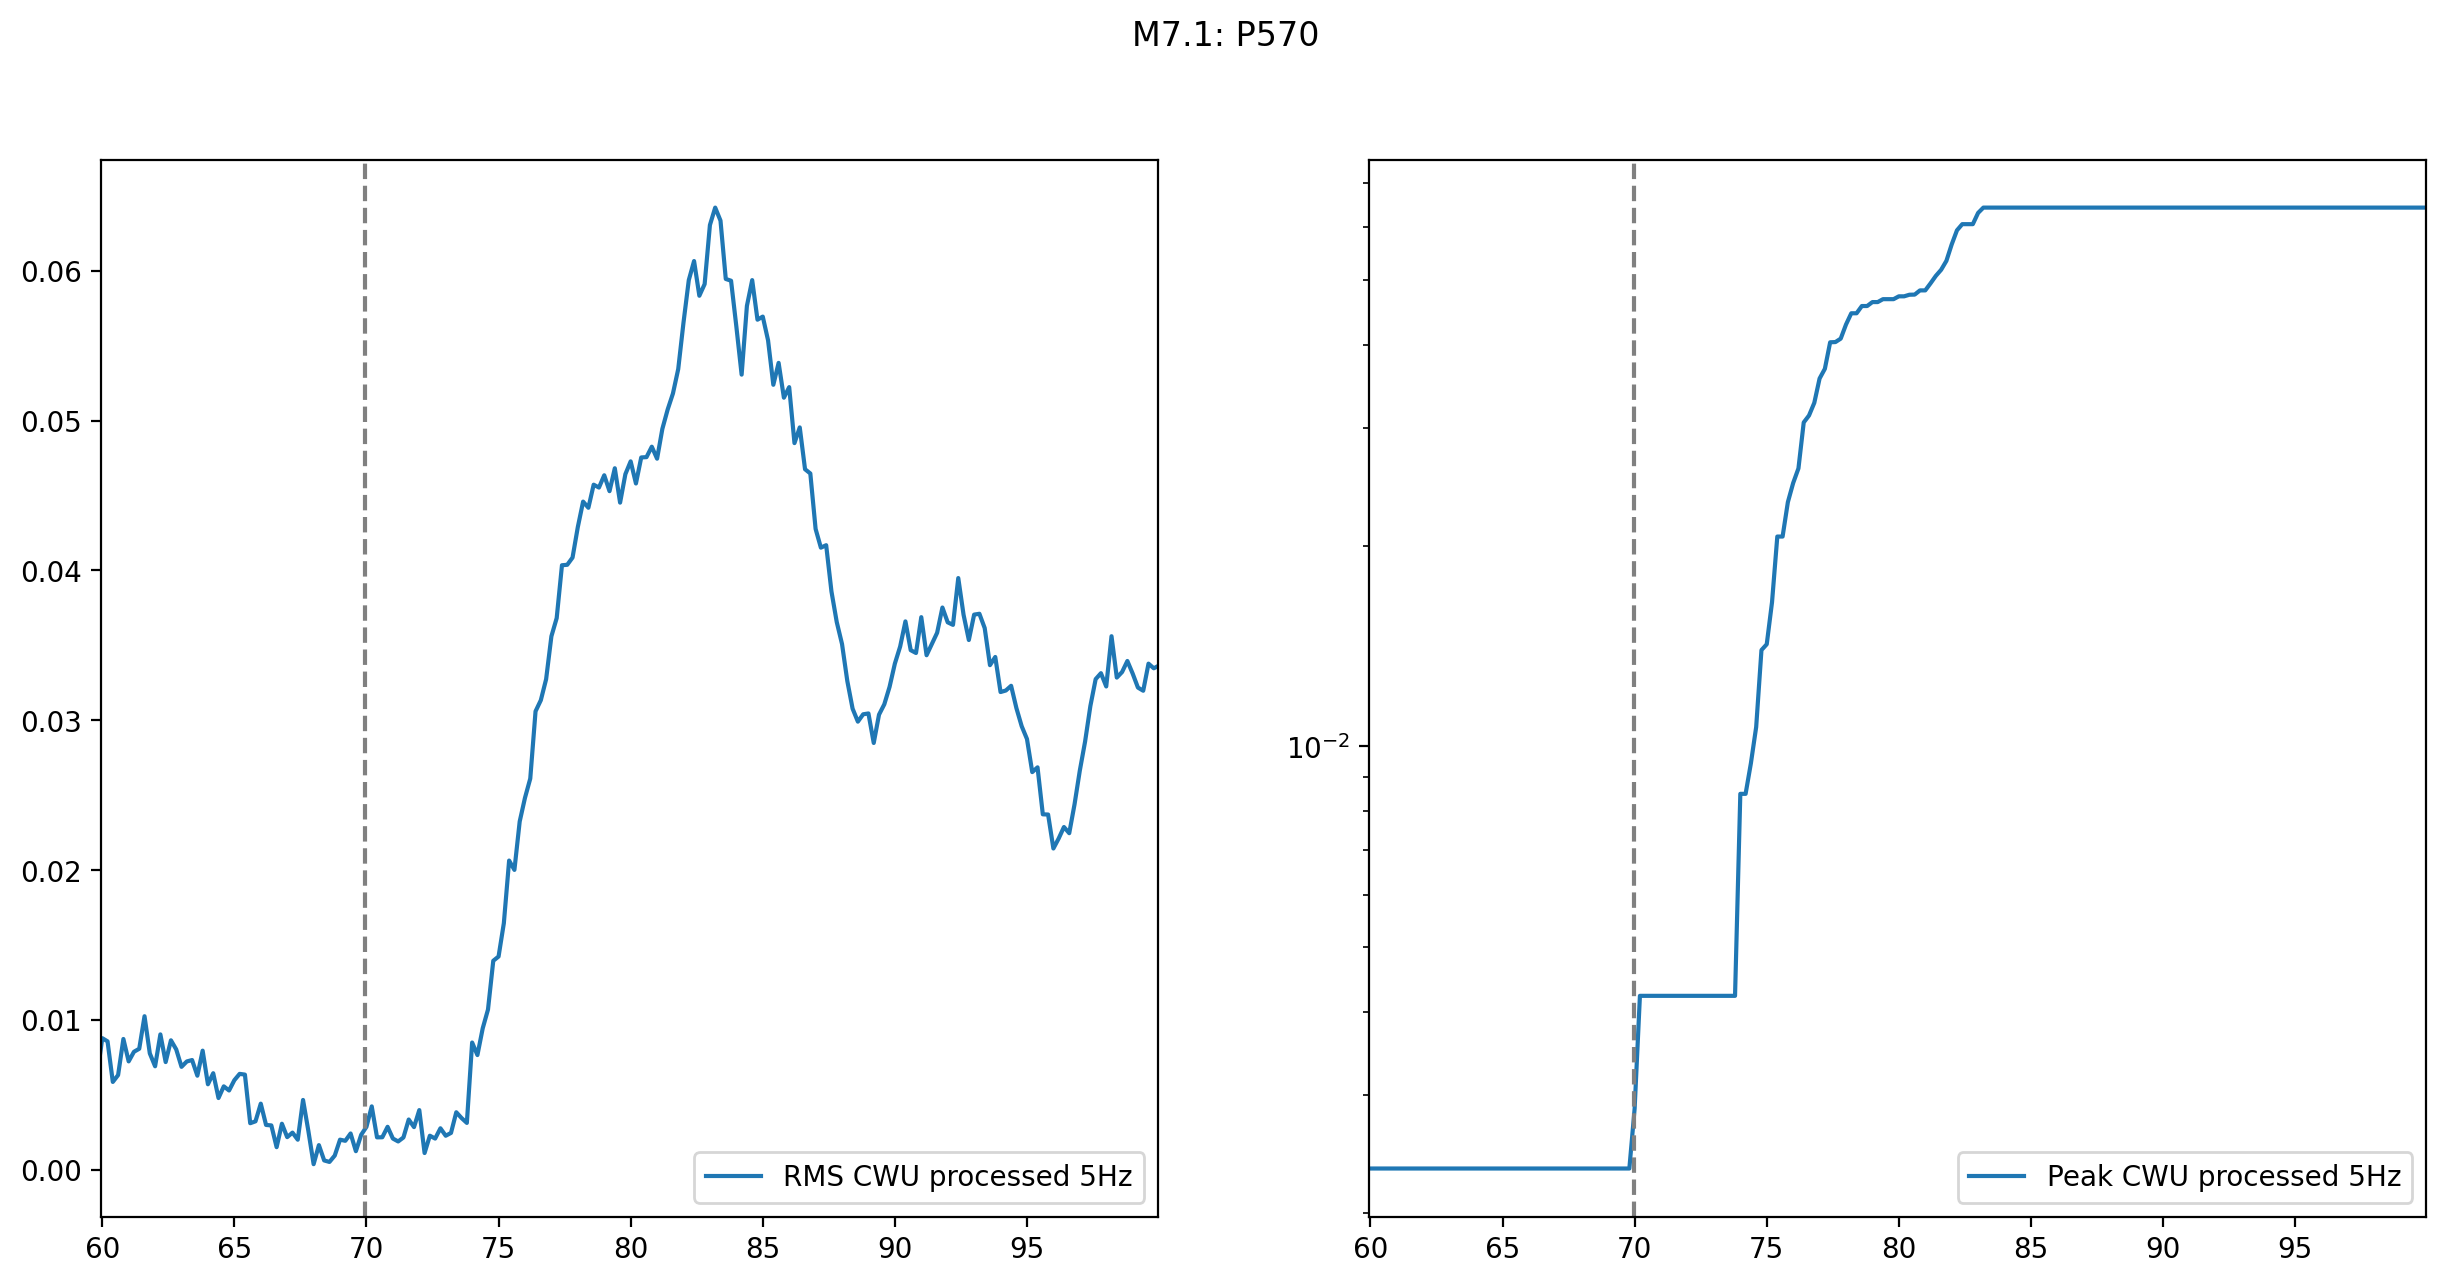

No published RT data for station p579


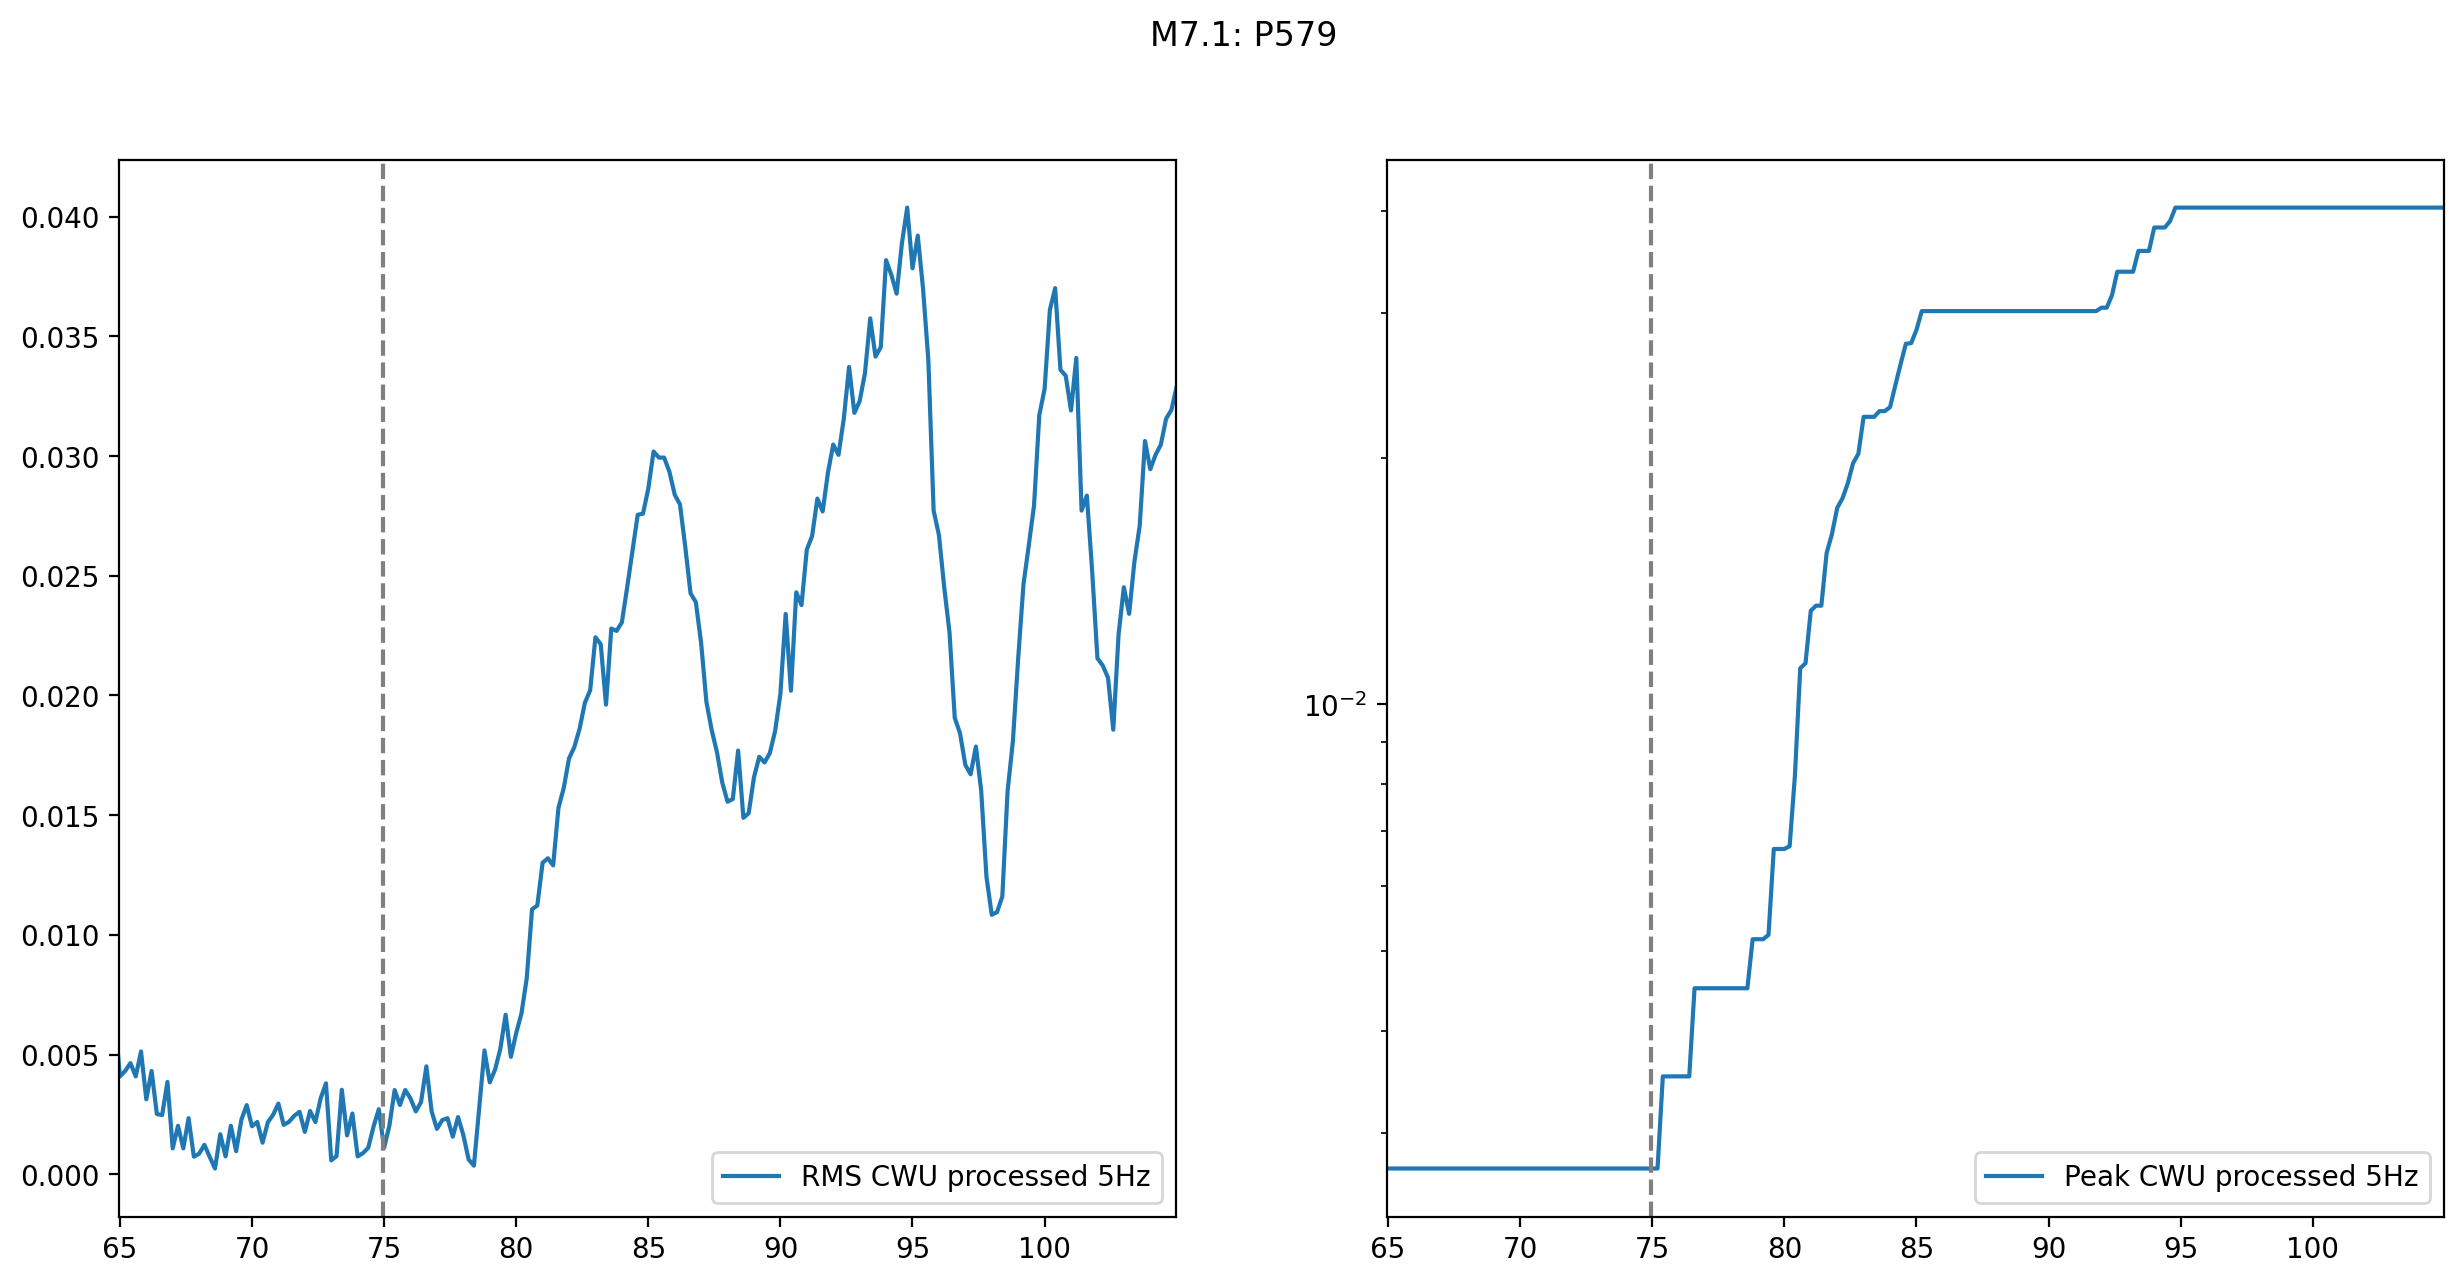

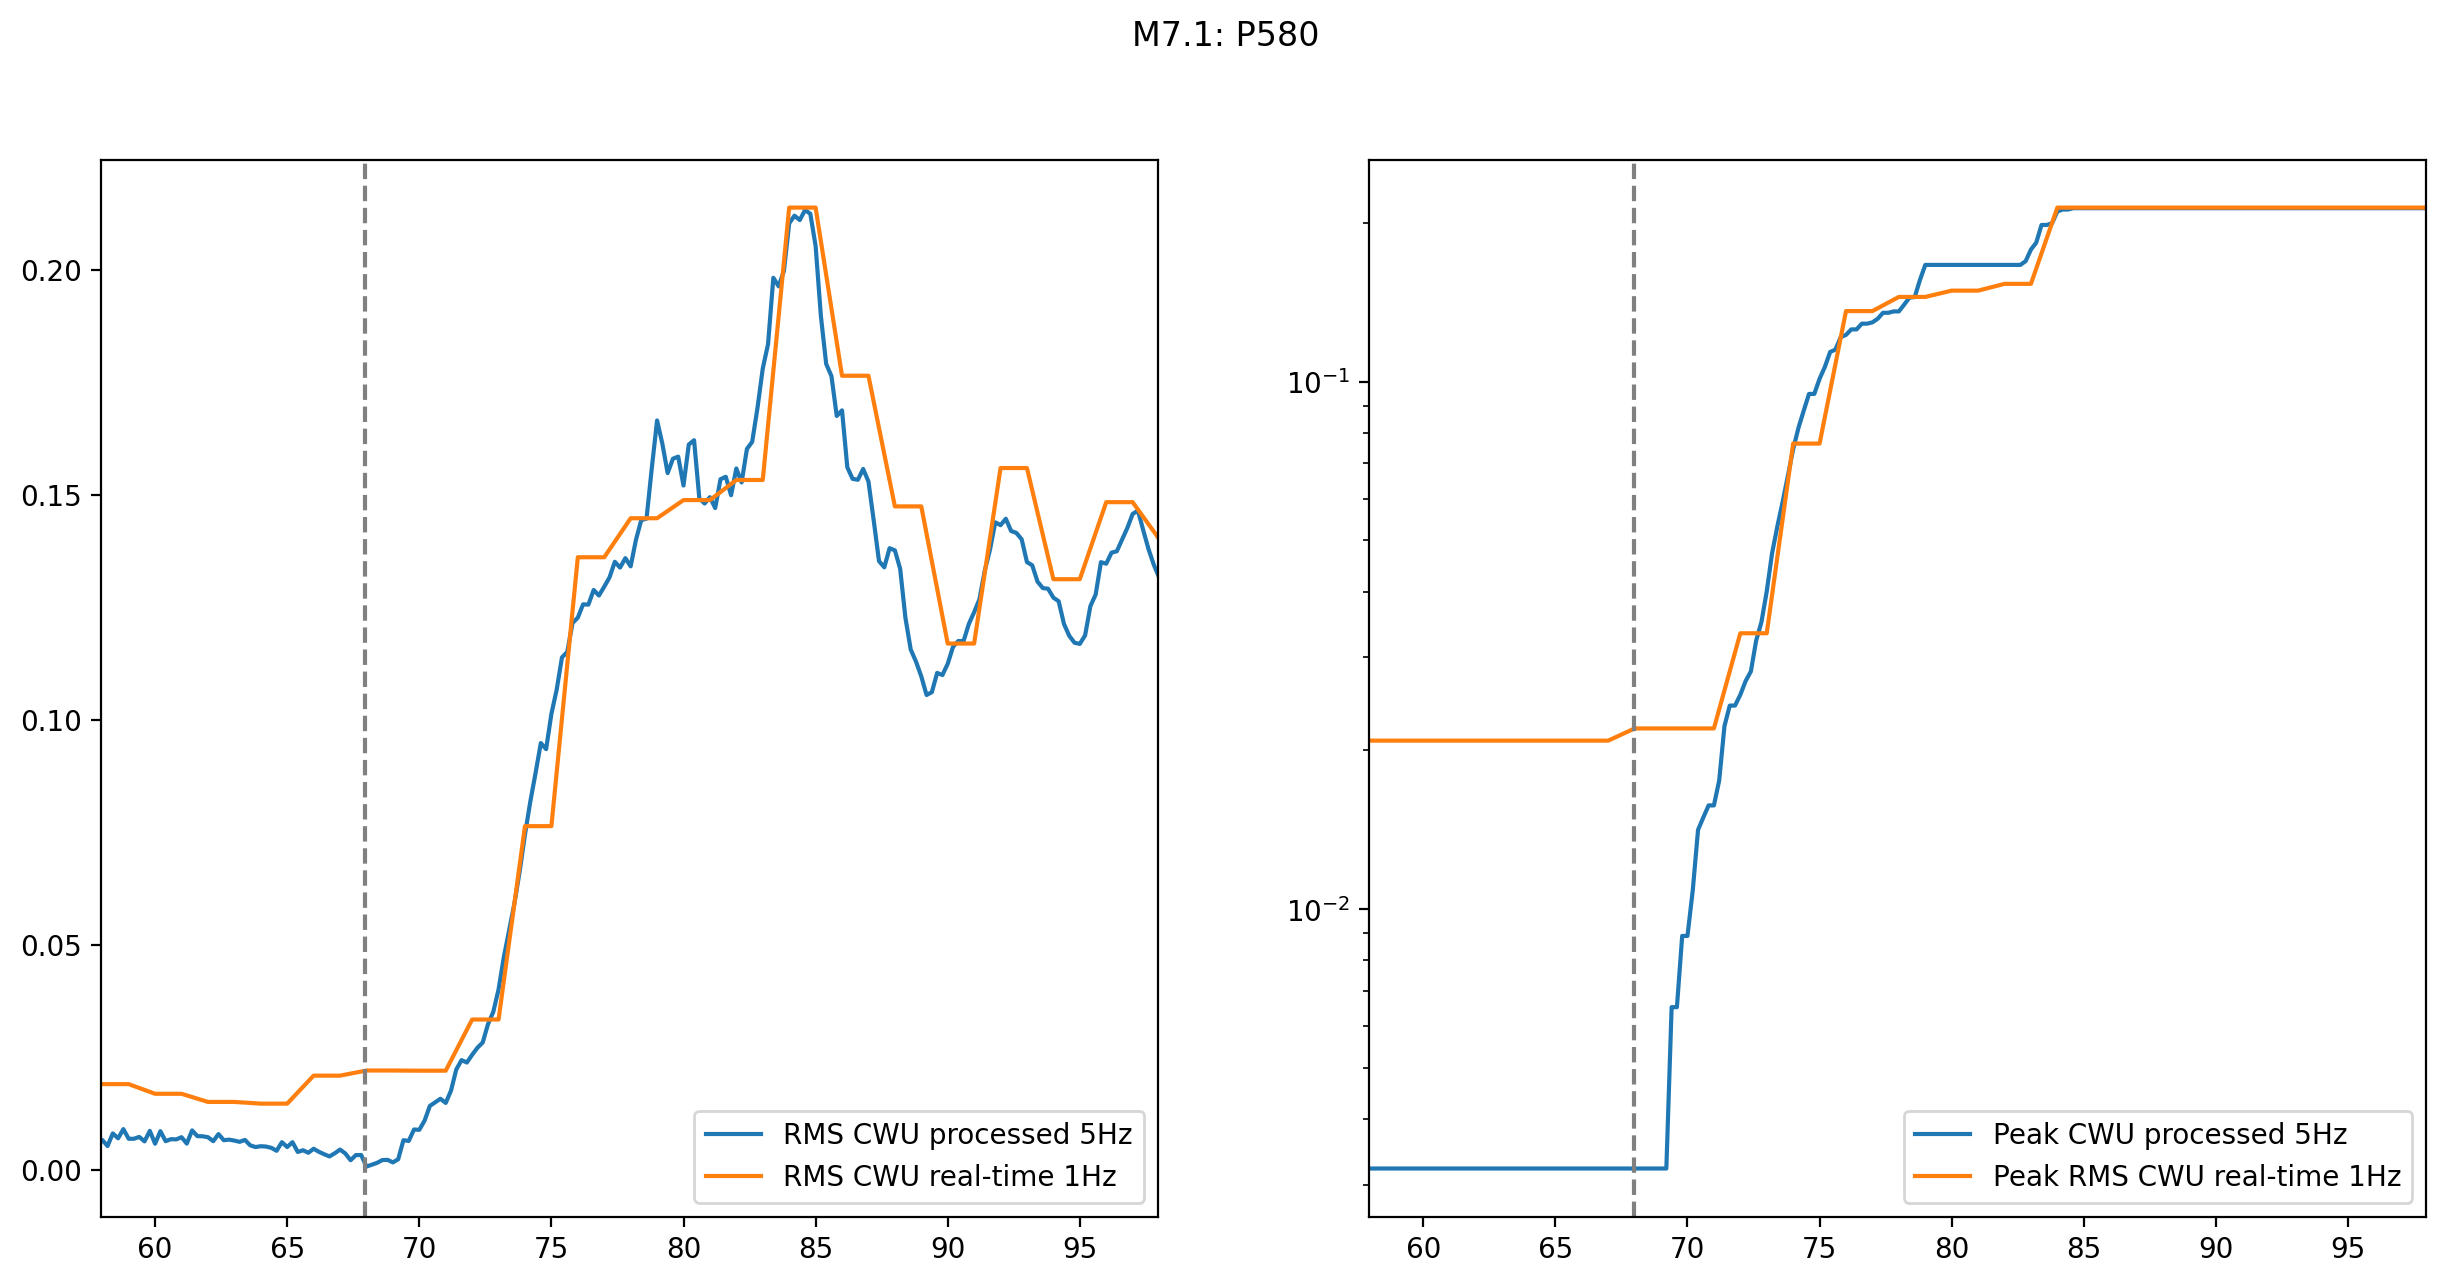

No published RT data for station p590


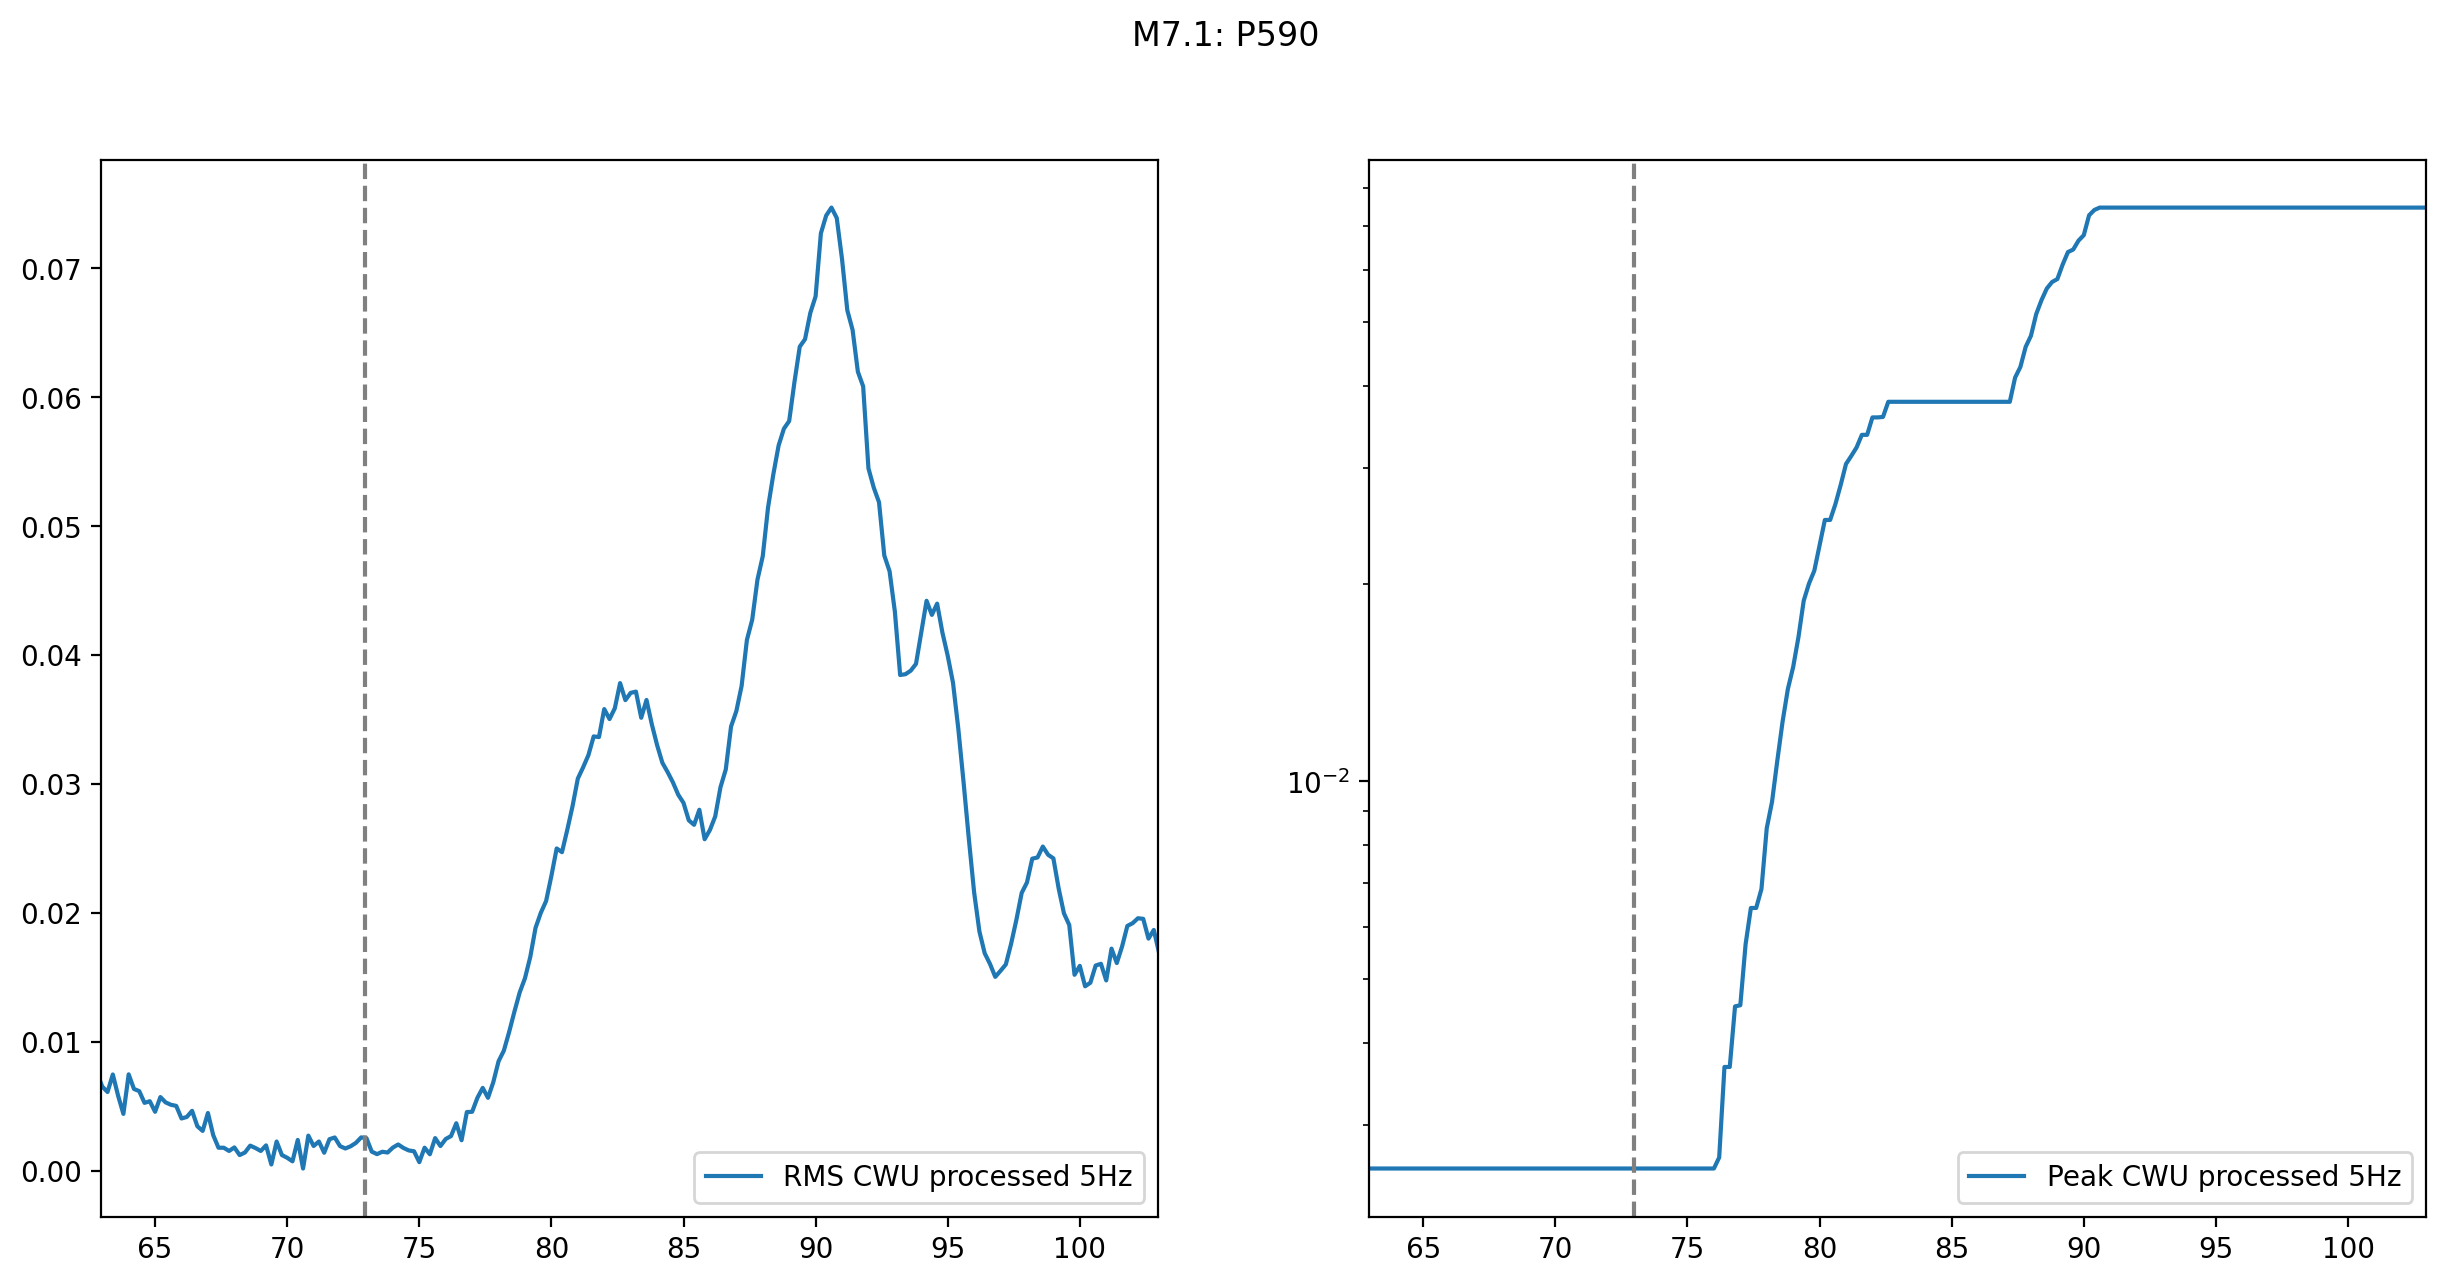

No published RT data for station p592


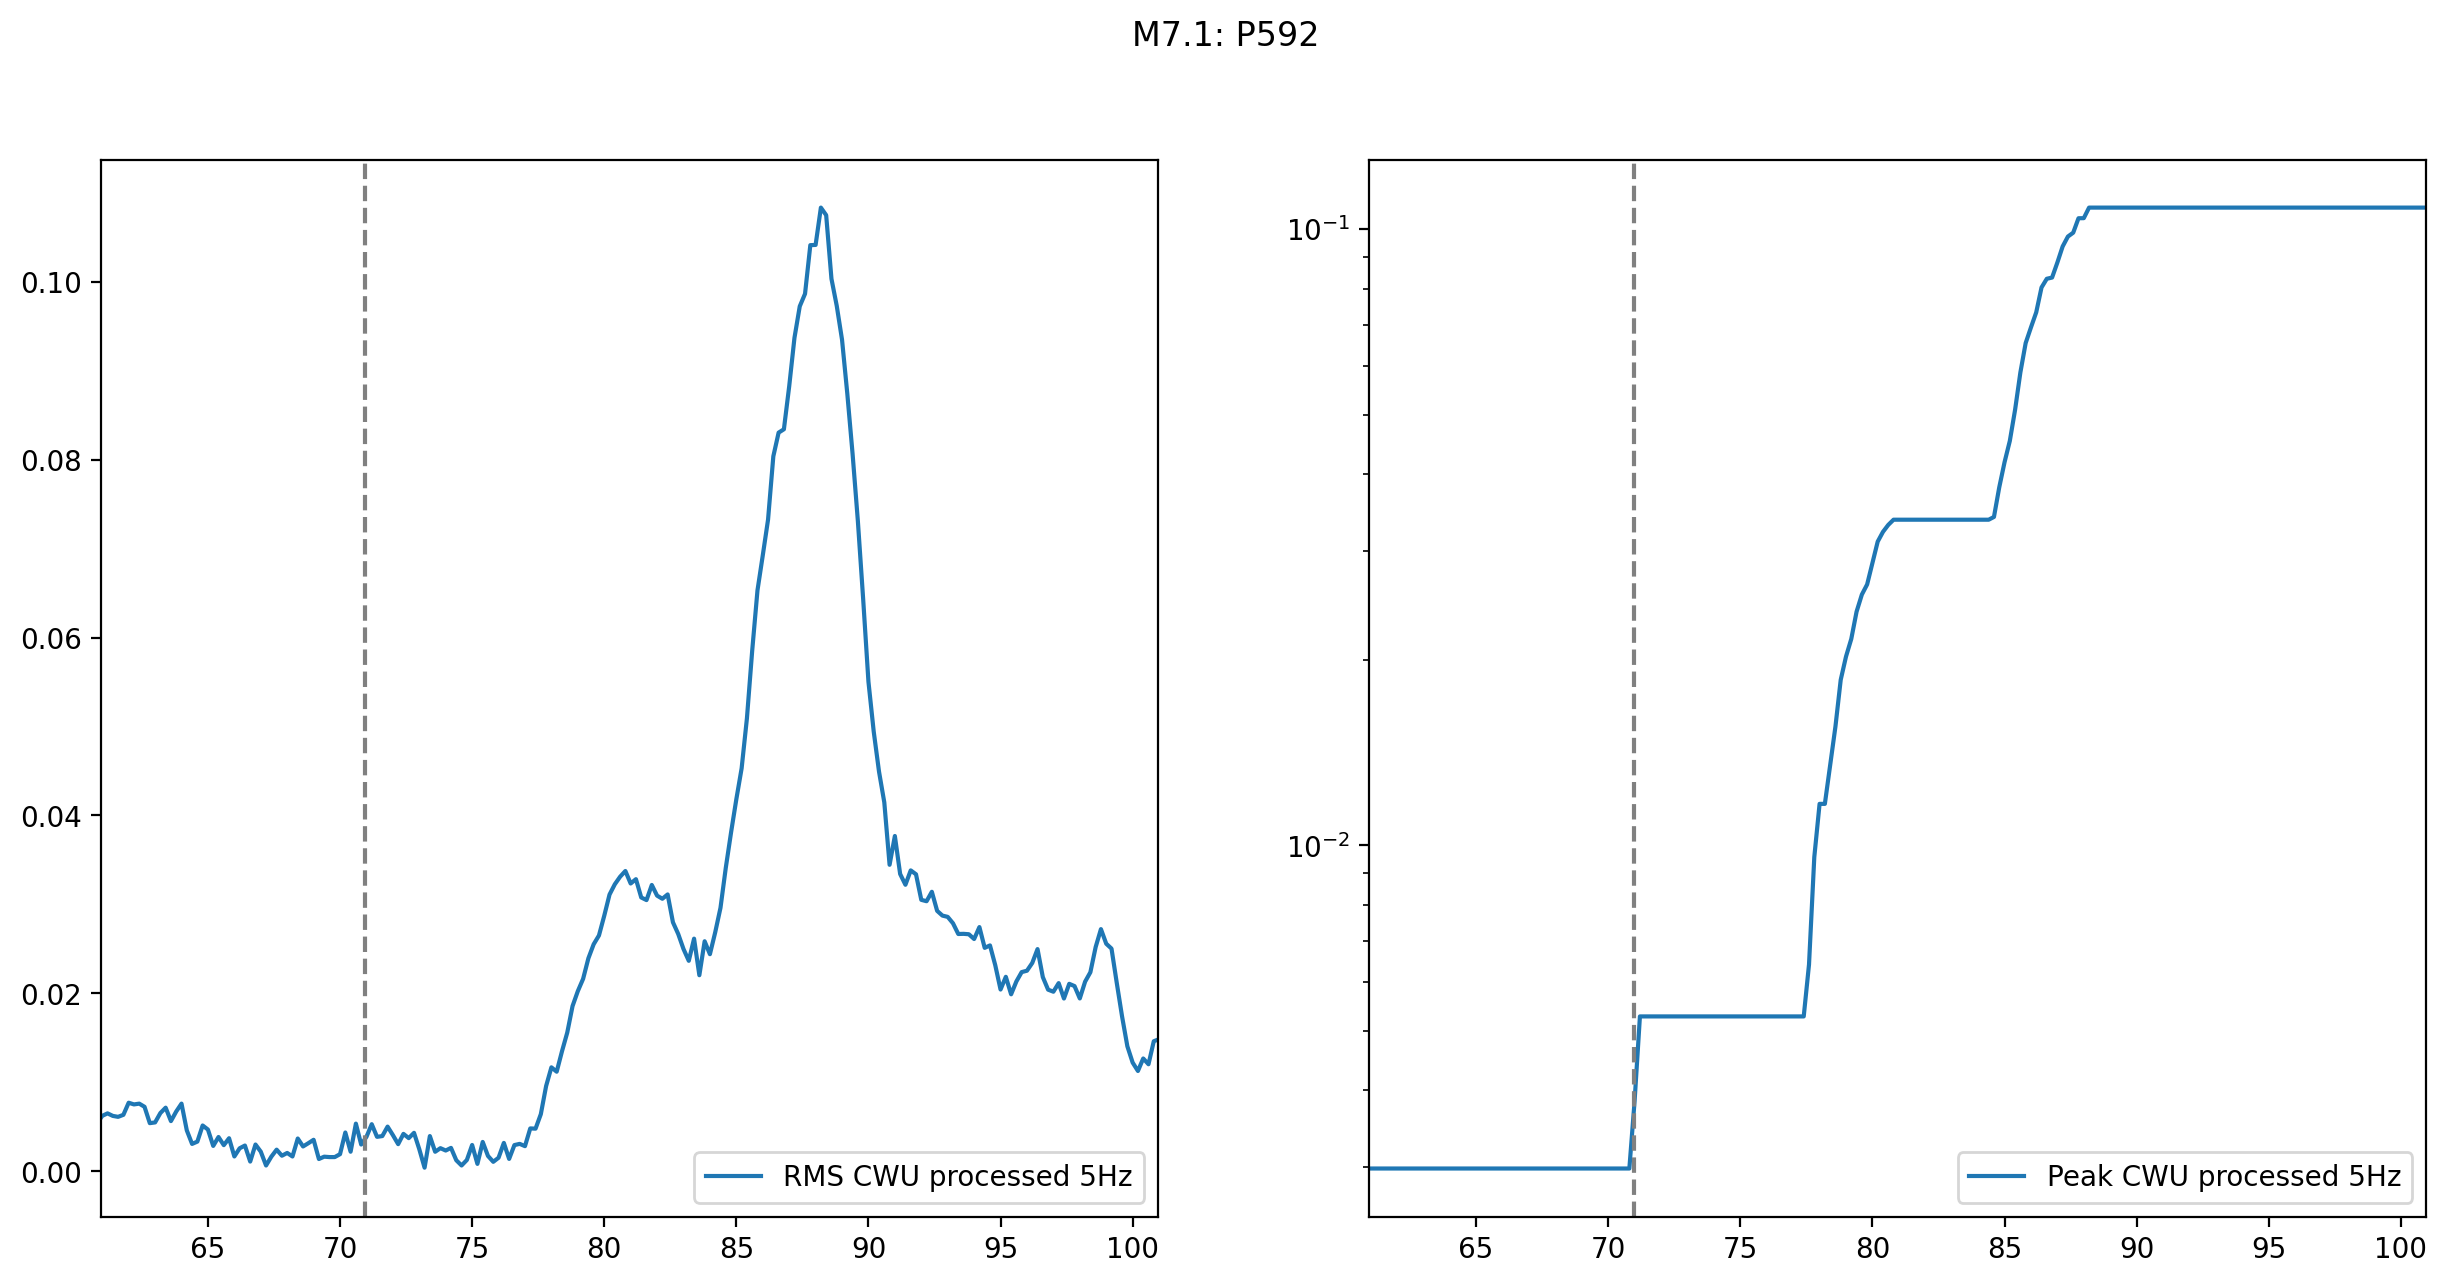

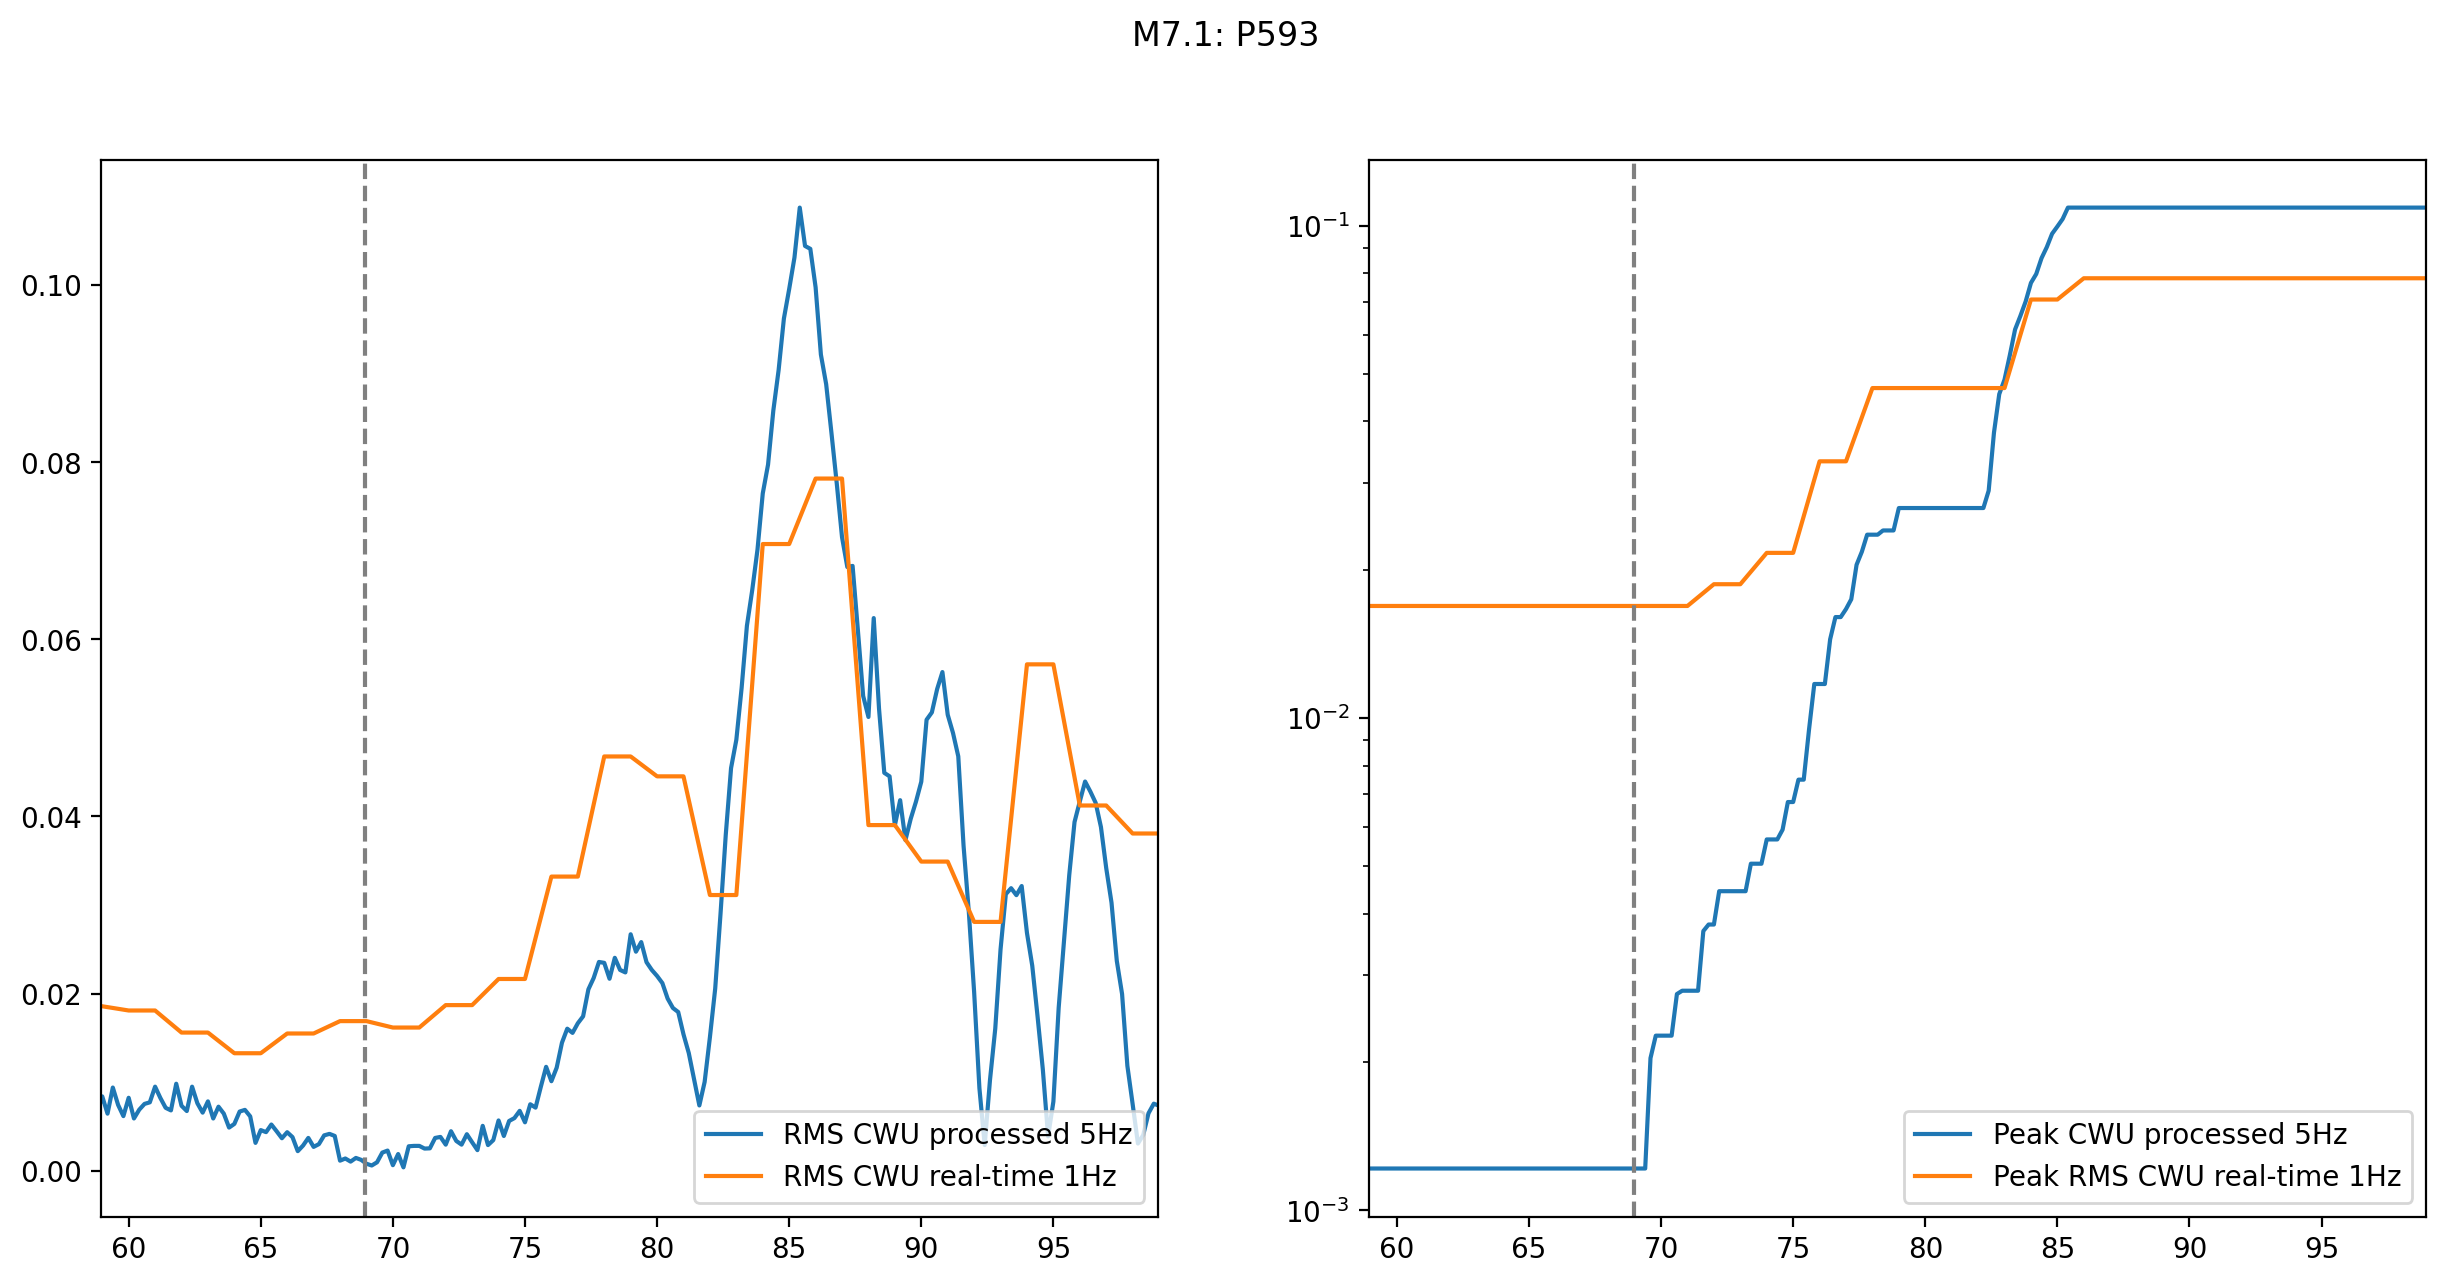

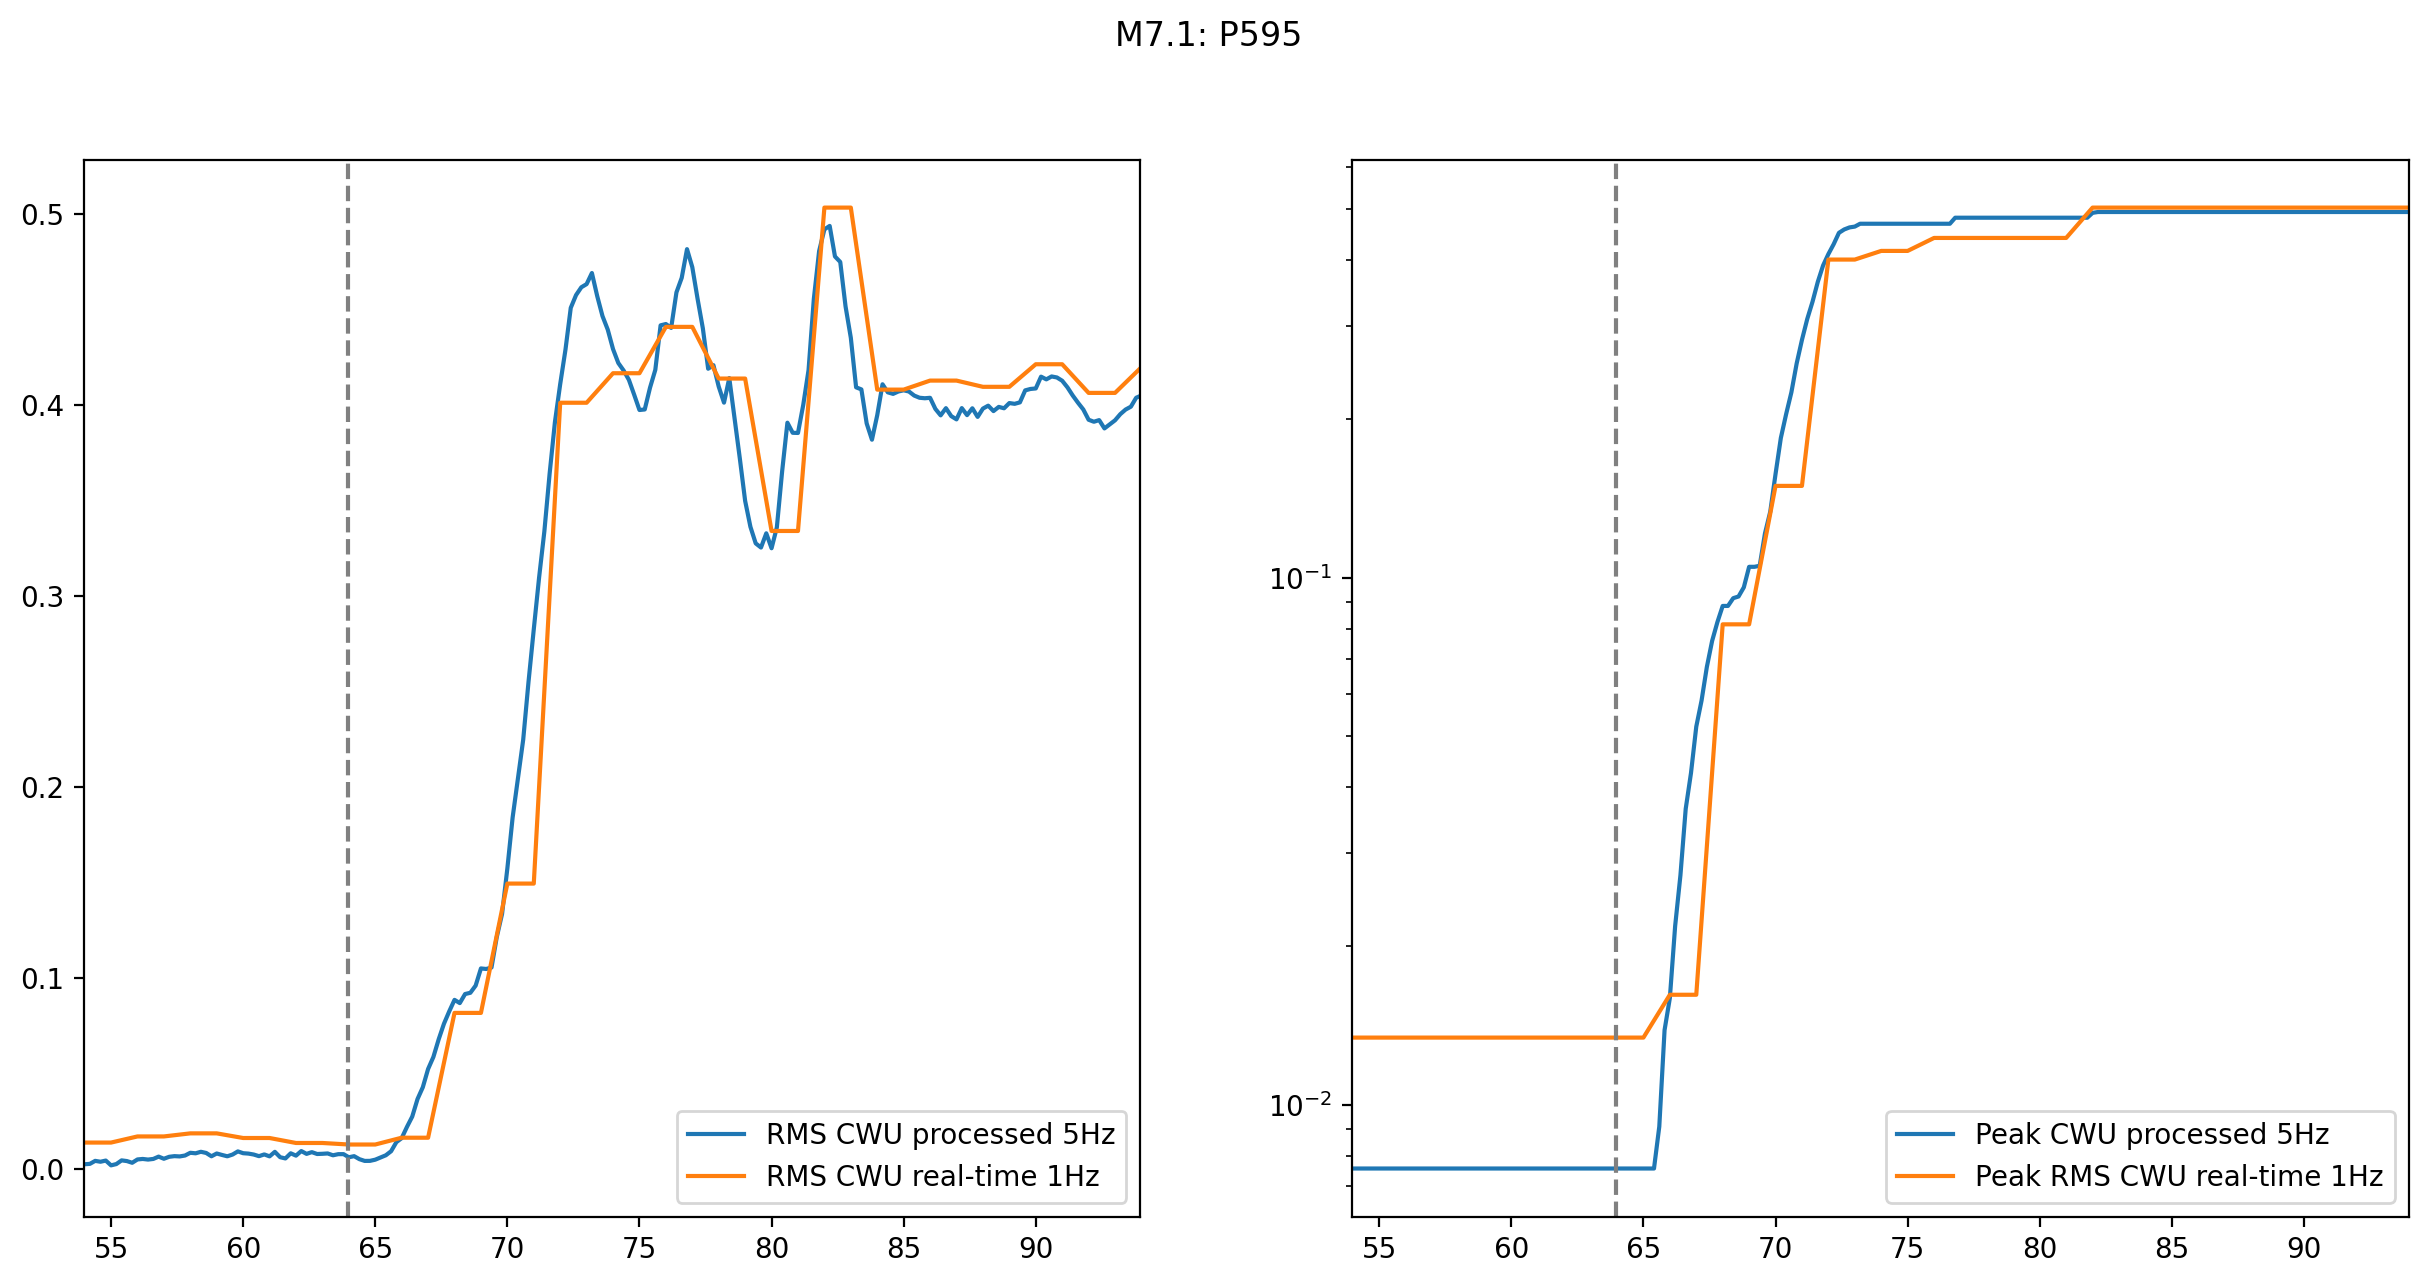

No published RT data for station p615


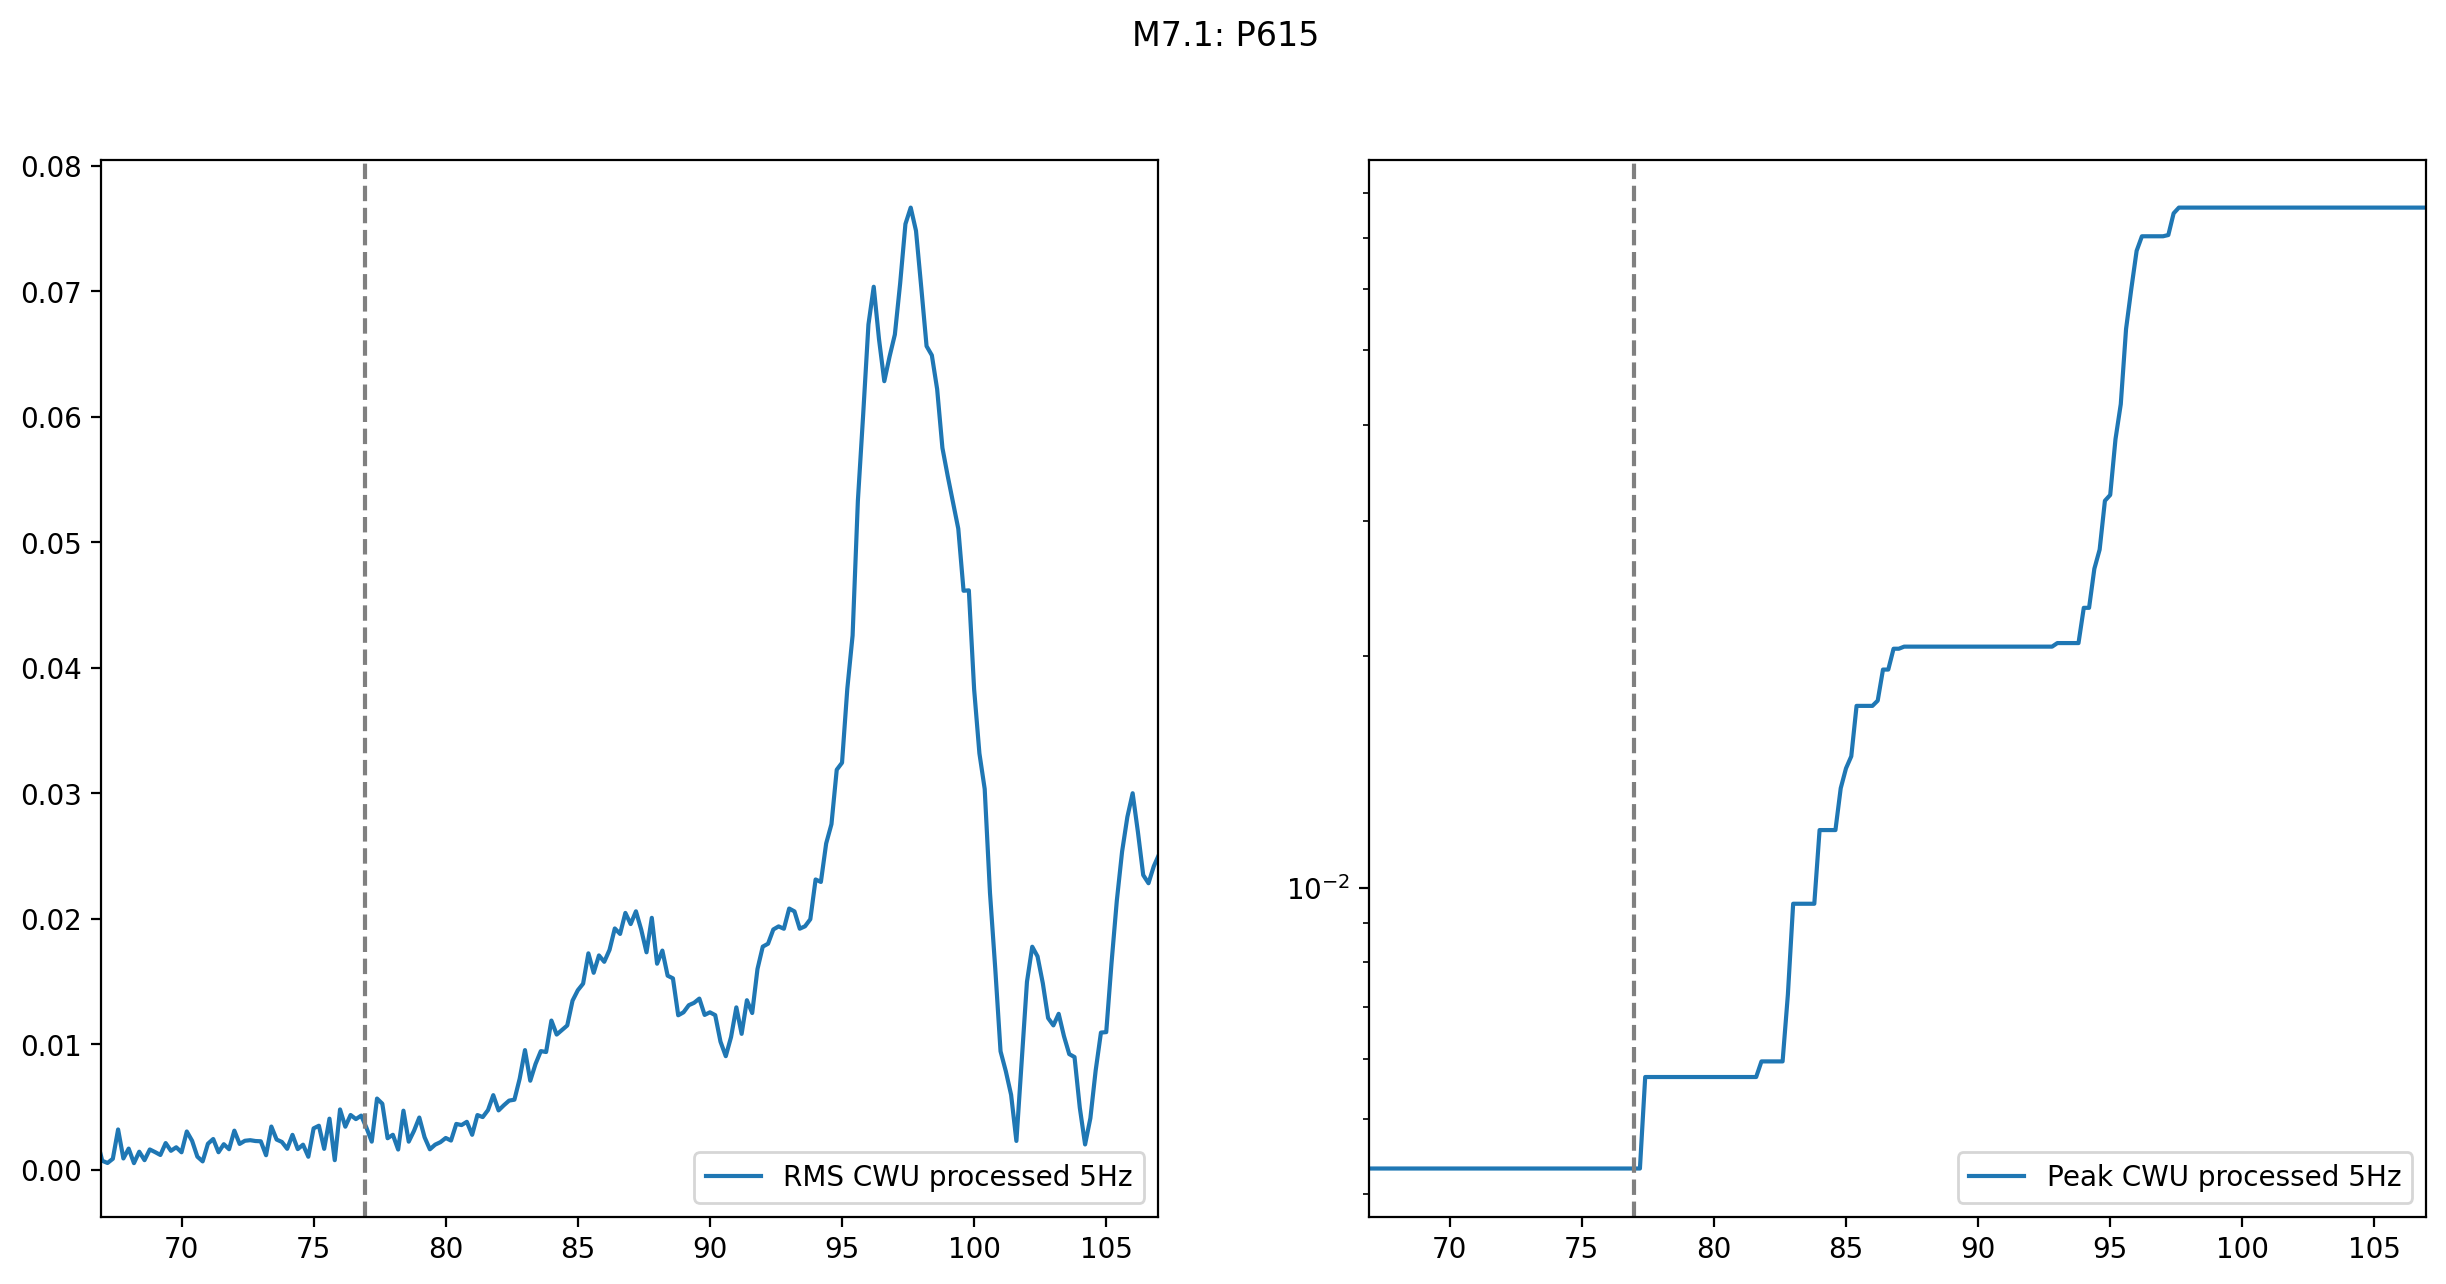

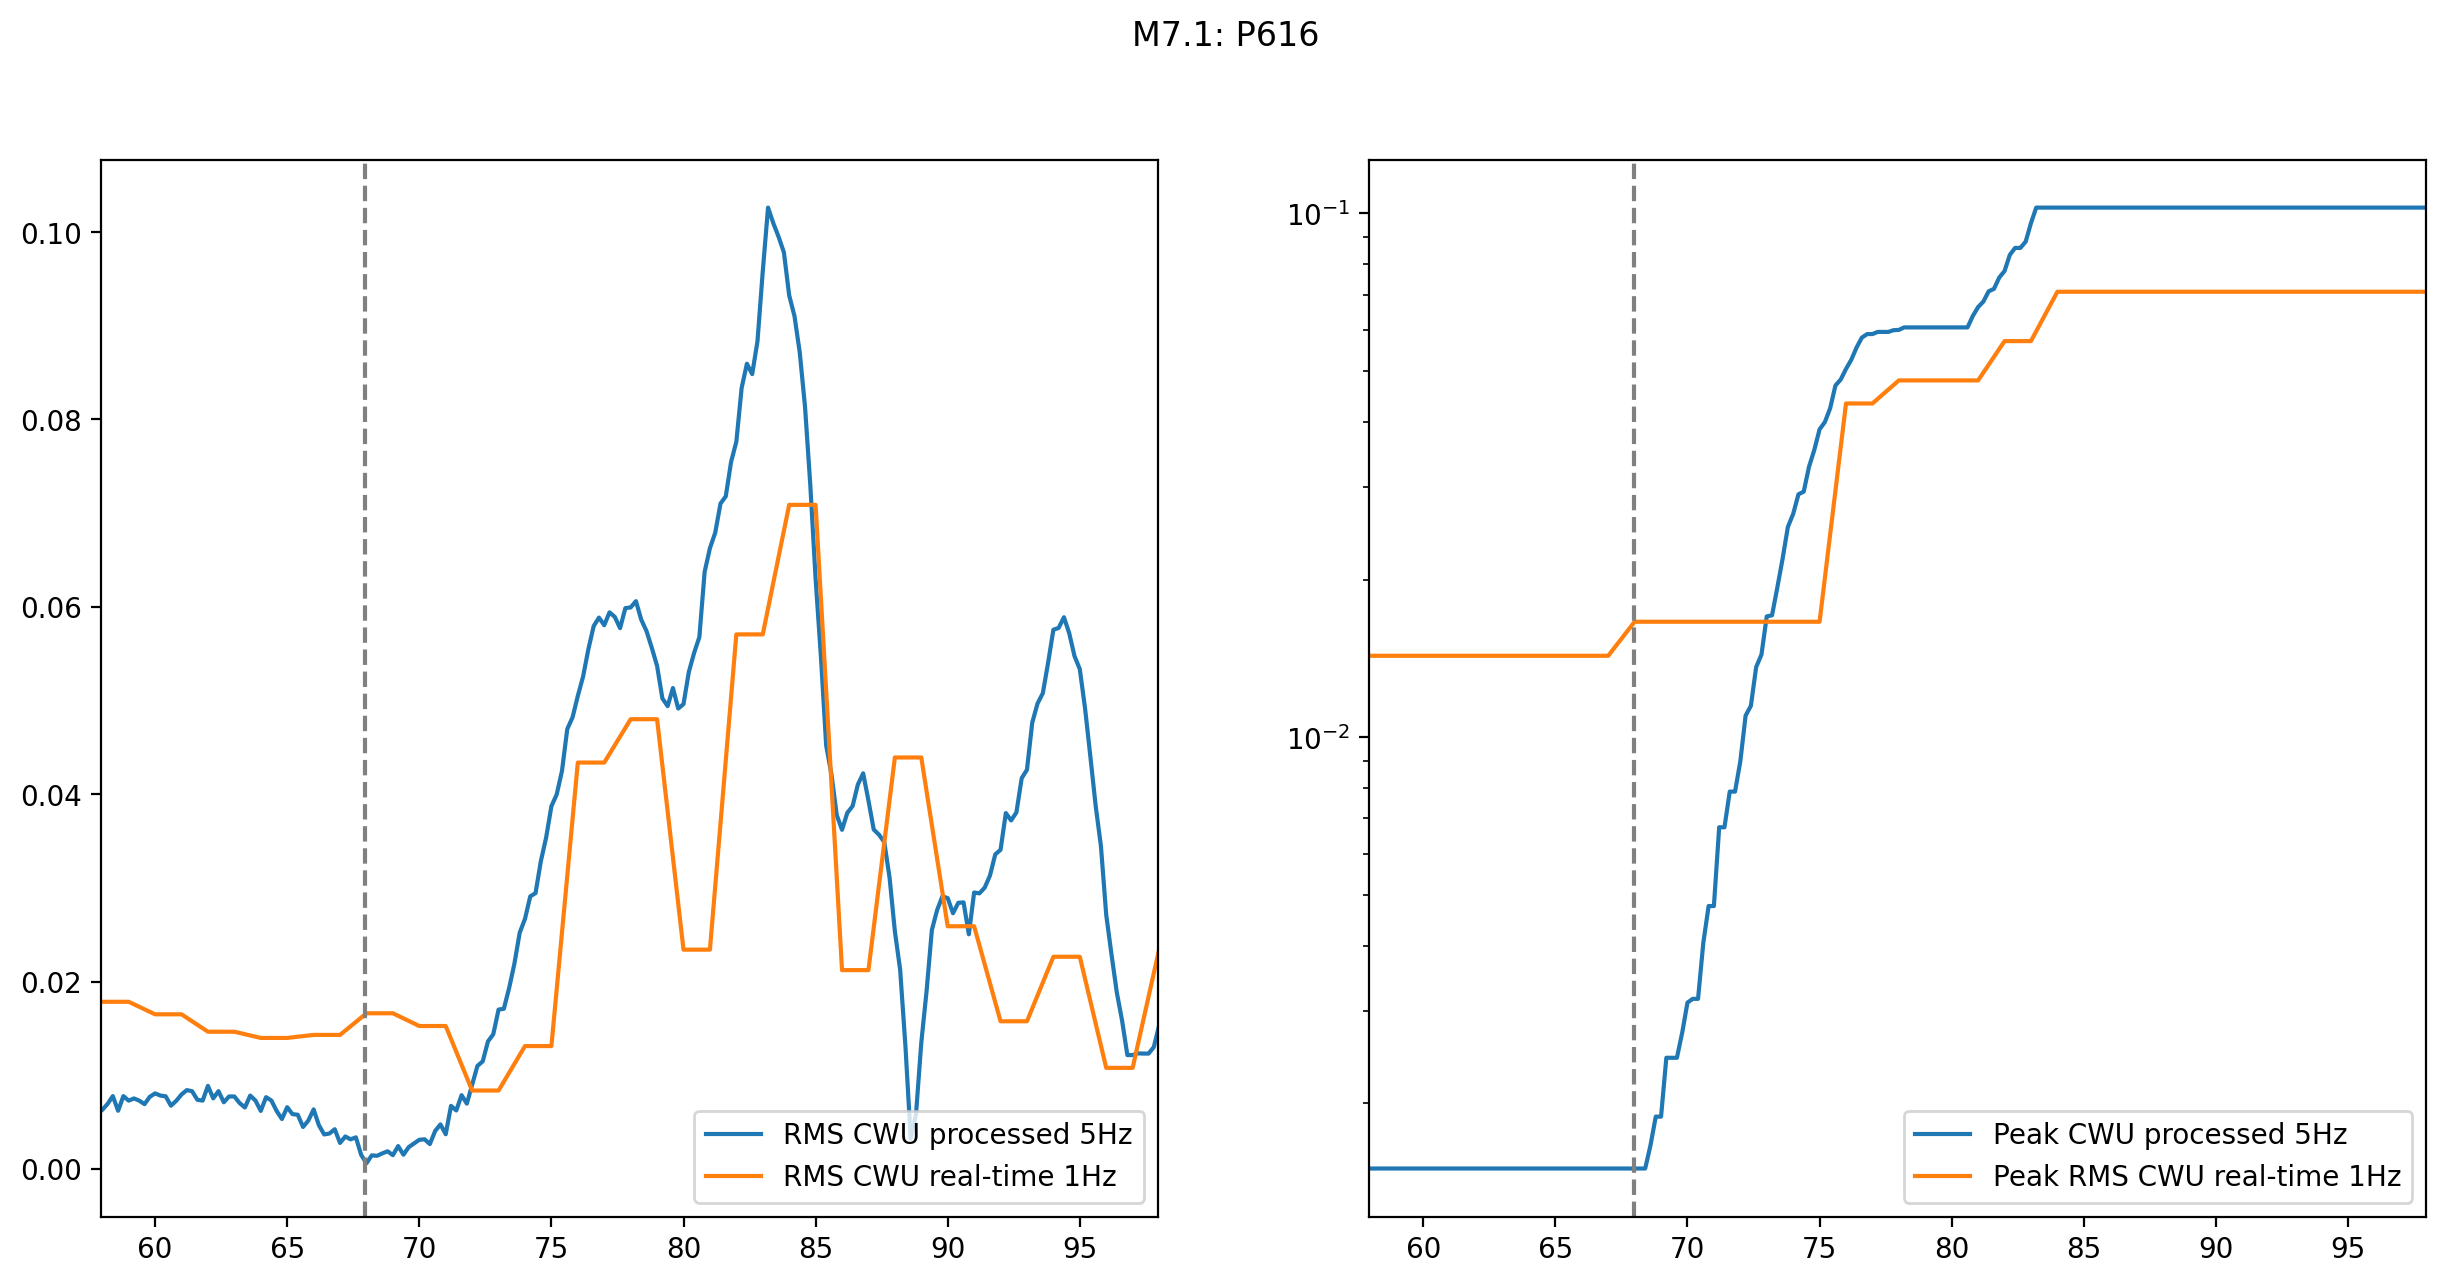

In [107]:
# M7 plots, just published data. Not messing with shifting

pub_rt_n = None
pub_rt_e = None

for idx in range(len(unav_realtime_metadata)):
    
    unav_sta = unav_realtime_metadata[idx,0]
    mag = float(unav_realtime_metadata[idx,6])
    
    if unav_sta not in pub_proc_5hz_stas_M7 or mag != 7.1:
        continue
    
    pub_sta = unav_sta.lower()

    # print(unav_sta, mag)

    ### UNAVCO data ###
    
    unav_samp_rate = 1
    unav_p_arr_samp = int(unav_realtime_metadata[idx,5])
    p_arr_time = UTCDateTime(unav_realtime_metadata[idx,2]) + unav_p_arr_samp
    
    ### Published CWU data ###
    
    # Calculate P arrival time in the published data
    pub_start_time = usgs_7_ot - 60
    pub_p_arr_sec = p_arr_time - pub_start_time

    # Calculate RMS of published horizontal data
    pub_proc_5hz_n = read(proc_5hz_M7_path + pub_sta + '.LYN.mseed')
    pub_proc_5hz_e = read(proc_5hz_M7_path + pub_sta + '.LYE.mseed')
    pub_proc_5hz_times = pub_proc_5hz_n[0].times()
    hoz_rms_pub_proc_5hz_data = np.sqrt((pub_proc_5hz_n[0].data**2 + pub_proc_5hz_e[0].data**2)/2)

    # Calculate P arrival sample in published data
    pub_proc_5hz_samp_rate = pub_proc_5hz_n[0].stats.sampling_rate
    pub_p_arr_samp_proc_5hz = int(pub_p_arr_sec * pub_proc_5hz_samp_rate)

    # Calculate the peak published GNSS data
    peak_pub_proc_5hz = get_peak_gnss(hoz_rms_pub_proc_5hz_data, pub_p_arr_samp_proc_5hz)
    
    try:
        pub_rt_n = read(rt_1hz_M7_path + pub_sta + '.LYN.mseed')
        pub_rt_e = read(rt_1hz_M7_path + pub_sta + '.LYE.mseed')
    except:
        print('No published RT data for station ' + str(pub_sta))
    
    if pub_rt_n != None:
        pub_rt_times = pub_rt_n[0].times()
        hoz_rms_pub_rt_data = np.sqrt((pub_rt_n[0].data**2 + pub_rt_e[0].data**2)/2)

        # Calculate P arrival sample in published data
        pub_rt_samp_rate = pub_rt_n[0].stats.sampling_rate
        pub_p_arr_samp_rt = int(pub_p_arr_sec * pub_rt_samp_rate)

        # Calculate the peak published GNSS data
        peak_pub_rt = get_peak_gnss(hoz_rms_pub_rt_data, pub_p_arr_samp_rt)

    xlim_low = pub_p_arr_sec - 10
    xlim_high = pub_p_arr_sec + 30
    
    plt.subplots(figsize = (15,7), dpi = 200)
    plt.suptitle('M7.1: ' + unav_sta)
    
    plt.subplot(121)
    # plt.plot(unav_rt_times, hoz_rms_unav_rt_data, label = 'RMS UNAVCO real-time 1Hz')
    plt.plot(pub_proc_5hz_times, hoz_rms_pub_proc_5hz_data, label = 'RMS CWU processed 5Hz')
    if pub_rt_n != None:
        plt.plot(pub_rt_times, hoz_rms_pub_rt_data, label = 'RMS CWU real-time 1Hz')
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.legend(loc = 'lower right')
    
    plt.subplot(122)
    # plt.plot(unav_rt_times, peak_unav_rt, label = 'Peak UNAVCO real-time 1Hz')
    plt.plot(pub_proc_5hz_times, peak_pub_proc_5hz, label = 'Peak CWU processed 5Hz')
    if pub_rt_n != None:
        plt.plot(pub_rt_times, peak_pub_rt, label = 'Peak RMS CWU real-time 1Hz')
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.semilogy()
    plt.legend(loc = 'lower right')
    
    plt.show()
    
    pub_rt_n = None
    pub_rt_e = None

In [72]:
p = np.where(np.abs(pub_proc_5hz_times - pub_p_arr_sec) < 0.1)
print((pub_proc_5hz_times - pub_p_arr_sec)[p])

[ 0.04]


In [ ]:
pub_proc_5hz_current_p_idx = np.where((pub_proc_5hz_times - pub_p_arr_sec) < tol)[0]
print(pub_proc_5hz_current_p_idx)

In [17]:
num_rt_stas = 0
num_proc_5hz_stas = 0
num_proc_1hz_stas = 0

pub_proc_5hz_stas_M6 = []
pub_proc_5hz_stas_M7 = []

for idx in range(len(unav_realtime_metadata)):
    
    unav_sta = unav_realtime_metadata[idx,0]
    
    pub_sta = unav_sta.lower()
    
    mag = float(unav_realtime_metadata[idx,6])
    
    xlim_low = 0
    xlim_high = 128

    # print(unav_sta, mag)

    p_arr_time = UTCDateTime(unav_realtime_metadata[idx,2]) + int(unav_realtime_metadata[idx,5])
    
    unav_rt_data_n = unav_realtime_data[idx,:128]
    unav_rt_data_e = unav_realtime_data[idx,128:256]
    unav_rt_data_z = unav_realtime_data[idx,256:]
    
    unav_rt_times_n = np.arange(0,len(unav_rt_data_n),1)
    unav_rt_times_e = np.arange(0,len(unav_rt_data_e),1)
    unav_rt_times_z = np.arange(0,len(unav_rt_data_z),1)
    
    if mag == 6.4:
        
        try:
            pub_rt_n = read(rt_1hz_M6_path + pub_sta + '.LYN.mseed')
            pub_rt_e = read(rt_1hz_M6_path + pub_sta + '.LYE.mseed')
            pub_rt_z = read(rt_1hz_M6_path + pub_sta + '.LYZ.mseed')
            num_rt_stas += 1
            pub_rt_stas_M6.append(unav_sta)
        except:
            pass
            
        try:
            pub_proc_1hz_n = read(proc_1hz_M6_path + pub_sta + '.LYN.mseed')
            pub_proc_1hz_e = read(proc_1hz_M6_path + pub_sta + '.LYE.mseed')
            pub_proc_1hz_z = read(proc_1hz_M6_path + pub_sta + '.LYZ.mseed')
            num_proc_1hz_stas += 1
            pub_proc_1hz_stas_M6.append(unav_sta)
        except:
            pass
        
        try:
            pub_proc_5hz_n = read(proc_5hz_M6_path + pub_sta + '.LYN.mseed')
            pub_proc_5hz_e = read(proc_5hz_M6_path + pub_sta + '.LYE.mseed')
            pub_proc_5hz_z = read(proc_5hz_M6_path + pub_sta + '.LYZ.mseed')
            num_proc_5hz_stas += 1
            pub_proc_5hz_stas_M6.append(unav_sta)
        except:
            pass
    
    elif mag == 7.1:
        
        try:
            pub_rt_n = read(rt_1hz_M7_path + pub_sta + '.LYN.mseed')
            pub_rt_e = read(rt_1hz_M7_path + pub_sta + '.LYE.mseed')
            pub_rt_z = read(rt_1hz_M7_path + pub_sta + '.LYZ.mseed')
            num_rt_stas += 1
            pub_rt_stas_M6.append(unav_sta)
        except:
            pass
            
        try:
            pub_proc_1hz_n = read(proc_1hz_M7_path + pub_sta + '.LYN.mseed')
            pub_proc_1hz_e = read(proc_1hz_M7_path + pub_sta + '.LYE.mseed')
            pub_proc_1hz_z = read(proc_1hz_M7_path + pub_sta + '.LYZ.mseed')
            num_proc_1hz_stas += 1
            pub_proc_1hz_stas_M7.append(unav_sta)
        except:
            pass
        
        try:
            pub_proc_5hz_n = read(proc_5hz_M7_path + pub_sta + '.LYN.mseed')
            pub_proc_5hz_e = read(proc_5hz_M7_path + pub_sta + '.LYE.mseed')
            pub_proc_5hz_z = read(proc_5hz_M7_path + pub_sta + '.LYZ.mseed')
            num_proc_5hz_stas += 1
            pub_proc_5hz_stas_M7.append(unav_sta)
        except:
            pass

In [18]:
pub_proc_5hz_stas_M6


['CCCC', 'P463', 'P580', 'P590', 'P592', 'P593', 'P595', 'P616', 'RAMT']

In [19]:
pub_proc_5hz_stas_M7

['CCCC',
 'LNMT',
 'P091',
 'P093',
 'P463',
 'P466',
 'P467',
 'P570',
 'P579',
 'P580',
 'P590',
 'P592',
 'P593',
 'P595',
 'P615',
 'P616']

In [ ]:
# M6 earthquake plots

for idx in range(len(unav_realtime_metadata)):
    
    unav_sta = unav_realtime_metadata[idx,0]
    
    if unav_sta not in pub_proc_5hz_stas_M6:
        continue
    
    pub_sta = unav_sta.lower()
    
    mag = float(unav_realtime_metadata[idx,6])
    
    xlim_low = 0
    xlim_high = 128

    # print(unav_sta, mag)

    p_arr_time = UTCDateTime(unav_realtime_metadata[idx,2]) + int(unav_realtime_metadata[idx,5])
    
    unav_rt_data_n = unav_realtime_data[idx,:128]
    unav_rt_data_e = unav_realtime_data[idx,128:256]
    unav_rt_data_z = unav_realtime_data[idx,256:]
    
    unav_rt_times_n = np.arange(0,len(unav_rt_data_n),1)
    unav_rt_times_e = np.arange(0,len(unav_rt_data_e),1)
    unav_rt_times_z = np.arange(0,len(unav_rt_data_z),1)
    
    if mag == 6.4:
        
        pub_start_time = usgs_6_ot - 60
        pub_p_arr_sec = p_arr_time - pub_start_time
        # xlim_low = 100
        # xlim_high = 150
        
        try:
            pub_rt_n = read(rt_1hz_M6_path + pub_sta + '.LYN.mseed')
            pub_rt_e = read(rt_1hz_M6_path + pub_sta + '.LYE.mseed')
            pub_rt_z = read(rt_1hz_M6_path + pub_sta + '.LYZ.mseed')
            num_rt_stas += 1
            pub_rt_stas_M6.append(unav_sta)
        except:
            pass
            
        try:
            pub_proc_1hz_n = read(proc_1hz_M6_path + pub_sta + '.LYN.mseed')
            pub_proc_1hz_e = read(proc_1hz_M6_path + pub_sta + '.LYE.mseed')
            pub_proc_1hz_z = read(proc_1hz_M6_path + pub_sta + '.LYZ.mseed')
            num_proc_1hz_stas += 1
            pub_proc_1hz_stas_M6.append(unav_sta)
        except:
            pass
        
        try:
            pub_proc_5hz_n = read(proc_5hz_M6_path + pub_sta + '.LYN.mseed')
            pub_proc_5hz_e = read(proc_5hz_M6_path + pub_sta + '.LYE.mseed')
            pub_proc_5hz_z = read(proc_5hz_M6_path + pub_sta + '.LYZ.mseed')
            num_proc_5hz_stas += 1
            pub_proc_5hz_stas_M6.append(unav_sta)
        except:
            pass
    
    elif mag == 7.1:
        
        pub_start_time = usgs_7_ot - 60
        pub_p_arr_sec = p_arr_time - pub_start_time
        # xlim_low = 50
        # xlim_high = 85
        
        try:
            pub_rt_n = read(rt_1hz_M7_path + pub_sta + '.LYN.mseed')
            pub_rt_e = read(rt_1hz_M7_path + pub_sta + '.LYE.mseed')
            pub_rt_z = read(rt_1hz_M7_path + pub_sta + '.LYZ.mseed')
            num_rt_stas += 1
            pub_rt_stas_M6.append(unav_sta)
        except:
            pass
            
        try:
            pub_proc_1hz_n = read(proc_1hz_M7_path + pub_sta + '.LYN.mseed')
            pub_proc_1hz_e = read(proc_1hz_M7_path + pub_sta + '.LYE.mseed')
            pub_proc_1hz_z = read(proc_1hz_M7_path + pub_sta + '.LYZ.mseed')
            num_proc_1hz_stas += 1
            pub_proc_1hz_stas_M7.append(unav_sta)
        except:
            pass
        
        try:
            pub_proc_5hz_n = read(proc_5hz_M7_path + pub_sta + '.LYN.mseed')
            pub_proc_5hz_e = read(proc_5hz_M7_path + pub_sta + '.LYE.mseed')
            pub_proc_5hz_z = read(proc_5hz_M7_path + pub_sta + '.LYZ.mseed')
            num_proc_5hz_stas += 1
            pub_proc_5hz_stas_M7.append(unav_sta)
        except:
            pass

    unav_p_arr_samp = int(unav_realtime_metadata[idx,5])
    
    try:
        pub_rt_times_n = pub_rt_n[0].times()
        pub_rt_data_n = pub_rt_n[0].data
        pub_rt_times_e = pub_rt_e[0].times()
        pub_rt_data_e = pub_rt_e[0].data
        pub_rt_times_z = pub_rt_z[0].times()
        pub_rt_data_z = pub_rt_z[0].data
        
        pub_p_arr_samp_rt = int(pub_p_arr_sec * pub_rt_n[0].stats.sampling_rate)
        
        peak_pub_rt_n = get_peak_gnss(pub_rt_data_n, pub_p_arr_samp_rt)
        peak_pub_rt_e = get_peak_gnss(pub_rt_data_e, pub_p_arr_samp_rt)
        peak_pub_rt_z = get_peak_gnss(pub_rt_data_z, pub_p_arr_samp_rt)
    except:
        pass
    
    try:
        pub_proc_1hz_times_n = pub_proc_1hz_n[0].times()
        pub_proc_1hz_data_n = pub_proc_1hz_n[0].data
        pub_proc_1hz_times_e = pub_proc_1hz_e[0].times()
        pub_proc_1hz_data_e = pub_proc_1hz_e[0].data
        pub_proc_1hz_times_z = pub_proc_1hz_z[0].times()
        pub_proc_1hz_data_z = pub_proc_1hz_z[0].data
        
        pub_p_arr_samp_proc_1hz = int(pub_p_arr_sec * pub_proc_1hz_n[0].stats.sampling_rate)
        
        peak_pub_proc_1hz_n = get_peak_gnss(pub_proc_1hz_data_n, pub_p_arr_samp_proc_1hz)
        peak_pub_proc_1hz_e = get_peak_gnss(pub_proc_1hz_data_e, pub_p_arr_samp_proc_1hz)
        peak_pub_proc_1hz_z = get_peak_gnss(pub_proc_1hz_data_z, pub_p_arr_samp_proc_1hz)
    except:
        pass
    
    try:
        pub_proc_5hz_times_n = pub_proc_5hz_n[0].times()
        pub_proc_5hz_data_n = pub_proc_5hz_n[0].data
        pub_proc_5hz_times_e = pub_proc_5hz_e[0].times()
        pub_proc_5hz_data_e = pub_proc_5hz_e[0].data
        pub_proc_5hz_times_z = pub_proc_5hz_z[0].times()
        pub_proc_5hz_data_z = pub_proc_5hz_z[0].data
        
        pub_p_arr_samp_proc_5hz = int(pub_p_arr_sec * pub_proc_5hz_n[0].stats.sampling_rate)
        
        peak_pub_proc_5hz_n = get_peak_gnss(pub_proc_5hz_data_n, pub_p_arr_samp_proc_5hz)
        peak_pub_proc_5hz_e = get_peak_gnss(pub_proc_5hz_data_e, pub_p_arr_samp_proc_5hz)
        peak_pub_proc_5hz_z = get_peak_gnss(pub_proc_5hz_data_z, pub_p_arr_samp_proc_5hz)
    except:
        pass
    
    # Calculate the peak GNSS data
    peak_unav_rt_n = get_peak_gnss(unav_rt_data_n, unav_p_arr_samp)
    peak_unav_rt_e = get_peak_gnss(unav_rt_data_e, unav_p_arr_samp)
    peak_unav_rt_z = get_peak_gnss(unav_rt_data_z, unav_p_arr_samp)
    
    # Shift the published data to match the UNAVCO P-wave arrival time
    if pub_p_arr_sec >= unav_p_arr_samp: # Shift the published GNSS backward
        shift_amount = pub_p_arr_sec - unav_p_arr_samp
        try:
            pub_rt_times_n = pub_rt_times_n - shift_amount
        except:
            pass
        try:
            pub_proc_1hz_times_n = pub_proc_1hz_times_n - shift_amount
        except:
            pass
        try:
            pub_proc_5hz_times_n = pub_proc_5hz_times_n - shift_amount
        except:
            pass
        pub_p_arr_sec = pub_p_arr_sec - shift_amount
    else: # Shift the published GNSS forward
        shift_amount = unav_p_arr_samp - pub_p_arr_sec
        try:
            pub_rt_times_n = pub_rt_times_n + shift_amount
        except:
            pass
        try:
            pub_proc_1hz_times_n = pub_proc_1hz_times_n + shift_amount
        except:
            pass
        try:
            pub_proc_5hz_times_n = pub_proc_5hz_times_n + shift_amount
        except:
            pass
        pub_p_arr_sec = pub_p_arr_sec + shift_amount
    
    # Plot the actual GNSS data
    
    plt.subplots(figsize = (20,6))
    plt.suptitle('M' + str(mag) + ' GNSS data (m), station ' + str(unav_sta))
    
    plt.subplot(131)
    plt.plot(unav_rt_times_n, unav_rt_data_n, label = 'UNAVCO real-time 1Hz')
    try:
        plt.plot(pub_rt_times_n, pub_rt_data_n, label = 'CWU real-time 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_1hz_times_n, pub_proc_1hz_data_n, label = 'CWU processed 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_5hz_times_n, pub_proc_5hz_data_n, label = 'CWU processed 5Hz')
    except:
        pass
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.xlabel('Time (s)')
    plt.ylabel('N-S displacement (m)')
    plt.legend(loc = 'lower right')
    
    plt.subplot(132)
    plt.plot(unav_rt_times_e, unav_rt_data_e, label = 'UNAVCO real-time 1Hz')
    try:
        plt.plot(pub_rt_times_e, pub_rt_data_e, label = 'CWU real-time 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_1hz_times_e, pub_proc_1hz_data_e, label = 'CWU processed 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_5hz_times_e, pub_proc_5hz_data_e, label = 'CWU processed 5Hz')
    except:
        pass
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.xlabel('Time (s)')
    plt.ylabel('E-W displacement (m)')
    plt.legend(loc = 'lower right')
    
    plt.subplot(133)
    plt.plot(unav_rt_times_z, unav_rt_data_z, label = 'UNAVCO real-time 1Hz')
    try:
        plt.plot(pub_rt_times_z, pub_rt_data_z, label = 'CWU real-time 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_1hz_times_z, pub_proc_1hz_data_z, label = 'CWU processed 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_5hz_times_z, pub_proc_5hz_data_z, label = 'CWU processed 5Hz')
    except:
        pass
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.xlabel('Time (s)')
    plt.ylabel('Vertical displacement (m)')
    plt.legend(loc = 'lower right')
    
    plt.show()
    
    
    # Plot the peak GNSS data
    
    plt.subplots(figsize = (20,6))
    plt.suptitle('M' + str(mag) + ' peak GNSS data (m), station ' + str(unav_sta))
    
    plt.subplot(131)
    plt.plot(unav_rt_times_n, peak_unav_rt_n, label = 'UNAVCO real-time 1Hz')
    try:
        plt.plot(pub_rt_times_n, peak_pub_rt_n, label = 'CWU real-time 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_1hz_times_n, peak_pub_proc_1hz_n, label = 'CWU processed 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_5hz_times_n, peak_pub_proc_5hz_n, label = 'CWU processed 5Hz')
    except:
        pass
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.xlabel('Time (s)')
    plt.ylabel('Peak N-S displacement (m)')
    plt.semilogy()
    plt.legend(loc = 'lower right')

    plt.subplot(132)
    plt.plot(unav_rt_times_e, peak_unav_rt_e, label = 'UNAVCO real-time 1Hz')
    try:
        plt.plot(pub_rt_times_e, peak_pub_rt_e, label = 'CWU real-time 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_1hz_times_e, peak_pub_proc_1hz_e, label = 'CWU processed 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_5hz_times_e, peak_pub_proc_5hz_e, label = 'CWU processed 5Hz')
    except:
        pass
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.xlabel('Time (s)')
    plt.ylabel('Peak E-W displacement (m)')
    plt.semilogy()
    plt.legend(loc = 'lower right')
    
    plt.subplot(133)
    plt.plot(unav_rt_times_z, peak_unav_rt_z, label = 'UNAVCO real-time 1Hz')
    try:
        plt.plot(pub_rt_times_z, peak_pub_rt_z, label = 'CWU real-time 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_1hz_times_z, peak_pub_proc_1hz_z, label = 'CWU processed 1Hz')
    except:
        pass
    try:
        plt.plot(pub_proc_5hz_times_z, peak_pub_proc_5hz_z, label = 'CWU processed 5Hz')
    except:
        pass
    plt.axvline(pub_p_arr_sec, color = 'gray', linestyle = '--')
    plt.xlim(xlim_low, xlim_high)
    plt.xlabel('Time (s)')
    plt.ylabel('Peak Vertical displacement (m)')
    plt.semilogy()
    plt.legend(loc = 'lower right')
    
    plt.show()
    
    try:
        del(pub_rt_times_n, pub_rt_data_n, peak_pub_rt_n, pub_proc_1hz_times_n, pub_proc_1hz_data_n, peak_pub_proc_1hz_n,
        pub_proc_5hz_times_n, pub_proc_5hz_data_n, peak_pub_proc_5hz_n,
       pub_rt_times_e, pub_rt_data_e, peak_pub_rt_e, pub_proc_1hz_times_e, pub_proc_1hz_data_e, peak_pub_proc_1hz_e,
        pub_proc_5hz_times_e, pub_proc_5hz_data_e, peak_pub_proc_5hz_e,
       pub_rt_times_z, pub_rt_data_z, peak_pub_rt_z, pub_proc_1hz_times_z, pub_proc_1hz_data_z, peak_pub_proc_1hz_z,
        pub_proc_5hz_times_z, pub_proc_5hz_data_z, peak_pub_proc_5hz_z,
       pub_p_arr_sec)
    except:
        pass
        
print(num_rt_stas)
print(num_proc_5hz_stas)
print(num_proc_1hz_stas)